# Contents

- [Introduction](#introduction)
- [Data description](#data-description)
- [Univariate analysis](#Univariate-analysis)
- [Multivariate analysis](#Multivariate-analysis)
- [Test set analysis](#Test-set-analysis)
- [Conclusion](#Conclusion)

# Spaceship Titanic
Predict which passengers are transported to an alternate dimension

## Introduction
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

<img src="https://storage.googleapis.com/kaggle-media/competitions/Spaceship%20Titanic/joel-filipe-QwoNAhbmLLo-unsplash.jpg" width=600>

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

## Libraries installing and dataset downloading

In [1]:
%%capture

! pip install kaggle
! pip install numpy
! pip install pandas
! pip install sklearn
! pip install matplotlib
! pip install seaborn
! pip install statsmodels
! pip install missingno

In [2]:
# Flag to force to reload dataset
RELOAD = False

In [3]:
import time, psutil, os

# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

In [4]:
from zipfile import ZipFile

# import Kaggle API to load dataset
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

# initialize Kaggle API
api = KaggleApi()
api.authenticate()

# download dataset from Kaggle to data folder
data_path = 'data'
api.competition_download_files('spaceship-titanic', data_path, force=RELOAD, quiet=False)

dataset_file_name = 'spaceship-titanic.zip'


with ZipFile(os.path.join(data_path, dataset_file_name), 'r') as zip_ref:
    zip_ref.extractall(data_path)

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


[Contents](#contents)

## Data description
* **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
    - `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
    - `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - `Destination` - The planet the passenger will be debarking to.
    - `Age` - The age of the passenger.
    - `VIP` - Whether the passenger has paid for special VIP service during the voyage.
    - `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - `Name` - The first and last names of the passenger.
    - `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of `Transported` for the passengers in this set.
* **sample_submission.csv** - A submission file in the correct format.
    - `PassengerId` - Id for each passenger in the test set.
    - `Transported` - The target. For each passenger, predict either `True` or `False`.

In [5]:
import pandas as pd

# Load data to variables
df = pd.read_csv(os.path.join(data_path, 'train.csv'))                                          # This dataset will be split on train-test-val
df_kaggle_test = pd.read_csv(os.path.join(data_path, 'test.csv'))                               # This dataset doesn't have labels, so will not be used for any of analysis/modeling, only final prediction
df_kaggle_sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))     # This is an example of submission 

In [6]:
# Check shapes of loaded df's
print(f'Shape of df: {str(df.shape)}')
print(f'Shape of df_kaggle_test: {str(df_kaggle_test.shape)}')
print(f'Shape of df_kaggle_sample_submission: {str(df_kaggle_sample_submission.shape)}')

Shape of df: (8693, 14)
Shape of df_kaggle_test: (4277, 13)
Shape of df_kaggle_sample_submission: (4277, 2)


## Exploratory Data Analysis

First, let's take a look on df, it's head and structure

In [7]:
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [8]:
original_columns = df.columns.to_list()
print(original_columns)

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']


### Univariate analysis

#### PassengerId

In [9]:
# All passengerIDs should be unique, but let's check
print(f'Unique passangerIDs: {len(df.PassengerId.unique())} out of {len(df)} total records')

Unique passangerIDs: 8693 out of 8693 total records


Many passengers travel in groups (see field descriptiuon), let's extract group number from passengerID

In [10]:
df[['GroupId', 'PassengerId_no_group']] = df['PassengerId'].str.split('_', expand=True)

In [11]:
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported GroupId PassengerId_no_group  
0        False    0001                   01  
1         True    0002                   01  
2        False    0003                   01  
3        False    0003                   02  
4         True    0004                   01

In [12]:
# Check number of groups
print(f'Unique GroupIDs: {len(df.GroupId.unique())} out of {len(df)} total records')

Unique GroupIDs: 6217 out of 8693 total records


In [13]:
# Maximum and minimum amount of passangers in each group
df.groupby('GroupId')['PassengerId'].count().max(), df.groupby('GroupId')['PassengerId'].count().min()

(8, 1)

In [14]:
# Add group size as column
df = pd.merge(df, df.groupby('GroupId')['PassengerId'].count(), how='left', on='GroupId')
# Rename columns, that they are more meaningful
df.rename({'PassengerId_y': 'Group_size', 'PassengerId_x': 'Full_Id', 'PassengerId_no_group': 'PassengerId'}, axis=1, inplace=True)

In [15]:
df.head()

Full_Id HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  \
0  0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0   
1  0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0   
2  0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True         43.0   
3  0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False          0.0   
4  0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck               Name  Transported  \
0        0.0           0.0     0.0     0.0    Maham Ofracculy        False   
1        9.0          25.0   549.0    44.0       Juanna Vines         True   
2     3576.0           0.0  6715.0    49.0      Altark Susent        False   
3     1283.0         371.0  3329.0   193.0       Solam Susent        False   
4       70.0         151.0   565.0     2.0  Willy Santantines         True   

  GroupId PassengerId  Group_size  
0    0001          01           1  
1    0002          01           1  
2    0003          01           2  
3    0003          02           2  
4    0004          01           1

In [16]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Function to use a slice from standard colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Visualisation helper function
def plot_groups(column, df=df, xlabel='', ylablel='', title=''):
    grouped_df = df.groupby([column]).size()

    plt.figure(figsize=(10,5))

    data_norm = [(x) / max(grouped_df) for x in grouped_df]
    my_cmap = plt.cm.get_cmap('PuBu')
    my_cmap = truncate_colormap(my_cmap, 0.4, 0.8)
    colors = my_cmap(data_norm)


    grouped_df.plot(kind='bar', rot=0, color=colors)
    plt.xlabel(xlabel)
    plt.ylabel(ylablel)
    plt.title(title)
    plt.show();


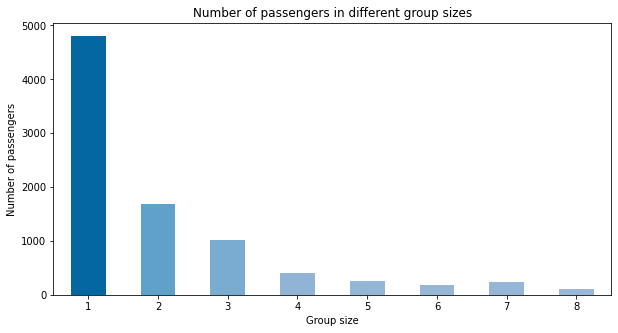

In [17]:
# Group size visualization
plot_groups('Group_size', xlabel='Group size', ylablel='Number of passengers', title='Number of passengers in different group sizes')

About half of the passengers in the test set traveled alone. Groups of 2 or 3 people are also common. 

#### HomePlanet

In [18]:
# HomePlanet field
df['HomePlanet'].unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [19]:
df['HomePlanet'].isna().sum()

201

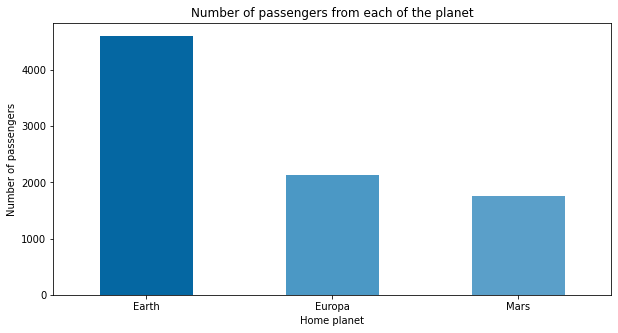

In [20]:
# How many passengers from each of the planet
plot_groups('HomePlanet', xlabel='Home planet', ylablel='Number of passengers', title='Number of passengers from each of the planet')

Only three home planets are in data. 201 records (out of 8693) are missing.

About half of the passengers are from Earth.

#### CryoSleep

In [21]:
df['CryoSleep'].unique()

array([False, True, nan], dtype=object)

In [22]:
df['CryoSleep'].isna().sum()

217

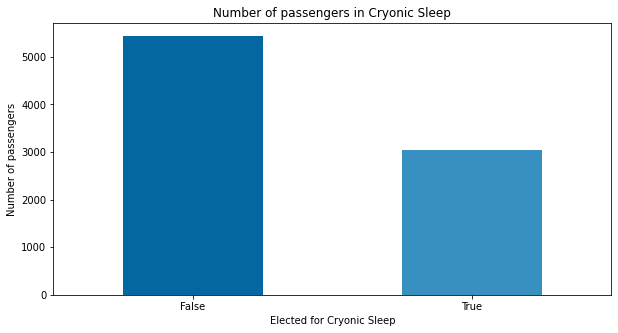

In [23]:
plot_groups('CryoSleep', xlabel='Elected for Cryonic Sleep', ylablel='Number of passengers', title='Number of passengers in Cryonic Sleep')

Options are False or True, 217 (out of 8693) values are missing

About 1/3 of the passengers from test set were elected for CryoSleep

#### Cabin

In [24]:
df['Cabin'].nunique()

6560

In [25]:
df['Cabin'].isna().sum()

199

Amount of unique cabin numbers is less than passengers number. So, not all passengers travelled in own cabin. Let's plot how many passengers were in the one cabin.

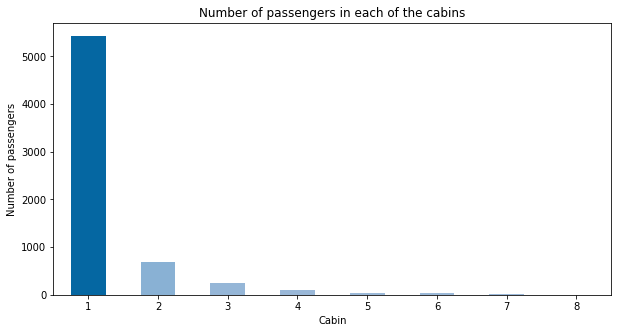

In [26]:
by_cabins_df = pd.DataFrame(df.groupby(by='Cabin').size())
plot_groups(0, df=by_cabins_df, xlabel='Cabin', ylablel='Number of passengers', title='Number of passengers in each of the cabins')

More than half of the passengers travelled alone in their cabins.
Let's find number of cabinmates for each of the passengers (1 means alone in the cabin)

In [27]:
# Add cabinmates as column
df = pd.merge(df, df.groupby('Cabin')['PassengerId'].count().rename('Number_of_cabinmates'), how='left', on='Cabin')

Cabin contains deck number, number of cabin on deck and side (P for Port or S for Starboard). Let's extract this information.

In [28]:
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)

In [29]:
df.head()

Full_Id HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  \
0  0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0   
1  0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0   
2  0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True         43.0   
3  0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False          0.0   
4  0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall  ...  VRDeck               Name Transported  \
0        0.0           0.0  ...     0.0    Maham Ofracculy       False   
1        9.0          25.0  ...    44.0       Juanna Vines        True   
2     3576.0           0.0  ...    49.0      Altark Susent       False   
3     1283.0         371.0  ...   193.0       Solam Susent       False   
4       70.0         151.0  ...     2.0  Willy Santantines        True   

   GroupId PassengerId Group_size  Number_of_cabinmates  Deck Num Side  
0     0001          01          1                   1.0     B   0    P  
1     0002          01          1                   1.0     F   0    S  
2     0003          01          2                   2.0     A   0    S  
3     0003          02          2                   2.0     A   0    S  
4     0004          01          1                   1.0     F   1    S  

[5 rows x 21 columns]

In [30]:
df['Deck'].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [31]:
# Total number of unique cabin numbers
df['Num'].nunique()

1817

In [32]:
# Number of unique cabin numbers on each deck
df.groupby(by='Deck')['Num'].nunique()

Deck
A      97
B     312
C     301
D     251
E     527
F    1620
G    1341
T       4
Name: Num, dtype: int64

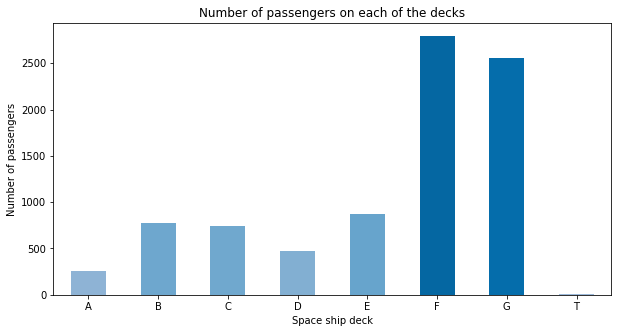

In [33]:
plot_groups('Deck', df=df, xlabel='Space ship deck', ylablel='Number of passengers', title='Number of passengers on each of the decks')

Most of the passengers had a cabin on decks `F` and `G`, which correlated with amount of cabins on each of the decks

In [34]:
df['Side'].unique()

array(['P', 'S', nan], dtype=object)

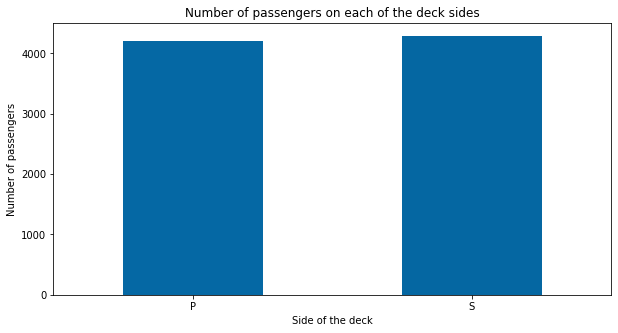

In [35]:
plot_groups('Side', df=df, xlabel='Side of the deck', ylablel='Number of passengers', title='Number of passengers on each of the deck sides')

Approximately the same amount of passengers cabins were located on each of spaceship sides.

199 records (out of 8693) are missing.

#### Destination

In [36]:
df['Destination'].nunique()

3

In [37]:
df['Destination'].isna().sum()

182

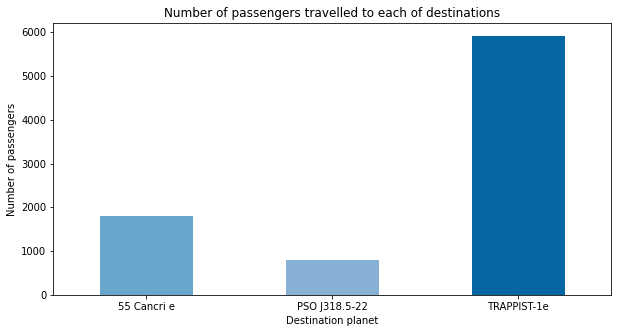

In [38]:
plot_groups('Destination', df=df, xlabel='Destination planet', ylablel='Number of passengers', title='Number of passengers travelled to each of destinations')

Vast majority of the passengers travelled to TRAPPIST-1e (https://en.wikipedia.org/wiki/TRAPPIST-1e), second popular destination is 55 Cancri e (https://en.wikipedia.org/wiki/55_Cancri_e), and finally, less than 1000 passenger travelled to PSO J318.5-22 (https://en.wikipedia.org/wiki/PSO_J318.5%E2%88%9222), which doesn't orbit a parent star.

182 (out of 8693) destination records are missing

#### Age

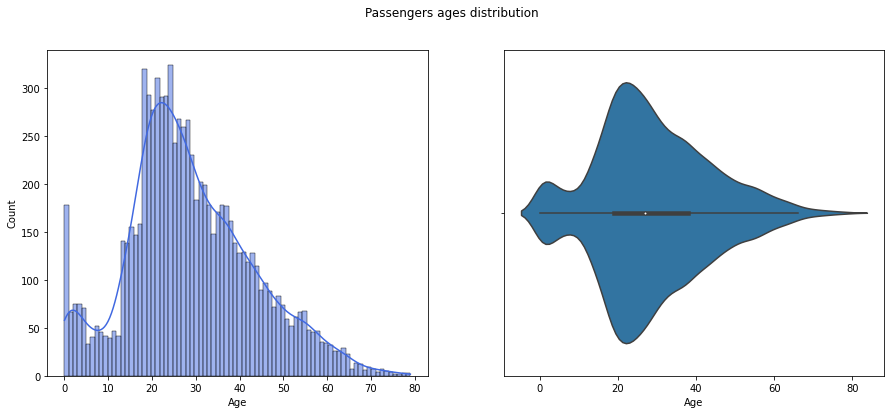

In [39]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize = (15, 6))
sns.histplot(x=df['Age'], kde=True, bins=80, color = 'royalblue', ax=ax[0])
sns.violinplot(x=df['Age'], ax=ax[1])
fig.suptitle("Passengers ages distribution")
plt.show();

In [40]:
print(f"Coefficient of skewness: {df['Age'].skew():.2f}")

Coefficient of skewness: 0.42


In [41]:
df['Age'].describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

In [42]:
df['Age'].isna().sum()

179

Age distribution density plot looks like a bit positively skewed distribution with additional peak on the left. Half of the passengers are in between 19 and 38 years old, and also many children 0-5 years.

179 passengers (out of 8693) don't have age indicated

#### VIP

In [43]:
df['VIP'].unique()

array([False, True, nan], dtype=object)

In [44]:
df['VIP'].isna().sum()

203

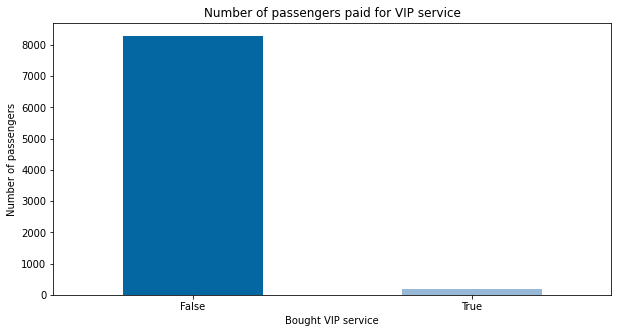

In [45]:
plot_groups('VIP', xlabel='Bought VIP service', ylablel='Number of passengers', title='Number of passengers paid for VIP service')

Only small part of the passengers had paid for VIP service. 203 records are missing

#### Money spent on additional services (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)

In [46]:
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].describe()

RoomService     FoodCourt  ShoppingMall           Spa        VRDeck
count   8512.000000   8510.000000   8485.000000   8510.000000   8505.000000
mean     224.687617    458.077203    173.729169    311.138778    304.854791
std      666.717663   1611.489240    604.696458   1136.705535   1145.717189
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.000000      0.000000
75%       47.000000     76.000000     27.000000     59.000000     46.000000
max    14327.000000  29813.000000  23492.000000  22408.000000  24133.000000

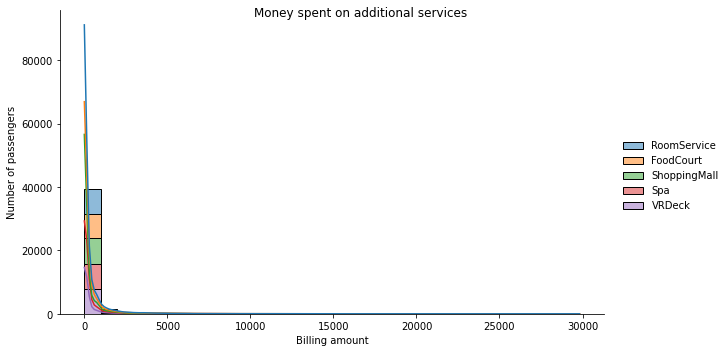

In [47]:
g = sns.displot(df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']], kde=True, bins=30, multiple="stack", height=4.75, aspect=1.83)
g.set_axis_labels("Billing amount", "Number of passengers")
g.fig.suptitle("Money spent on additional services");

These variables are extremely skewed. To deal with it, we have applied the following transformation: $x \mapsto log(x+\epsilon),$ where $\epsilon$ is a very small positive real number. Here we have taken $\epsilon = 0.00000001$. The reason behind making this small shift to the data is that the log function maps $0$ to $-\infty$. The shift keeps the transformed data finite, and keeping $\epsilon$ small ensures that the data points which were originally $0,$ stands out from the rest in the transformed setup. Visualizations of the distribution of both the original feature and the transformed feature have been shown.

In [48]:
epsilon = 0.00000001
df['RoomService_transformed'] = df['RoomService'].apply(lambda x: np.log(x + epsilon))
df['FoodCourt_transformed'] = df['FoodCourt'].apply(lambda x: np.log(x + epsilon))
df['ShoppingMall_transformed'] = df['ShoppingMall'].apply(lambda x: np.log(x + epsilon))
df['Spa_transformed'] = df['Spa'].apply(lambda x: np.log(x + epsilon))
df['VRDeck_transformed'] = df['VRDeck'].apply(lambda x: np.log(x + epsilon))

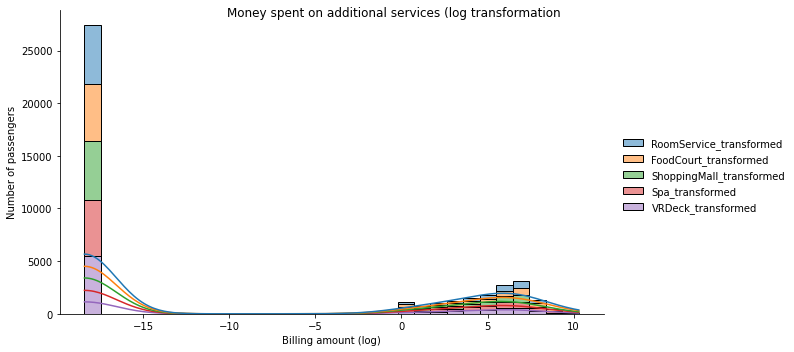

In [49]:
g = sns.displot(df[['RoomService_transformed', 'FoodCourt_transformed', 'ShoppingMall_transformed', 'Spa_transformed', 'VRDeck_transformed']], kde=True, bins=30, multiple="stack", height=4.75, aspect=1.83)
g.set_axis_labels("Billing amount (log)", "Number of passengers")
g.fig.suptitle("Money spent on additional services (log transformation");

In [50]:
print("Coefficient of skewness before transformation:")
print(f"\tRoomService: {df['RoomService'].skew():.2f}")
print(f"\tFoodCourt: {df['FoodCourt'].skew():.2f}")
print(f"\tShoppingMall: {df['ShoppingMall'].skew():.2f}")
print(f"\tSpa: {df['Spa'].skew():.2f}")
print(f"\tVRDeck: {df['VRDeck'].skew():.2f}")

print("\nCoefficient of skewness after transformation:")
print(f"\tRoomService: {df['RoomService_transformed'].skew():.2f}")
print(f"\tFoodCourt: {df['FoodCourt_transformed'].skew():.2f}")
print(f"\tShoppingMall: {df['ShoppingMall_transformed'].skew():.2f}")
print(f"\tSpa: {df['Spa_transformed'].skew():.2f}")
print(f"\tVRDeck: {df['VRDeck_transformed'].skew():.2f}")

Coefficient of skewness before transformation:
	RoomService: 6.33
	FoodCourt: 7.10
	ShoppingMall: 12.63
	Spa: 7.64
	VRDeck: 7.82

Coefficient of skewness after transformation:
	RoomService: 0.69
	FoodCourt: 0.64
	ShoppingMall: 0.71
	Spa: 0.57
	VRDeck: 0.66


It looks like distribution have two peaks and almost nothing in between them. Let's try to make two bins from the distribution: passengers who paid for additional service at least something and who did not

In [51]:
df['Paid_RoomService'] = df['RoomService'] > 0
df['Paid_FoodCourt'] = df['FoodCourt'] > 0
df['Paid_ShoppingMall'] = df['ShoppingMall'] > 0
df['Paid_Spa'] = df['Spa'] > 0
df['Paid_VRDeck'] = df['VRDeck'] > 0

print(f"Passengers who paid for Room Service: {df['Paid_RoomService'].sum()}")
print(f"Passengers who paid for Food Court: {df['Paid_FoodCourt'].sum()}")
print(f"Passengers who paid for Shopping Mall: {df['Paid_ShoppingMall'].sum()}")
print(f"Passengers who paid for Spa: {df['Paid_Spa'].sum()}")
print(f"Passengers who paid for VRDeck: {df['Paid_VRDeck'].sum()}")

Passengers who paid for Room Service: 2935
Passengers who paid for Food Court: 3054
Passengers who paid for Shopping Mall: 2898
Passengers who paid for Spa: 3186
Passengers who paid for VRDeck: 3010


In [52]:
df['RoomService'].isna().sum(), df['FoodCourt'].isna().sum(), df['ShoppingMall'].isna().sum(), df['Spa'].isna().sum(), df['VRDeck'].isna().sum()

(181, 183, 208, 183, 188)

Most of the passengers didn't spend money on all additional services, less than 25% of passengers spent large amounts on some of them.
Distribution is highly skewed, therefore tranformed columns were added. Also, looking that most of the passengers didn't spend money at all, I decided to try to make these variables binary.
About 180-200 records for each of these columns are missing.



#### Name

In [53]:
df['Name'].isna().sum()

200

In [54]:
df['Name'].nunique()

8473

In [55]:
len(df[(df.duplicated('Name')) & ~df['Name'].isna()])

20

200 passengers didn't indicate their names and 20 of them had full namesakes on the Spaceship

In [56]:
# Split Name for First Name and Last Name
df[['First_name', 'Last_name']] = df['Name'].str.split(' ', expand=True)

In [57]:
df[['First_name', 'Last_name']].head()

First_name    Last_name
0      Maham    Ofracculy
1     Juanna        Vines
2     Altark       Susent
3      Solam       Susent
4      Willy  Santantines

In [58]:
len(df[(df.duplicated('First_name')) & ~df['First_name'].isna()]), len(df[(df.duplicated('Last_name')) & ~df['Last_name'].isna()])

(5787, 6276)

About of 3/4 of first and last names are not unique among the passengers of the SpaceShip

Let's add number of last namesakes to the df. 

❗ I consider, that first name doesn't indicate any relations. This will stay as untested in the current EDA assumption based on life experience: relatives with the same last names very rare have the same first names, and people with the same first names, most of the time have nothing else in common. 

In [59]:
# Add namesakes number as column
df = pd.merge(df, df.groupby('Last_name')['PassengerId'].count().rename('Number_of_namesakes'), how='left', on='Last_name')

#### Transported

In [60]:
df['Transported'].isna().sum()

0

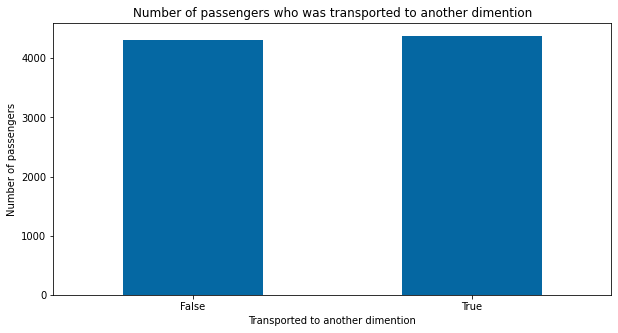

In [61]:
plot_groups('Transported', xlabel='Transported to another dimention', ylablel='Number of passengers', title='Number of passengers who was transported to another dimention')

About half of the passengers were sent to alternate dimension

#### Univariate analysis summary

- Train dataset contains 8693 records
- Each entry contains unique Passenger ID, based on it we can find size of the group (e.g. family or friends) of passengers who travel together: Most of the passengers traveled alone or in 2 or 3 persons groups
- About half of the passengers were from Earth, another half from Europa and Mars
- About 1/3 of the passengers were in Cryonic Sleep during the travel
- More than half passengers travelled in separate cabin, some shared their cabin 2, 3 or more people (more people in cabin - more rare)
- Ship has 8 decks, with different number of cabins on each deck. Decks F and G has the most cabins and also most of the passengers are from these decks
- There were almost equal number of passengers on each side of the deck
- About 2/3 of the passengers travelled to TRAPPIST-1e
- Passengers were from 0 up to 79 years old, with half of them between 19 and 38 years old. Distribution of ages is not standard, as could be expected: there were many 0 years old babies onboard, but not so many 5-15 years old passengers
- Almost nobody bought VIP service
- Most of the passengers didn't spend money on additional services, but some of them spent a lot; Distributions of these variables are highly skewed and shell be normalized or binned (2 or more bins) 
- 20 passengers have full namesakes travelling with them
- Half of all passengers were transported to another dimention 
- Each column, except `PassengerId` and `Transported` have about 200 NaN values

[Contents](#contents)

### Multivariate analysis

#### Missing values

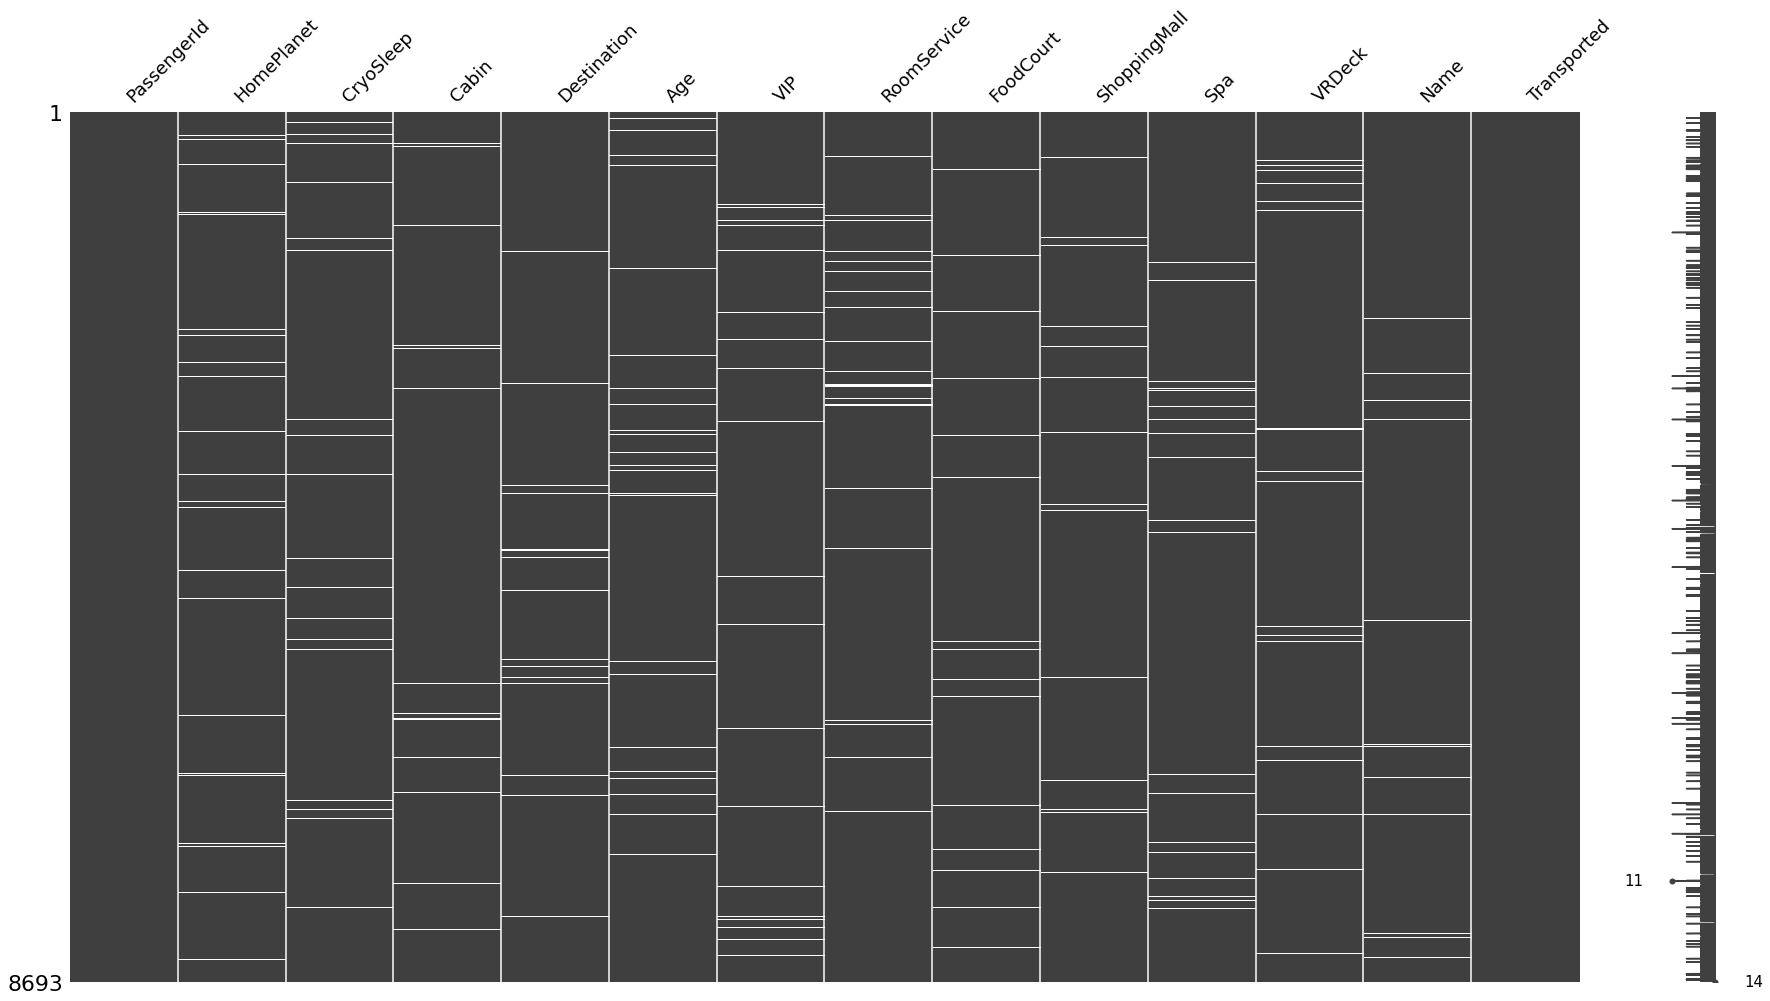

In [62]:
import missingno as msno

# Check only original columns
msno.matrix(df[original_columns],figsize=(30,16),fontsize=18); ## Visualize missing values as a matrix

#### Correlation matrix

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Full_Id                   8693 non-null   object 
 1   HomePlanet                8492 non-null   object 
 2   CryoSleep                 8476 non-null   object 
 3   Cabin                     8494 non-null   object 
 4   Destination               8511 non-null   object 
 5   Age                       8514 non-null   float64
 6   VIP                       8490 non-null   object 
 7   RoomService               8512 non-null   float64
 8   FoodCourt                 8510 non-null   float64
 9   ShoppingMall              8485 non-null   float64
 10  Spa                       8510 non-null   float64
 11  VRDeck                    8505 non-null   float64
 12  Name                      8493 non-null   object 
 13  Transported               8693 non-null   bool   
 14  GroupId 

In [64]:
# Transform some object columns to categorical or boolean
df = df.astype({'HomePlanet':'category', 'CryoSleep':'bool', 'Destination':'category', 'VIP':'bool', 'Deck':'category', 'Side':'category'})

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Full_Id                   8693 non-null   object  
 1   HomePlanet                8492 non-null   category
 2   CryoSleep                 8693 non-null   bool    
 3   Cabin                     8494 non-null   object  
 4   Destination               8511 non-null   category
 5   Age                       8514 non-null   float64 
 6   VIP                       8693 non-null   bool    
 7   RoomService               8512 non-null   float64 
 8   FoodCourt                 8510 non-null   float64 
 9   ShoppingMall              8485 non-null   float64 
 10  Spa                       8510 non-null   float64 
 11  VRDeck                    8505 non-null   float64 
 12  Name                      8493 non-null   object  
 13  Transported               8693 non-null   bool  

`RoomService_transformed`, `FoodCourt_transformed`, `ShoppingMall_transformed`, `Spa_transformed`, `VRDeck_transformed`, `Paid_RoomService`, `Paid_FoodCourt`, `Paid_ShoppingMall`, `Paid_Spa`, and `Paid_VRDeck` are artificial variables which we know will have very strong positive correlation with original ones. Therefore I will drop them together with text variables.

In [66]:
# Factorize categorical variables to build correlation matrix for initial correlation estimation, remove text variables and some of artificially created, as we know the
cols_to_drop = ['Full_Id', 'Cabin', 'Name', 'GroupId', 'PassengerId', 'Num', 'First_name', 'Last_name',
                'RoomService_transformed', 'FoodCourt_transformed', 'ShoppingMall_transformed', 'Spa_transformed', 'VRDeck_transformed',
                'Paid_RoomService', 'Paid_FoodCourt', 'Paid_ShoppingMall', 'Paid_Spa', 'Paid_VRDeck']
df_factor=df.drop(cols_to_drop, axis=1).apply(lambda x : pd.factorize(x)[0])+1

In [67]:
df_factor.describe()

HomePlanet    CryoSleep  Destination          Age          VIP  \
count  8693.000000  8693.000000  8693.000000  8693.000000  8693.000000   
mean      1.910963     1.374324     1.484758    27.390774     1.046244   
std       0.729458     0.483976     0.840148    17.653102     0.210025   
min       0.000000     1.000000     0.000000     0.000000     1.000000   
25%       1.000000     1.000000     1.000000    12.000000     1.000000   
50%       2.000000     1.000000     1.000000    28.000000     1.000000   
75%       2.000000     2.000000     2.000000    40.000000     1.000000   
max       3.000000     2.000000     3.000000    80.000000     2.000000   

       RoomService    FoodCourt  ShoppingMall          Spa       VRDeck  \
count  8693.000000  8693.000000   8693.000000  8693.000000  8693.000000   
mean    151.862878   186.099505    119.595076   157.578742   149.496261   
std     300.284143   363.294969    249.579829   308.947191   300.786490   
min       0.000000     0.000000      0.000000     0.000000     0.000000   
25%       1.000000     1.000000      1.000000     1.000000     1.000000   
50%       1.000000     1.000000      1.000000     1.000000     1.000000   
75%     127.000000   166.000000     78.000000   130.000000   123.000000   
max    1273.000000  1507.000000   1115.000000  1327.000000  1306.000000   

       Transported   Group_size  Number_of_cabinmates         Deck  \
count  8693.000000  8693.000000           8693.000000  8693.000000   
mean      1.503624     2.077304              1.829173     3.438169   
std       0.500016     1.670032              1.582496     1.809941   
min       1.000000     1.000000              0.000000     0.000000   
25%       1.000000     1.000000              1.000000     2.000000   
50%       2.000000     1.000000              1.000000     4.000000   
75%       2.000000     3.000000              2.000000     4.000000   
max       2.000000     8.000000              8.000000     8.000000   

              Side  Number_of_namesakes  
count  8693.000000          8693.000000  
mean      1.470378             5.280225  
std       0.543084             3.141570  
min       0.000000             0.000000  
25%       1.000000             3.000000  
50%       1.000000             5.000000  
75%       2.000000             7.000000  
max       2.000000            17.000000

In [68]:
df_factor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   HomePlanet            8693 non-null   int64
 1   CryoSleep             8693 non-null   int64
 2   Destination           8693 non-null   int64
 3   Age                   8693 non-null   int64
 4   VIP                   8693 non-null   int64
 5   RoomService           8693 non-null   int64
 6   FoodCourt             8693 non-null   int64
 7   ShoppingMall          8693 non-null   int64
 8   Spa                   8693 non-null   int64
 9   VRDeck                8693 non-null   int64
 10  Transported           8693 non-null   int64
 11  Group_size            8693 non-null   int64
 12  Number_of_cabinmates  8693 non-null   int64
 13  Deck                  8693 non-null   int64
 14  Side                  8693 non-null   int64
 15  Number_of_namesakes   8693 non-null   int64
dtypes: int

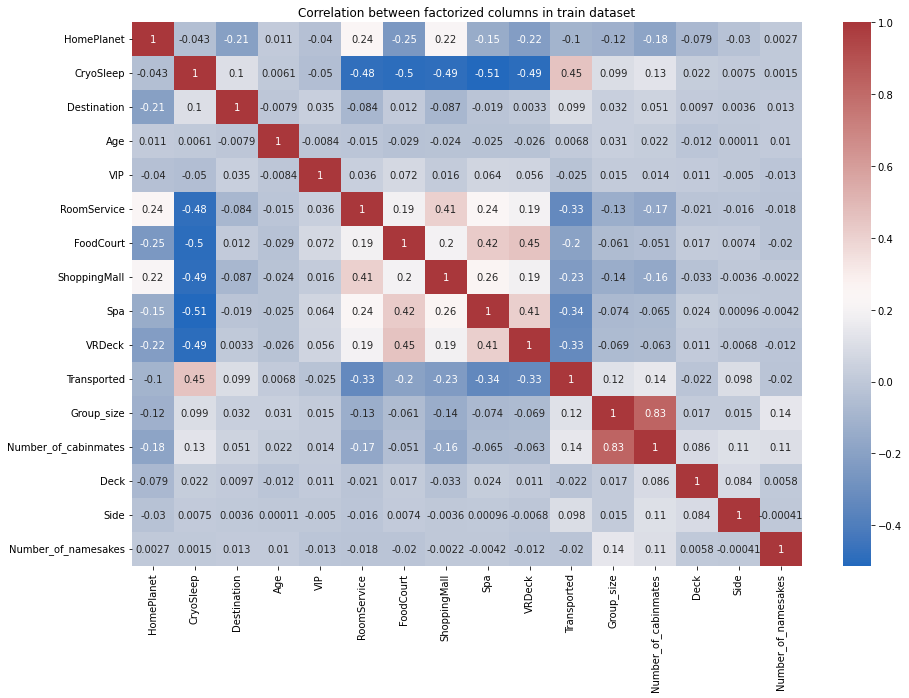

In [69]:
# Use Spearman correlation (https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)
corr = df_factor.corr(method='spearman')
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 10.0
sns.heatmap(corr, cmap = 'vlag', annot=corr)
plt.xticks(rotation=90) 
plt.title('Correlation between factorized columns in train dataset')
plt.show();
del df_factor


From the heatmap of correlation we can extract the following information:
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` columns show negative correlation with `CryoSleep` column: indeed, passengers who spent more time in cryonic sleep didn't have an opportunity to spend a lot of money in ship's facilities
- `HomePlanet` and `Destination` show some correlation. People from certain home planet may prefer some specific destination
- There is also correlation between `HomePlanet` and money spent on ship's facilities. But correlation changes its sign, so passengers from some planets prefer to spend more time on VRDeck and in Food Court, while the one from another planet likes to spend money on Room Service and in Shopping Mall. Correlation between `HomePlanet` and `Spa` relatively weaker, compare to other ship's facilities
- `Age` doesn't show any meaningful correlation with other columns, as well as `VIP` status
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` also show positive correlation with each other, which means that people who are ready to spend money on one of such a service, would also spend some amount on another. We can see, that `RoomService` has stronger correlation with `ShoppingMall`, while `FoodCourt` correlates stronger with `Spa` and `VRDeck`
- `Group_size` have some weak negative correlation with `RoomService` and `ShoppingMall`, large groups spend less money on such services
- `Group_size` is strongly correlated with `Number_of_cabinmates`, most of the groups travelled in the cabin together and most of cabinmates are from the same group. Correlation with `Number_of_namesakes` is much weaker, but also positive
- `Deck` and deck `Side` don't show any significant correlation with another columns
- `Transported` is a column which has to be predicted. Based on test data, we can see that it has positive correlation with `CryoSleep`, negative correlation with ship's facility (as was mentioned above, they are correlated with `CryoSleep` as well) and weak positive correlation with `Group_size`


#### Home Planet

Let's check, how Home planet related with other columns

In [70]:
# Define helper functions for plotting

from statsmodels.graphics.mosaicplot import mosaic

def plot_mosaic(columns, df=df, bool_strings=(False, False)):
    plt.rcParams['font.size'] = 16.0
    plt.rcParams['figure.figsize'] = (10,7)
    if bool_strings[0] and bool_strings[1]:
        lab = lambda k: len(df[(df[columns[0]] == bool(k[0]=='True')) & (df[columns[1]] == bool(k[1]=='True'))])
    elif bool_strings[0] and not bool_strings[1]:
        lab = lambda k: len(df[(df[columns[0]] ==bool(k[0]=='True')) & (df[columns[1]] ==k[1])])
    elif not bool_strings[0] and bool_strings[1]:
        lab = lambda k: len(df[(df[columns[0]] == k[0]) & (df[columns[1]] == bool(k[1]=='True'))])
    else:
        lab = lambda k: len(df[(df[columns[0]] == k[0]) & (df[columns[1]] == k[1])])
    mosaic(df, [columns[0], columns[1]], labelizer=lab, title=f'Mosaic plot of {columns[0]}(x-axis) vs. {columns[1]}(y-axis)');

def group_displot(columns, df=df, log_scales=(False, False)):
    if log_scales[0]:
        df[columns[0]] = df[columns[0]] + 1   # To avoid error on log_scale
    g = sns.displot(df, x=columns[0], kde=True, bins=80, color = 'royalblue', height=4.75, aspect=1.83, hue=columns[1], multiple="stack", log_scale=log_scales)
    if log_scales[0]:
        df[columns[0]] = df[columns[0]] - 1   # Restore values
    g.set_axis_labels(f"{columns[0]}", "Number of passengers")
    g.fig.suptitle(f"{columns[0]} distribution by {columns[1]}");

##### Home Planet vs. CryoSleep

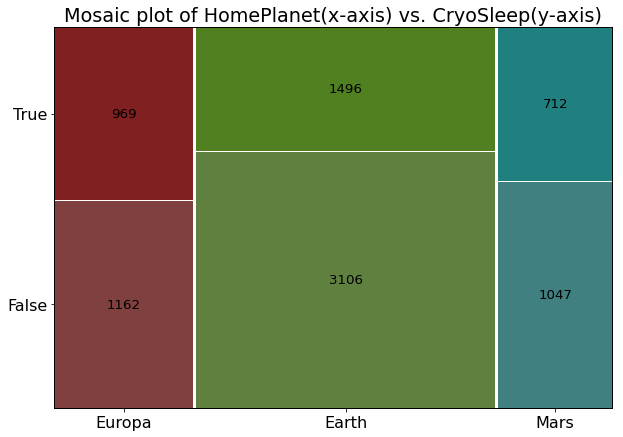

In [71]:
plot_mosaic(('HomePlanet', 'CryoSleep'), bool_strings=(False, True))

From mosaic plot, we see, that significantly less people from Earth (about 30%) were elected for cryonic sleep, while about 45% travellers from Europa and about 740% from Mars were elected for cryonic sleep and were confined in their cabines 

##### Home Planet vs. Destination

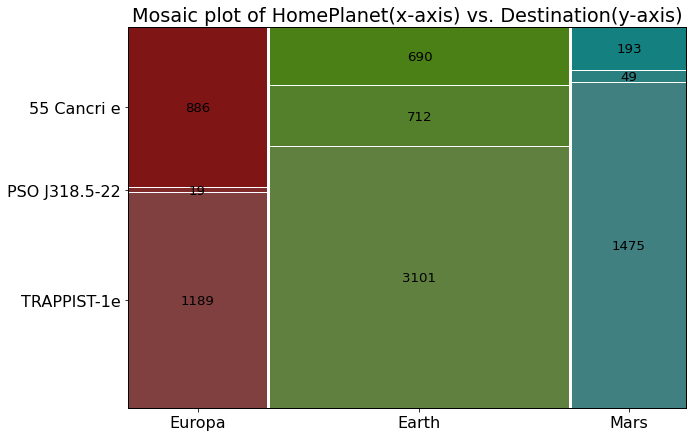

In [72]:
plot_mosaic(('HomePlanet', 'Destination'))

Almost half of travellers from Europa were going to 55 Cancri e, and almost nobody to PSO J318.5-22. Travellers from Mars also don't prefer PSO J318.5-22, but they also avoid 55 Cancri e. Travelers from Earth were mostly directed to TRAPPIST-1e, but 1/4 of them were, with almost equally proportion, travelling to other two possible destinations

##### HomePlanet vs. Age

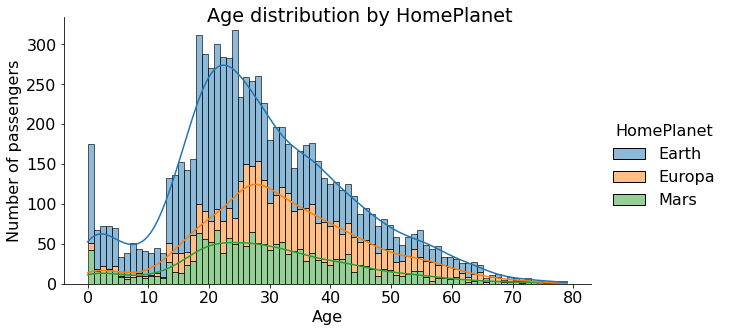

In [73]:
group_displot(('Age', 'HomePlanet'))

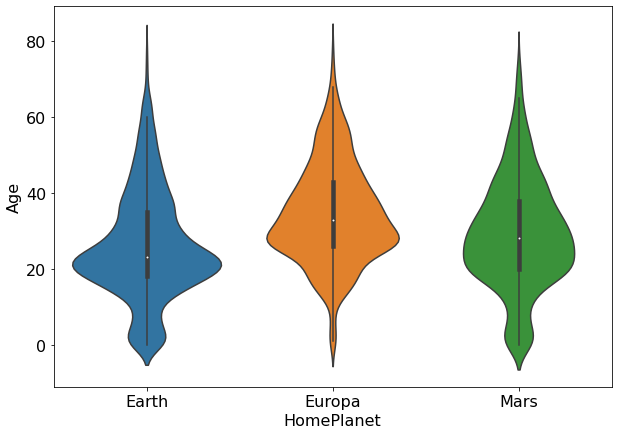

In [74]:
ax = sns.violinplot(x='HomePlanet', y='Age', data=df)

From plots we can see, that from Europa only few passengers (compare to other home planets) younger than 13 years old. Also, travellers from Earth are younger in avarege, than from other planets. Europa has the oldest in average travellers.

##### HomePlanet vs. VIP

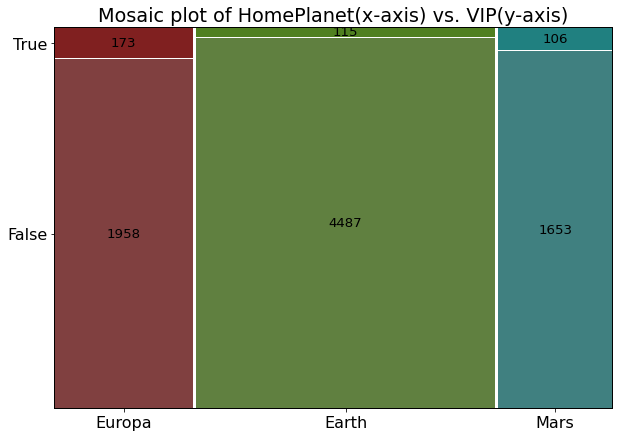

In [75]:
plot_mosaic(('HomePlanet', 'VIP'), bool_strings=(False, True))

Only small part (about 2.5%) of Earth travellers bought VIP service, compare to Europa (about 9%) and Mars (about 6.5%)

##### HomePlanet vs. RoomService

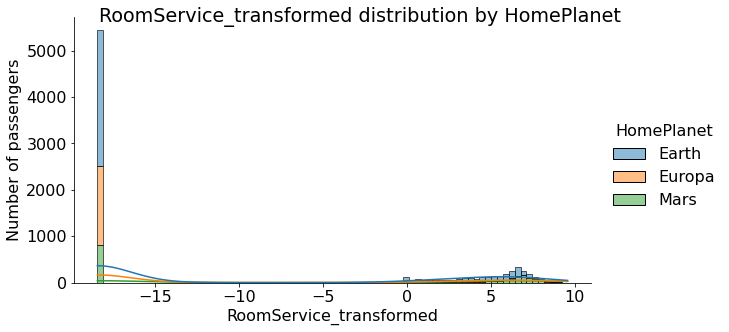

In [76]:
group_displot(('RoomService_transformed', 'HomePlanet'))

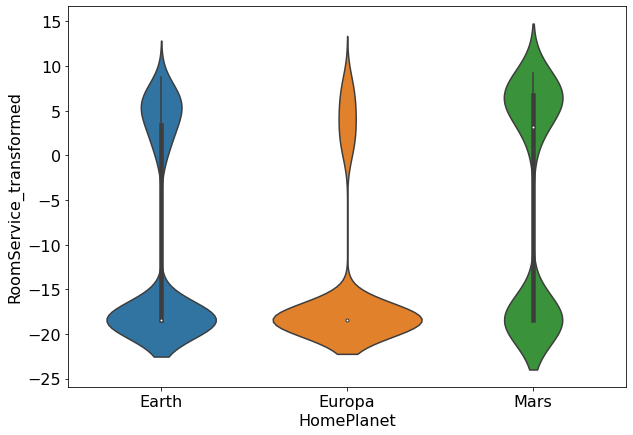

In [77]:
ax = sns.violinplot(x='HomePlanet', y='RoomService_transformed', data=df)

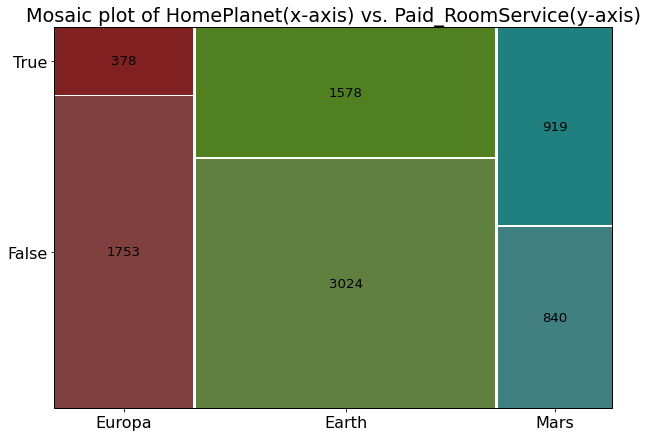

In [78]:
plot_mosaic(('HomePlanet', 'Paid_RoomService'), bool_strings=(False, True))

From plots we can see, that passengers from Earth and Europa moslty didn't spend money on Room service. Individual travellers from Europa and Mars spent much more.

##### HomePlanet vs. FoodCourt

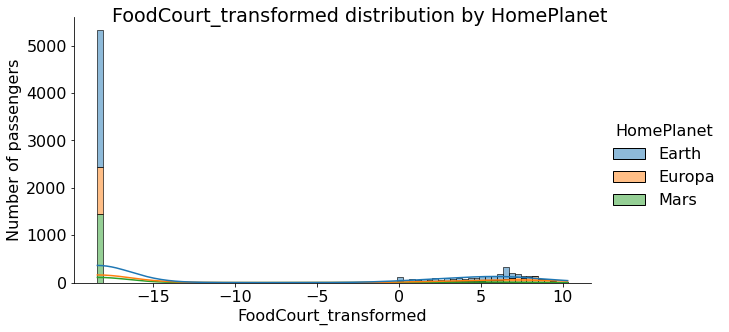

In [79]:
group_displot(('FoodCourt_transformed', 'HomePlanet'))

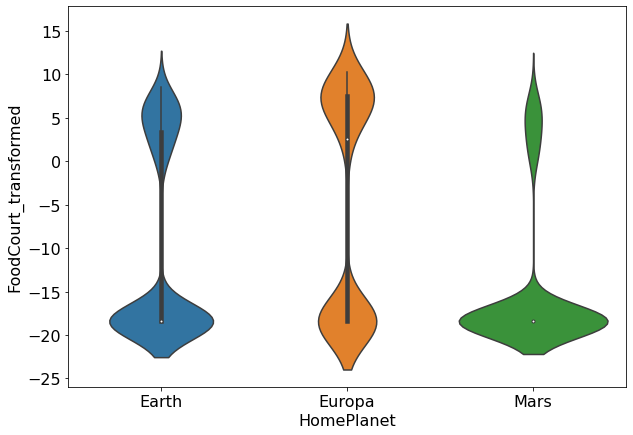

In [80]:
ax = sns.violinplot(x='HomePlanet', y='FoodCourt_transformed', data=df)

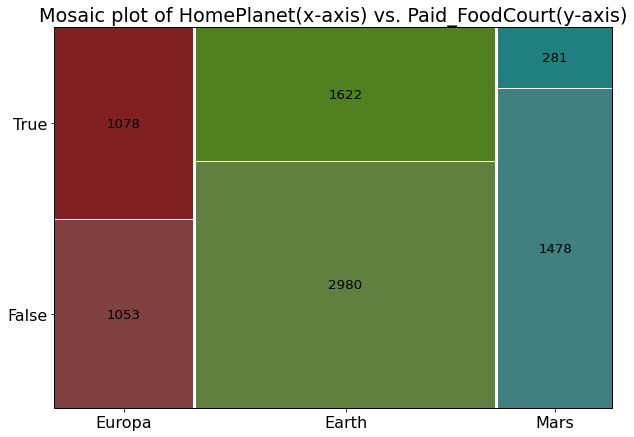

In [81]:
plot_mosaic(('HomePlanet', 'Paid_FoodCourt'), bool_strings=(False, True))

From plots we can see, that most of the passengers from Earth and Mars and about half passengers from Europa didn't spend money on Room service. Individual travellers from Europa and Earth spent huge amount.

##### HomePlanet vs. ShoppingMall

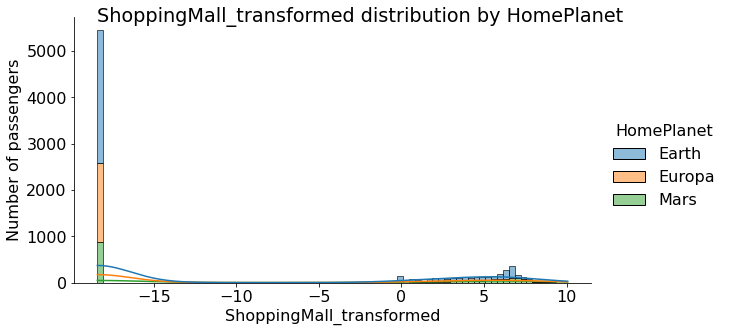

In [82]:
group_displot(('ShoppingMall_transformed', 'HomePlanet'))

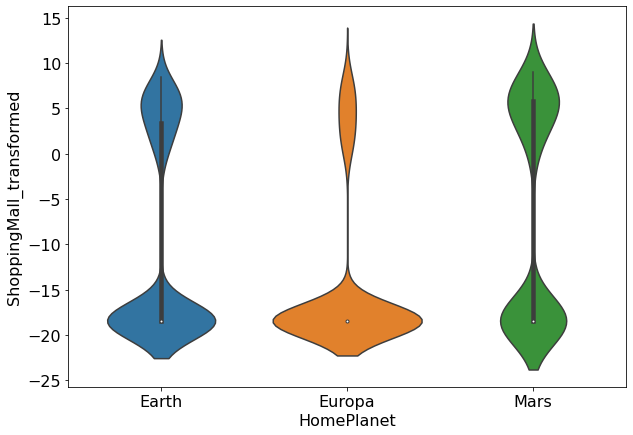

In [83]:
ax = sns.violinplot(x='HomePlanet', y='ShoppingMall_transformed', data=df)

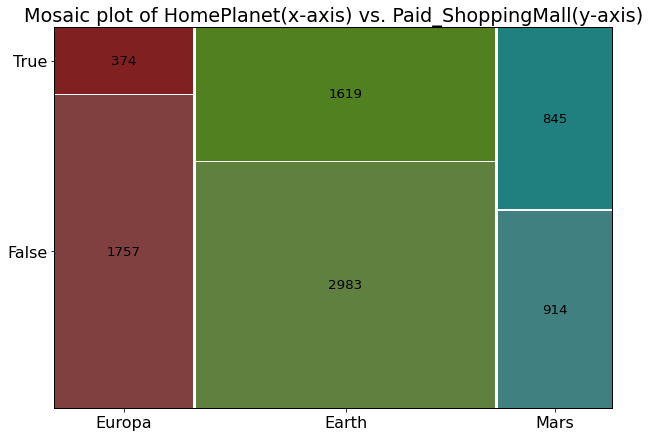

In [84]:
plot_mosaic(('HomePlanet', 'Paid_ShoppingMall'), bool_strings=(False, True))

From plots we can see, that most of the passengers from Earth and Europa and about half passengers from Mars didn't spend money in Shopping Mall. Individual travellers from Earth and Mars spent large amount.

##### HomePlanet vs. Spa

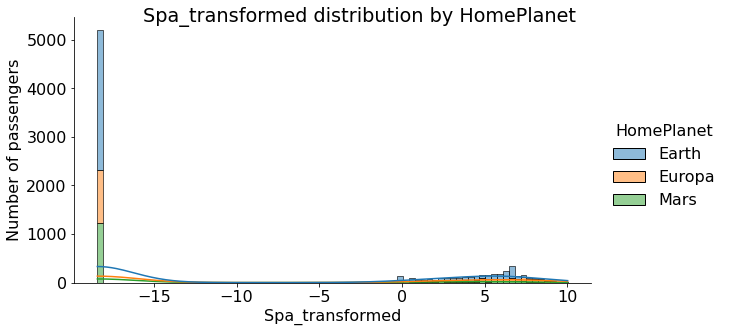

In [85]:
group_displot(('Spa_transformed', 'HomePlanet'))

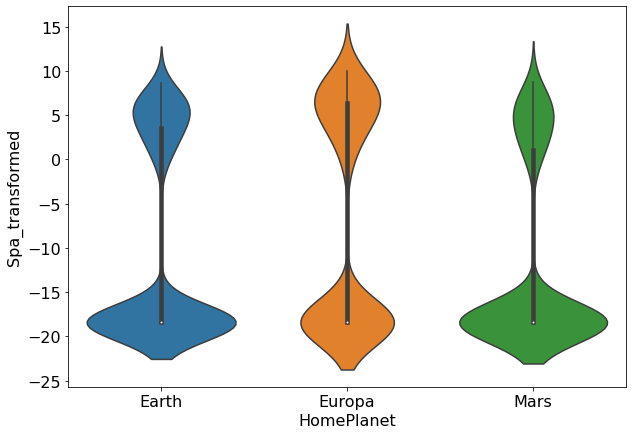

In [86]:
ax = sns.violinplot(x='HomePlanet', y='Spa_transformed', data=df)

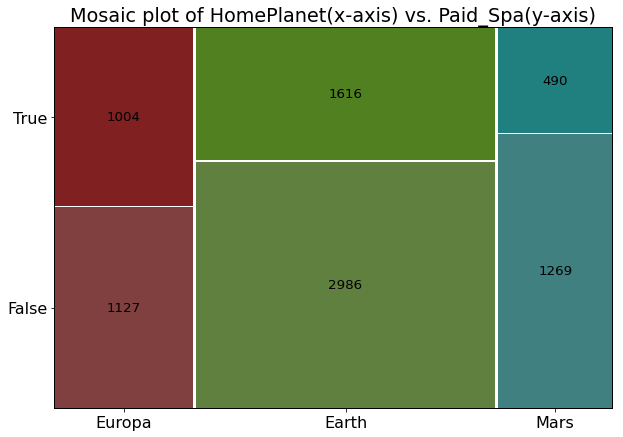

In [87]:
plot_mosaic(('HomePlanet', 'Paid_Spa'), bool_strings=(False, True))

From plots we can see, that passengers from Earth and Mars moslty didn't spend money for Spa, while for passengers from Europa it is almost half

##### HomePlanet vs. VRDeck

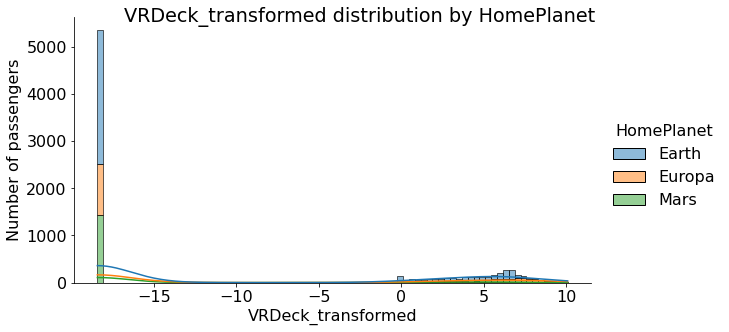

In [88]:
group_displot(('VRDeck_transformed', 'HomePlanet'))

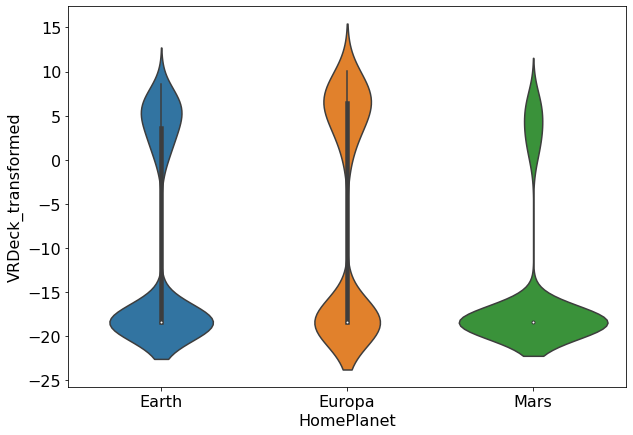

In [89]:
ax = sns.violinplot(x='HomePlanet', y='VRDeck_transformed', data=df)

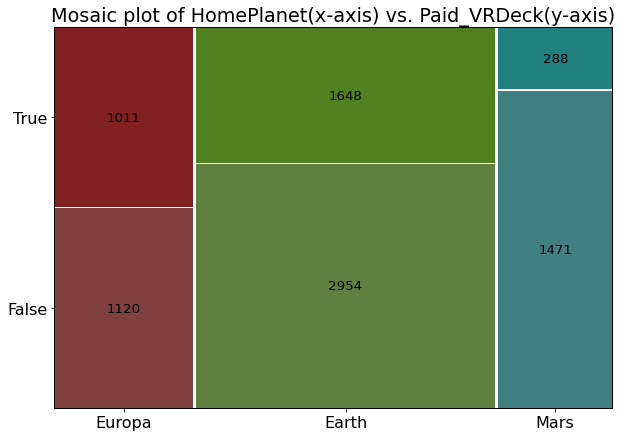

In [90]:
plot_mosaic(('HomePlanet', 'Paid_VRDeck'), bool_strings=(False, True))

From plots we can see, that while passengers from Earth and especially from Mars moslty didn't spend money for VRDeck, some travellers from Earth and Europa spent huge amount.

Observations are similar for all five spaceship facilities: Most of all passengers didn't spend money on them, but some individuals, especially from Europe, as we can conclude from plots, spent a lot for the facilities.

##### HomePlanet vs. GroupSize

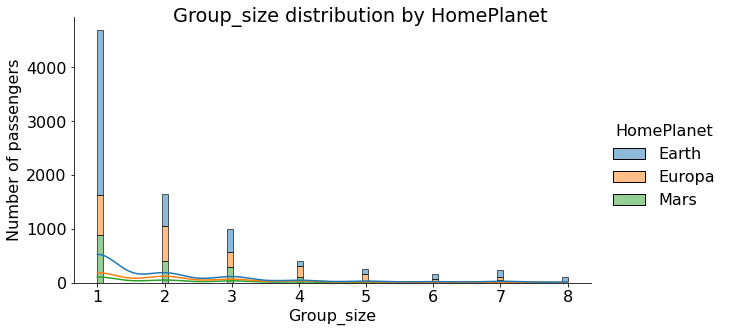

In [91]:
group_displot(('Group_size', 'HomePlanet'))

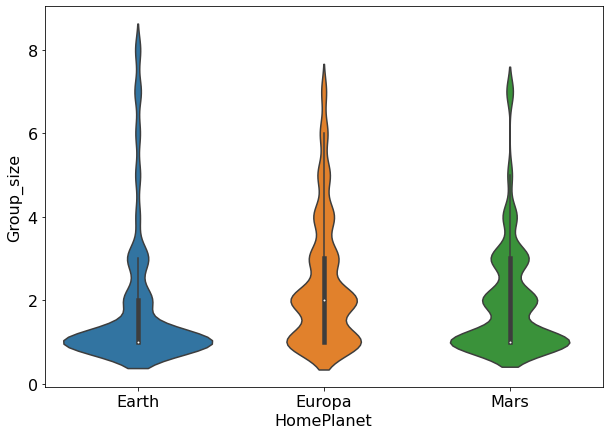

In [92]:
ax = sns.violinplot(x='HomePlanet', y='Group_size', data=df)

We can see, that much more individual travellers from the Earth and large groups (>6 persons) are also mostly from Earth. 

##### Home Planet vs. Deck

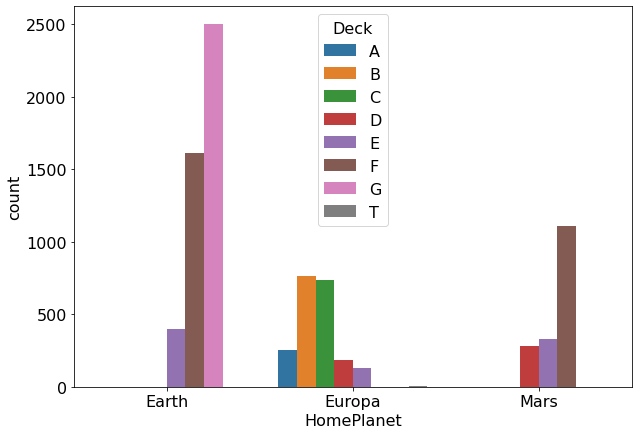

In [93]:
# Mosaic plot is not easy to read when many categories
sns.countplot(data=df, x="HomePlanet", hue="Deck");

From bar plot, we see, that decks A, B and C are occupied only by Europa passengers. Deck D is shared between Europeans and Marsians (slightly more Marsians). Deck E is shared among travellers from all planets (slightly less Europeans). Deck F is occupied by Terrenians and some less, but still significant number of Marsians. On the deck G, only Terrenians can be found and 4 Europeans have cabins on deck T.

##### HomePlanet vs. Side

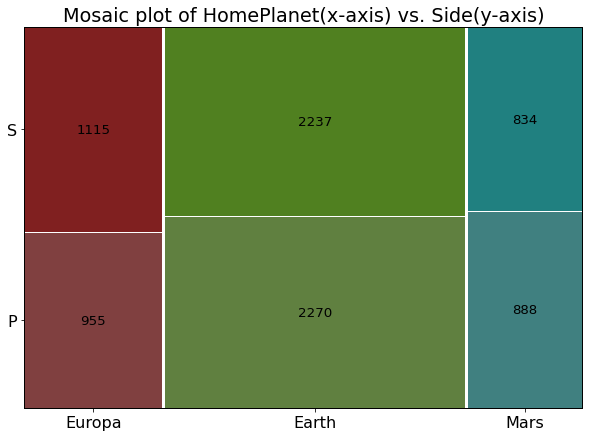

In [94]:
plot_mosaic(('HomePlanet', 'Side'))

While passengers from Earth and Mars were approximately equaly distributed between decks sides, travellers from Europe have prevalence on S side

#### CryoSleep

##### CryoSleep vs. Destination

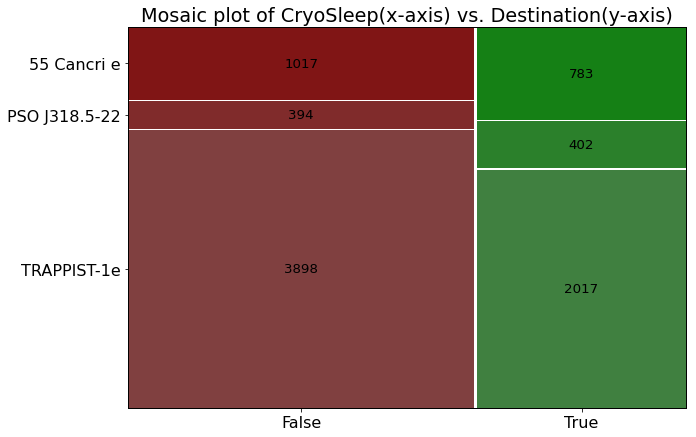

In [95]:
plot_mosaic(('CryoSleep', 'Destination'), bool_strings=(True, False))

More than half of the passengers who were elected for Cryonic Sleep were travelling to 55 Cancri e and PSOJ318.5-22 (another half to TRAPPIST-1e). Among passengers who were not in cryonic sleep, about 75% were travelling to TRAPPIST-1e.

##### CryoSleep vs. Age

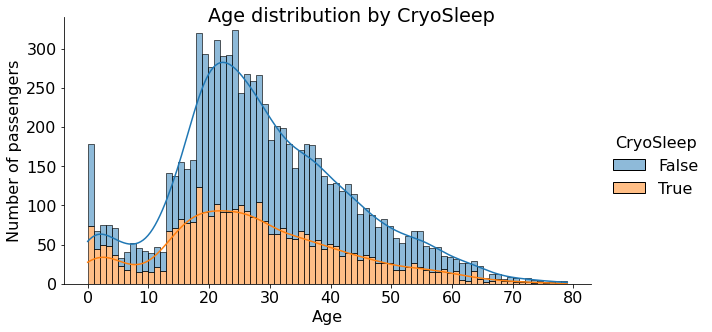

In [96]:
group_displot(('Age', 'CryoSleep'))

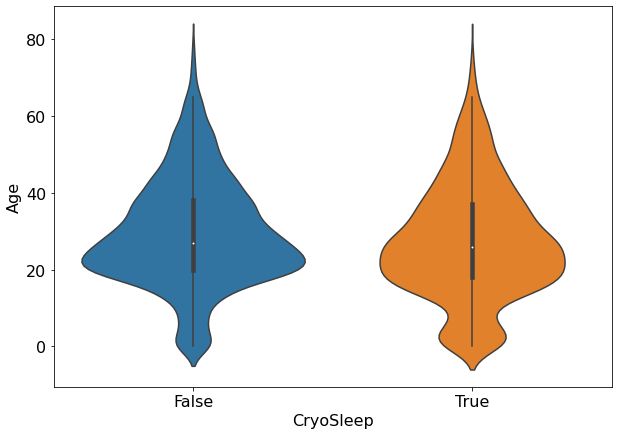

In [97]:
ax = sns.violinplot(x='CryoSleep', y='Age', data=df)

From plots we can see, that from among the CryoSleep passengers more children, but less adults 

##### CryoSleep vs. VIP

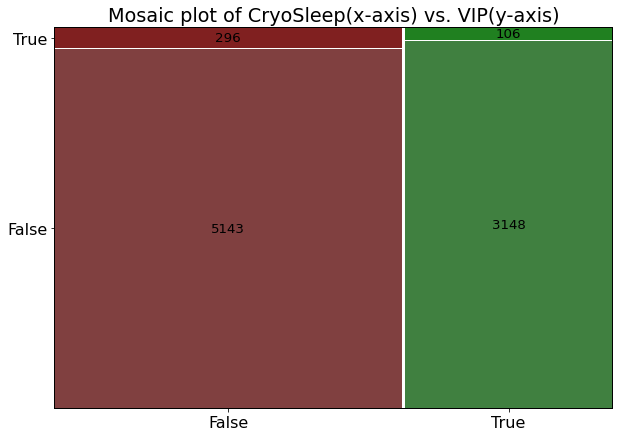

In [98]:
plot_mosaic(('CryoSleep', 'VIP'), bool_strings=(True, True))

About 3% of CryoSleep passengers also had VIP status and among non-CryoSeepers VIP had about 6%.

##### CryoSleep vs. RoomService

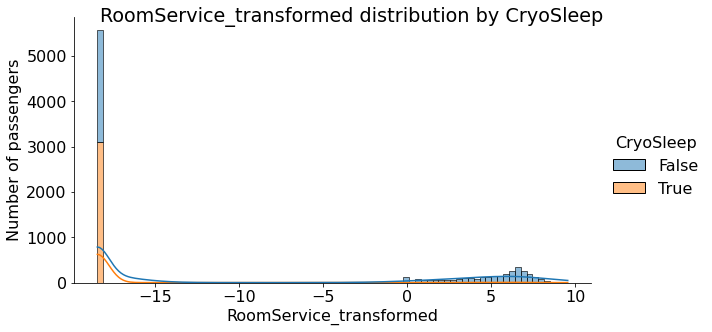

In [99]:
group_displot(('RoomService_transformed', 'CryoSleep'))

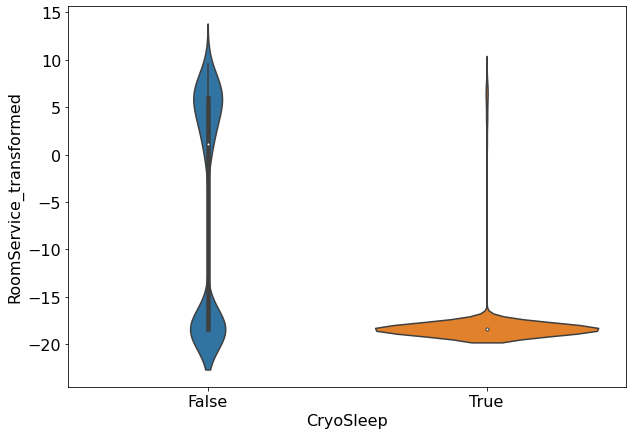

In [100]:
ax = sns.violinplot(x='CryoSleep', y='RoomService_transformed', data=df)

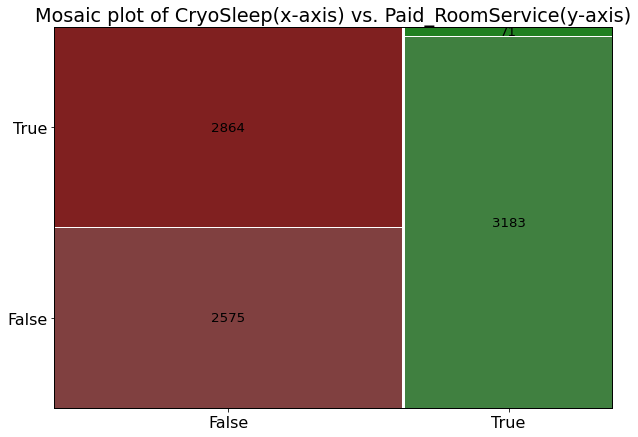

In [101]:
plot_mosaic(('CryoSleep', 'Paid_RoomService'), bool_strings=(True, True))

From plots we can see, that `CryoSleep` passengers mostly didn't spend money for `RoomService`

##### CryoSleep vs. FoodCourt

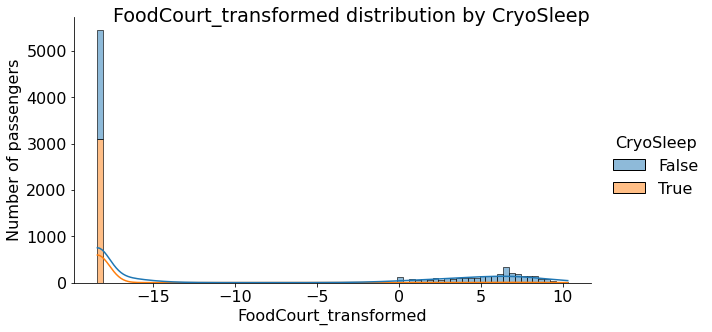

In [102]:
group_displot(('FoodCourt_transformed', 'CryoSleep'))

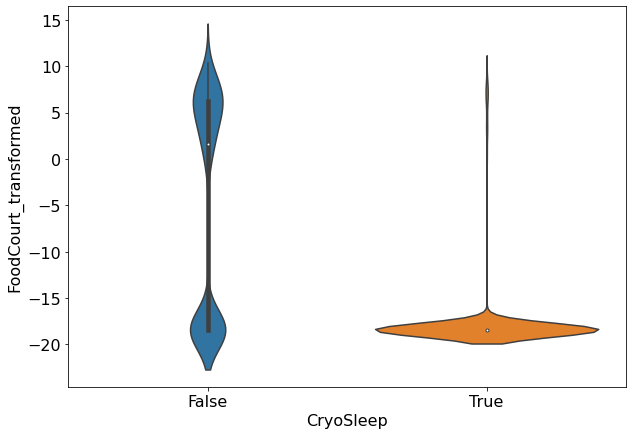

In [103]:
ax = sns.violinplot(x='CryoSleep', y='FoodCourt_transformed', data=df)

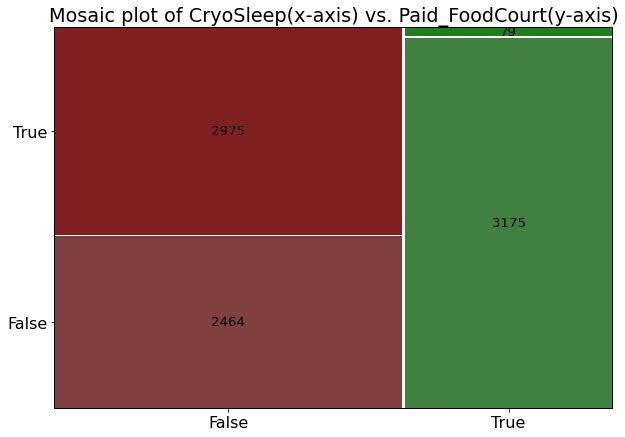

In [104]:
plot_mosaic(('CryoSleep', 'Paid_FoodCourt'), bool_strings=(True, True))

##### CryoSleep vs. ShoppingMall

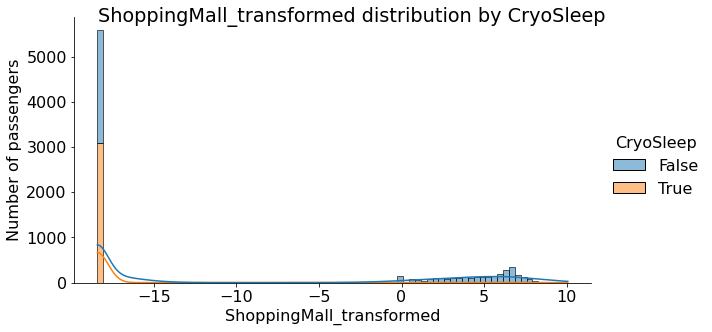

In [105]:
group_displot(('ShoppingMall_transformed', 'CryoSleep'))

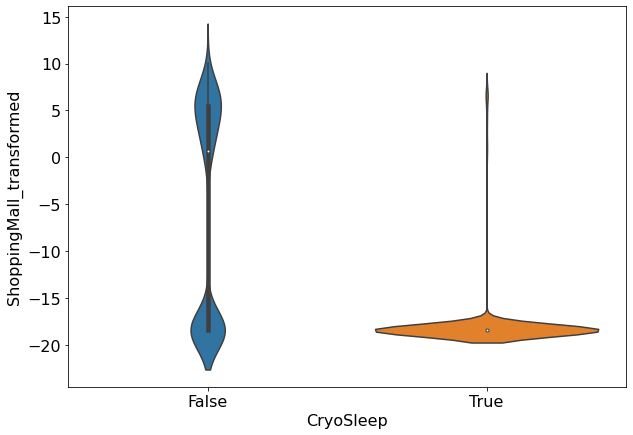

In [106]:
ax = sns.violinplot(x='CryoSleep', y='ShoppingMall_transformed', data=df)

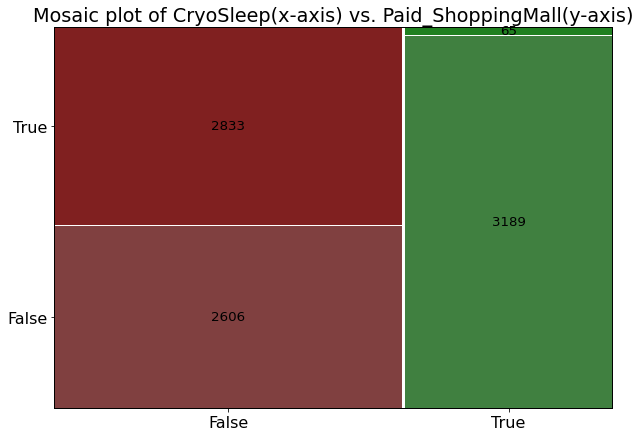

In [107]:
plot_mosaic(('CryoSleep', 'Paid_ShoppingMall'), bool_strings=(True, True))

##### CryoSleep vs. Spa

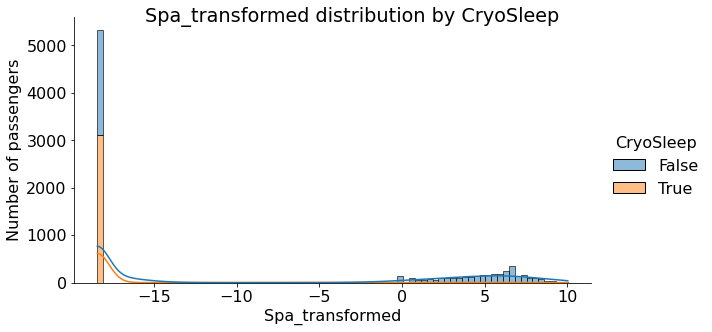

In [108]:
group_displot(('Spa_transformed', 'CryoSleep'))

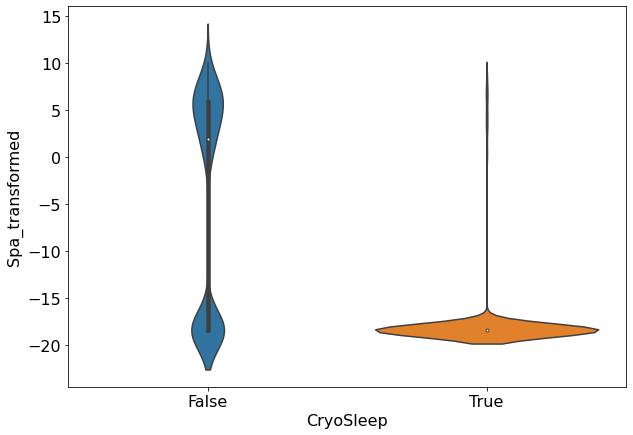

In [109]:
ax = sns.violinplot(x='CryoSleep', y='Spa_transformed', data=df)

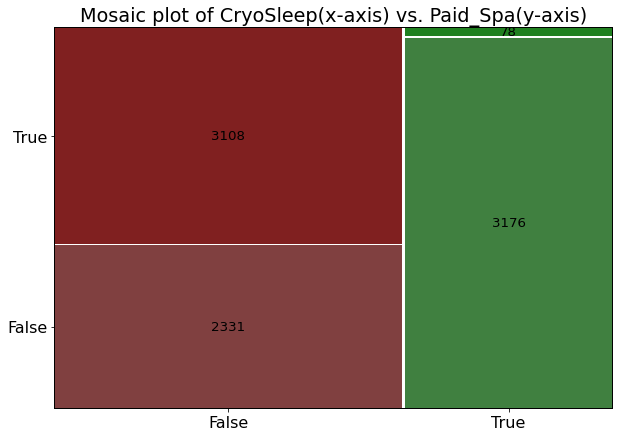

In [110]:
plot_mosaic(('CryoSleep', 'Paid_Spa'), bool_strings=(True, True))

##### CryoSleep vs. VRDeck

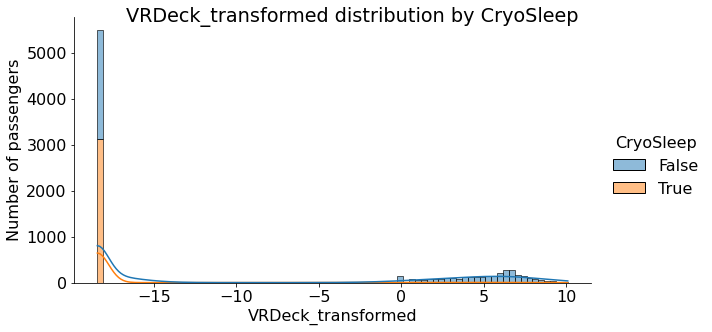

In [111]:
group_displot(('VRDeck_transformed', 'CryoSleep'))

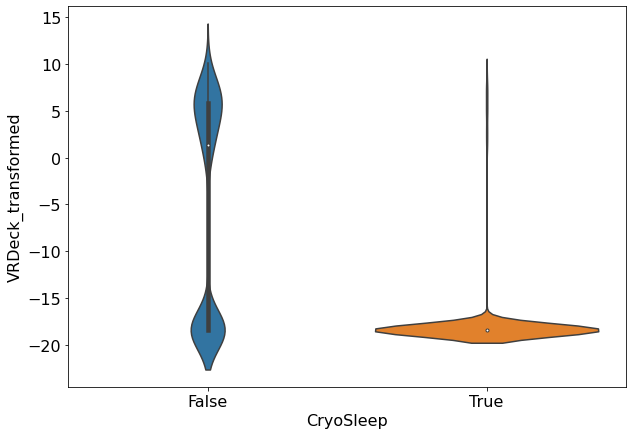

In [112]:
ax = sns.violinplot(x='CryoSleep', y='VRDeck_transformed', data=df)

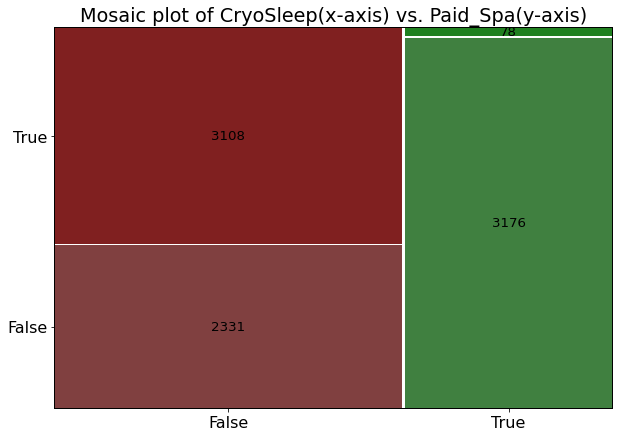

In [113]:
plot_mosaic(('CryoSleep', 'Paid_Spa'), bool_strings=(True, True))

Observations are similar for all five spaceship facilities: passengers who spent journey confined in their cabins during Cryonic Sleep didn't spend money on additional entertaiments or facilities

##### CryoSleep vs. GroupSize

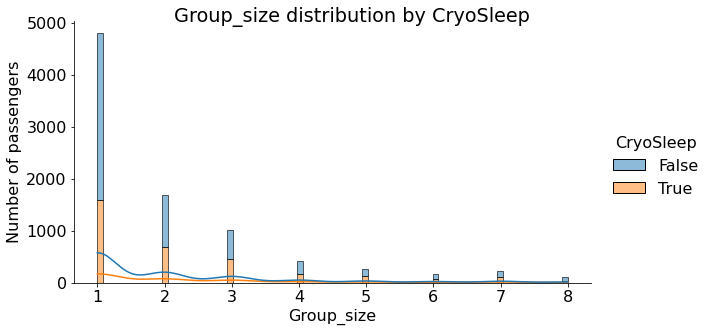

In [114]:
group_displot(('Group_size', 'CryoSleep'))

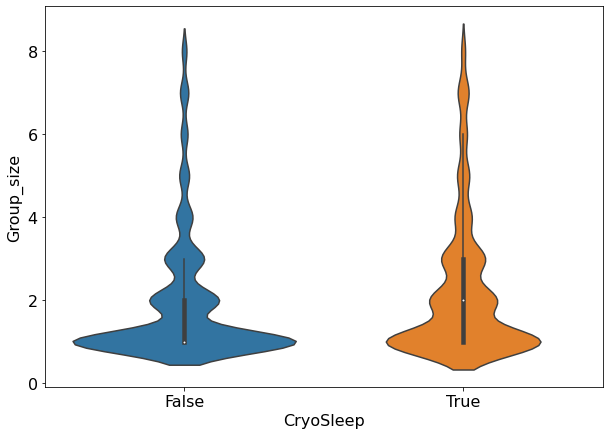

In [115]:
ax = sns.violinplot(x='CryoSleep', y='Group_size', data=df)

We can see, that more individual travellers were not elected for CryoSleep, while in groups of 2, 3, 4 or 5 person proportion between CryoSleep and non-CryoSleep passengers are about the same 

##### CryoSleep vs. Deck

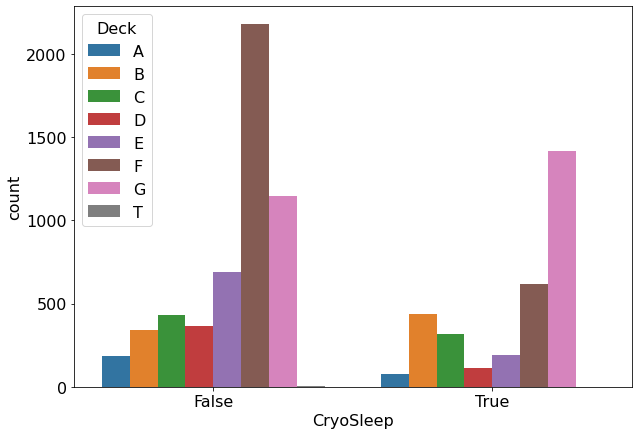

In [116]:
# Mosaic plot is not easy to read when many categories
sns.countplot(data=df, x="CryoSleep", hue="Deck");

From bar plot, we see, that majority of the passengers from decks A, C, D, E and especially F had not been elected for CryoSleep, while on decks B, and G majority of passengers spent the journey in Cryonic Sleep. Nobody from deck T were not in CryoSLeep.

##### CryoSleep vs. Side

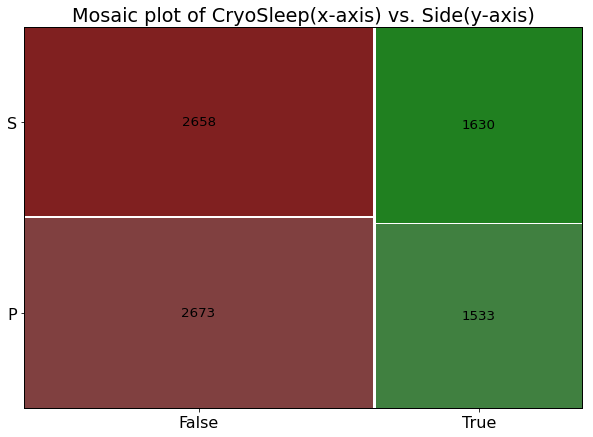

In [117]:
plot_mosaic(('CryoSleep', 'Side'), bool_strings=(True, False))

There is no visible correlation between `CryoSleep` and `Side` of the deck. CryoSleep and non-CryoSleep passengers were approximately evenly distributed between deck sides

#### Destination

##### Destination vs. Age

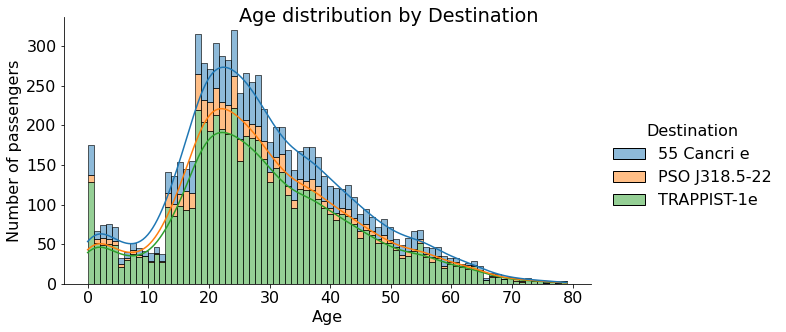

In [118]:
group_displot(('Age', 'Destination'))

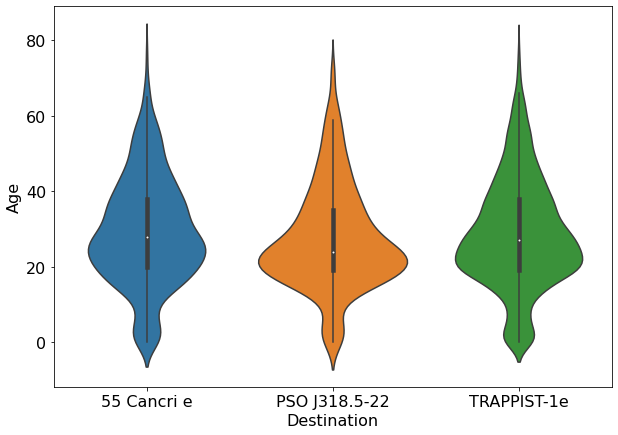

In [119]:
ax = sns.violinplot(x='Destination', y='Age', data=df)

From plots we can see, that almost no children 10-15 years old among the passengers travelled to PSO J318.5-22, and also passengers >35 years old didn't prefer this planet as their destination.

##### Destination vs. VIP

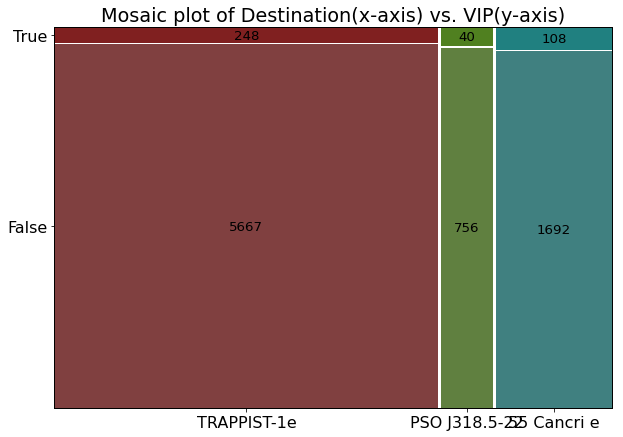

In [120]:
plot_mosaic(('Destination', 'VIP'), bool_strings=(False, True))

About 4% of travellers to TRAPPIST-1e had VIP status, 5% of travellers to PSO J318.5-22 and 6% of travellers to 55 Cancri e

##### Destination vs. RoomService

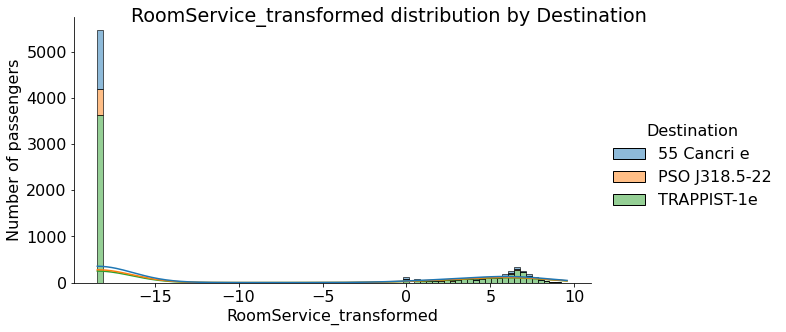

In [121]:
group_displot(('RoomService_transformed', 'Destination'))

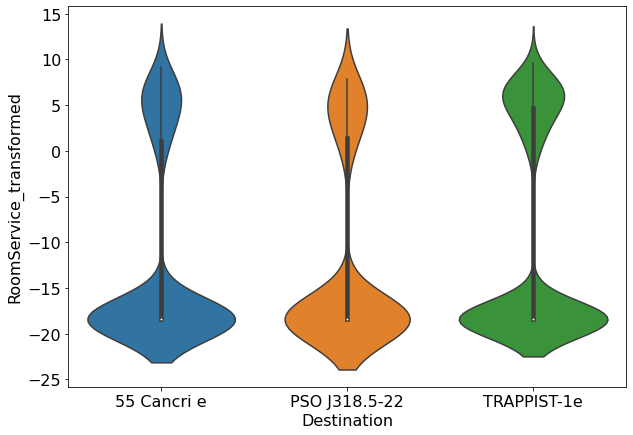

In [122]:
ax = sns.violinplot(x='Destination', y='RoomService_transformed', data=df)

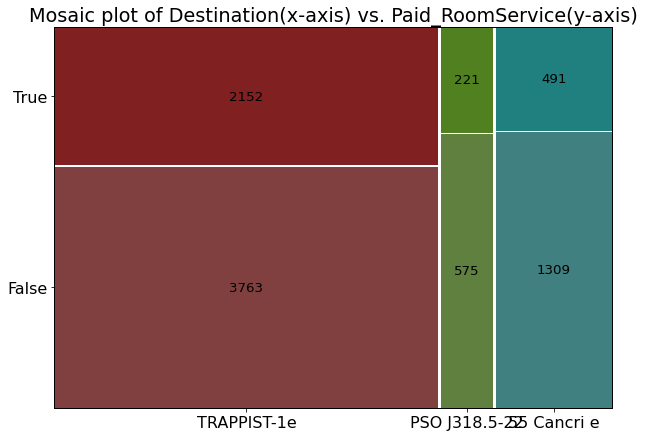

In [123]:
plot_mosaic(('Destination', 'Paid_RoomService'), bool_strings=(False, True))

From plots we can see, that about 1/3 of the passengers to PSO J318.5-22 and 55 Cancri e didn't spend money for `RoomService`. The largest bills received got some passengers to TRAPPIST-1e

##### Destination vs. FoodCourt

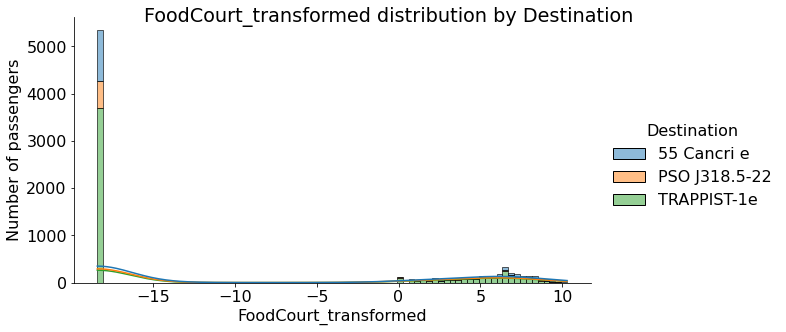

In [124]:
group_displot(('FoodCourt_transformed', 'Destination'))

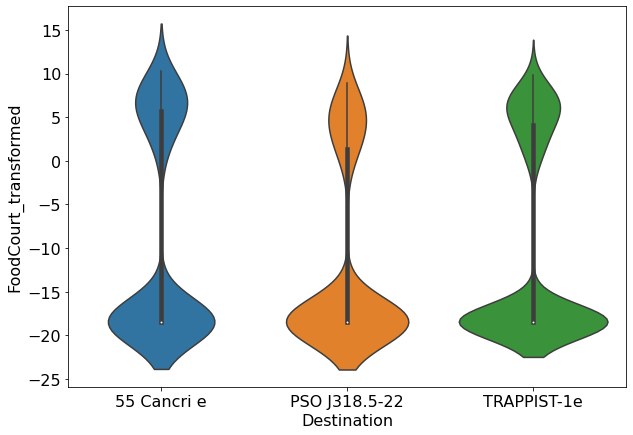

In [125]:
ax = sns.violinplot(x='Destination', y='FoodCourt_transformed', data=df)

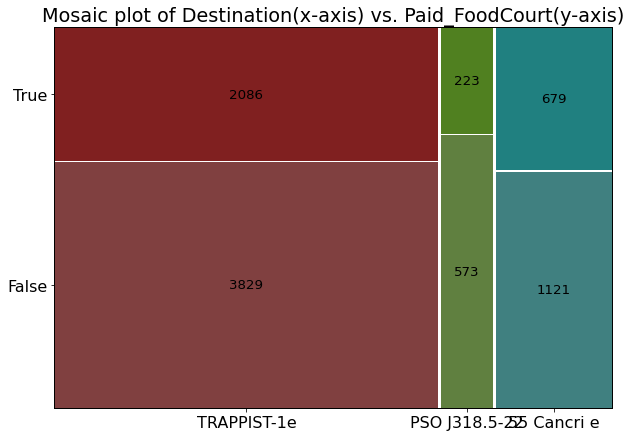

In [126]:
plot_mosaic(('Destination', 'Paid_FoodCourt'), bool_strings=(False, True))

From plots we can see, that passengers to PSO J318.5-22 mostly didn't spend money for `FoodCourt`.

##### Destination vs. ShoppingMall

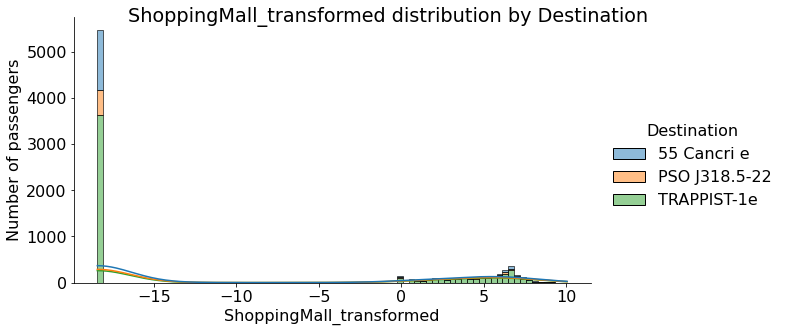

In [127]:
group_displot(('ShoppingMall_transformed', 'Destination'))

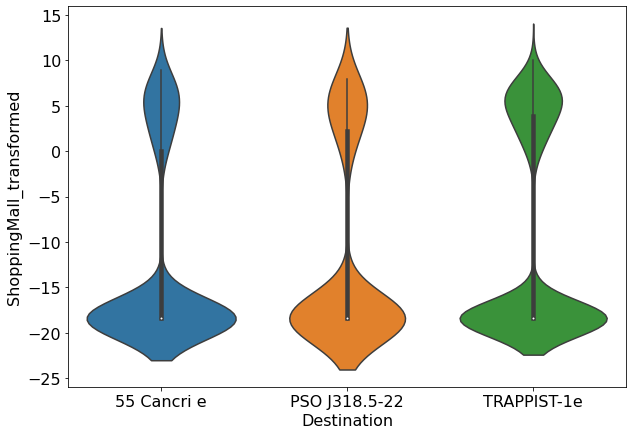

In [128]:
ax = sns.violinplot(x='Destination', y='ShoppingMall_transformed', data=df)

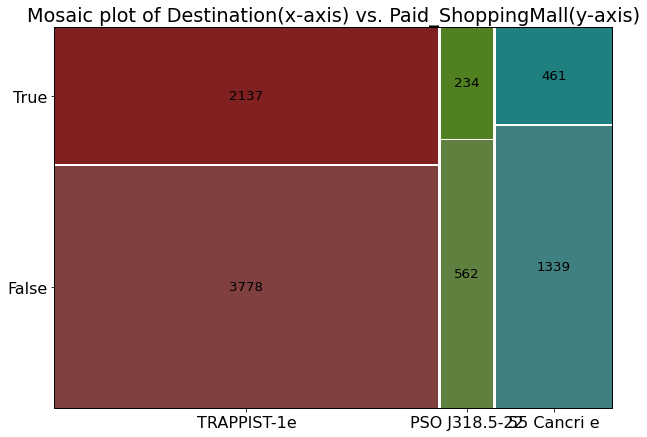

In [129]:
plot_mosaic(('Destination', 'Paid_ShoppingMall'), bool_strings=(False, True))

From plots we can see, that passengers to all destinations mostly didn't spend money for `ShoppingMall`, but the largest bill got some passengers to TRAPPIST-1e

##### Destination vs. Spa

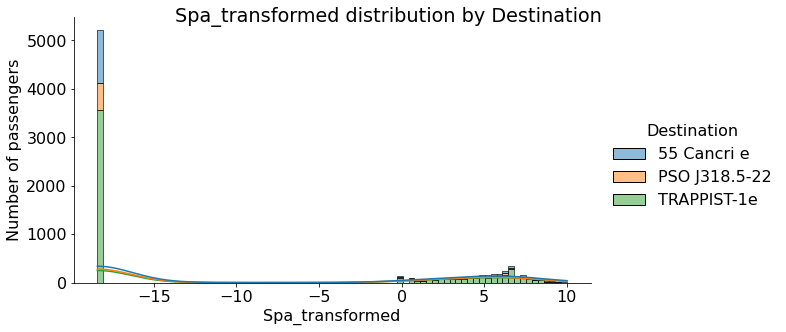

In [130]:
group_displot(('Spa_transformed', 'Destination'))

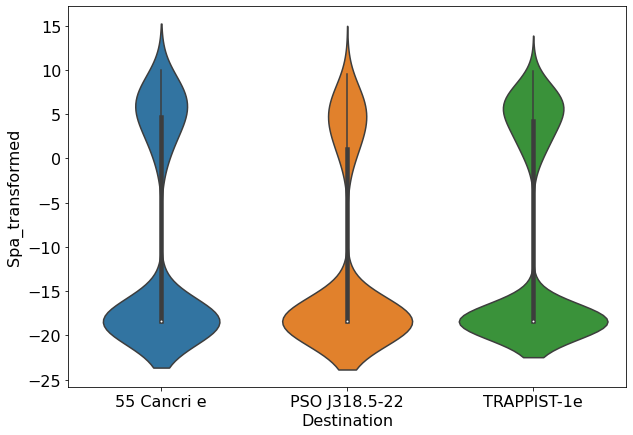

In [131]:
ax = sns.violinplot(x='Destination', y='Spa_transformed', data=df)

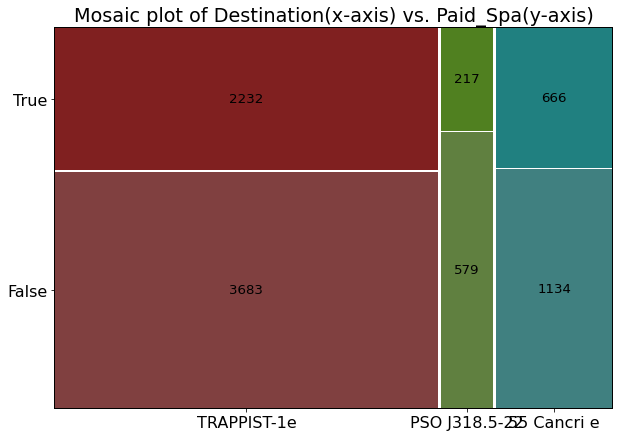

In [132]:
plot_mosaic(('Destination', 'Paid_Spa'), bool_strings=(False, True))

From plots we can see, that passengers to PSO J318.5-22 mostly didn't spend money for `Spa`, but it is not very different from another destination planets 

##### Destination vs. VRDeck

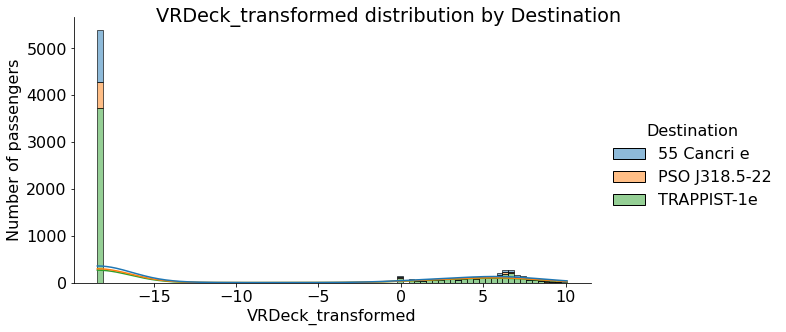

In [133]:
group_displot(('VRDeck_transformed', 'Destination'))

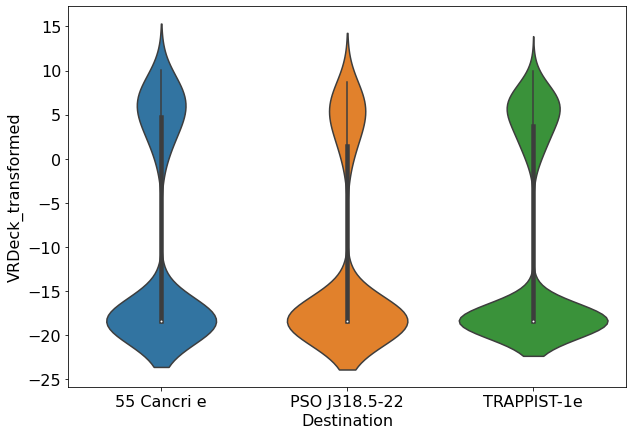

In [134]:
ax = sns.violinplot(x='Destination', y='VRDeck_transformed', data=df)

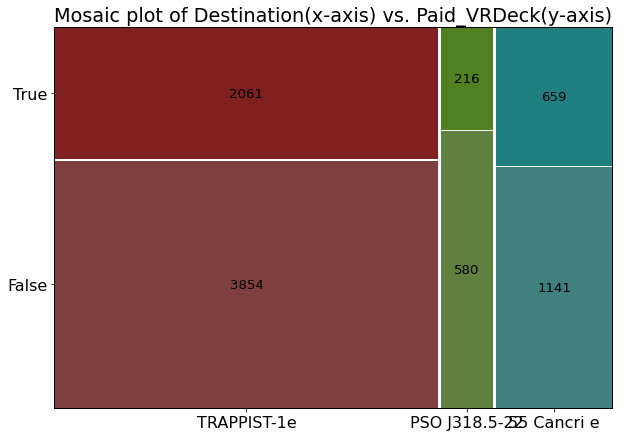

In [135]:
plot_mosaic(('Destination', 'Paid_VRDeck'), bool_strings=(False, True))

Observations is just similar to other additional services distributions

##### Destination vs. GroupSize

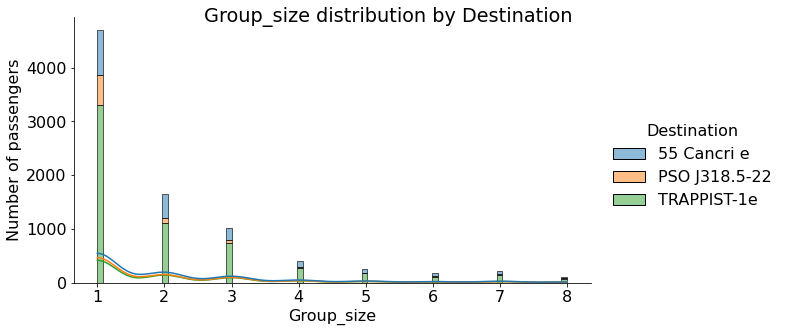

In [136]:
group_displot(('Group_size', 'Destination'))

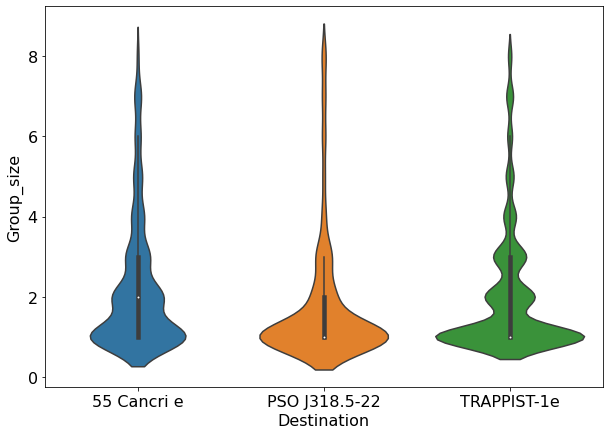

In [137]:
ax = sns.violinplot(x='Destination', y='Group_size', data=df)

We can see, that more individual travellers travelled to TRAPPIST-1e and almost no groups (and especially large groups) to PS J318.5-22

##### CryoSleep vs. Deck

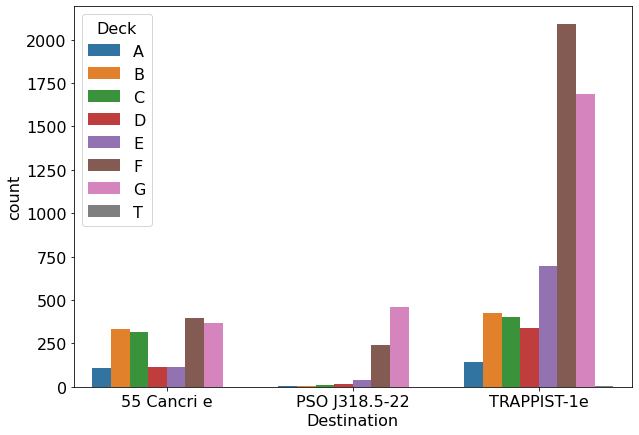

In [138]:
# Mosaic plot is not easy to read when many categories
sns.countplot(data=df, x="Destination", hue="Deck");

From bar plot, we see, that majority of the passengers from decks A, B and C were approximately equally shared between passengers to 55 Cancri e and TRAPPIST-1e. Decks D and E are also shared between the same destinations, but with prevalence to TRAPPIST-1e travellers. Decks F and G are mostly occupied by TRAPPIST-1e travellers, but not completely, many travelers to other planets also have cabins on these decks. A few passengers from deck T were travelling to TRAPPIST-1e.

##### Destination vs. Side

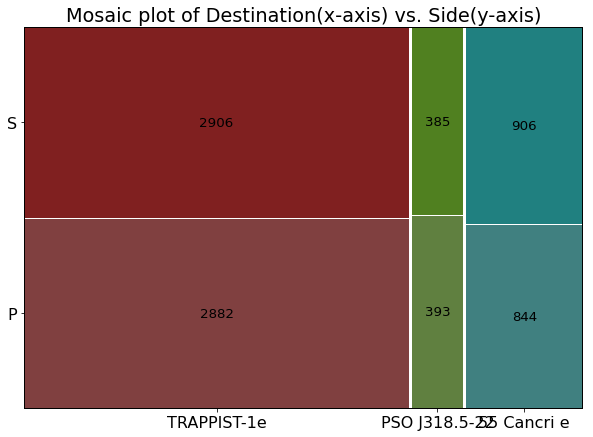

In [139]:
plot_mosaic(('Destination', 'Side'), bool_strings=(False, False))

There is no significant correlation between `Destination` and `Side` of the deck. Passengers to all destinations were approximately evenly distributed between deck sides

#### Age

##### Age vs. VIP

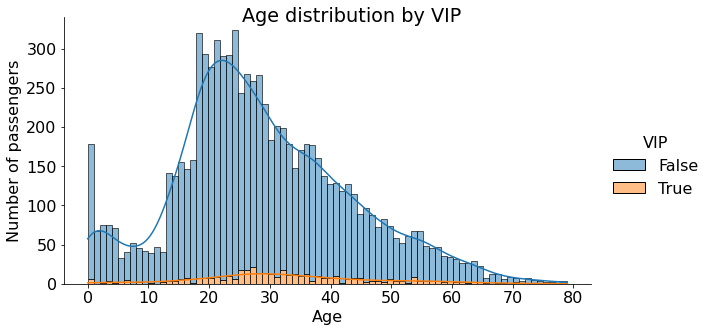

In [140]:
group_displot(('Age', 'VIP'))

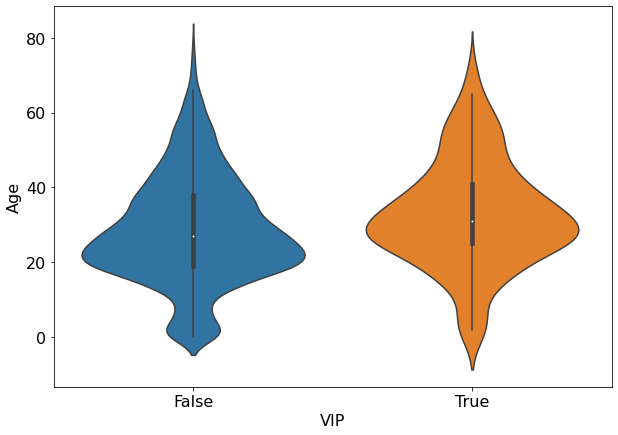

In [141]:
ax = sns.violinplot(x='VIP', y='Age', data=df)

Mostly passengers around 30 years old bought VIP status, and almost no VIP amongst children younger than 10 years old

##### Age vs. RoomService

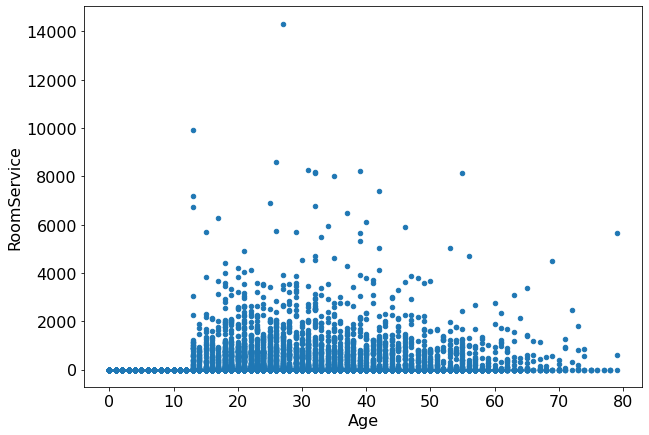

In [142]:
df.plot.scatter(x='Age',y='RoomService');

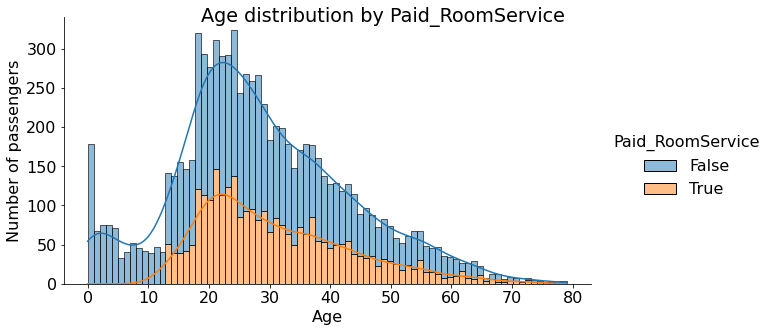

In [143]:
group_displot(('Age', 'Paid_RoomService'))

From plots we can see, that passengers younger than 13 years were not billed on Room Service at all and the maximum variability of the Room Service billing is among the passengers from 15 to 50 years old

##### Age vs. FoodCourt

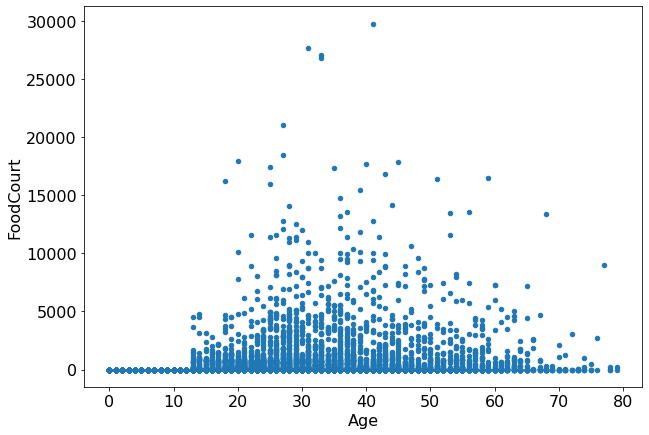

In [144]:
df.plot.scatter(x='Age',y='FoodCourt');

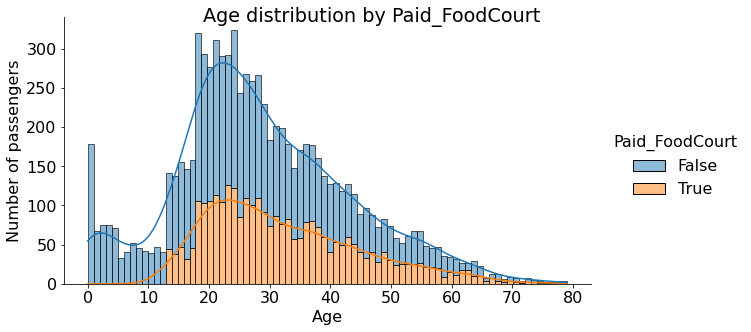

In [145]:
group_displot(('Age', 'Paid_FoodCourt'))

From plots we can see, that passengers younger than 13 years old were not billed on Food Court at all and the maximum variability of the Food Court billing is among the passengers from 20 to 45 years old

##### Age vs. ShoppingMall

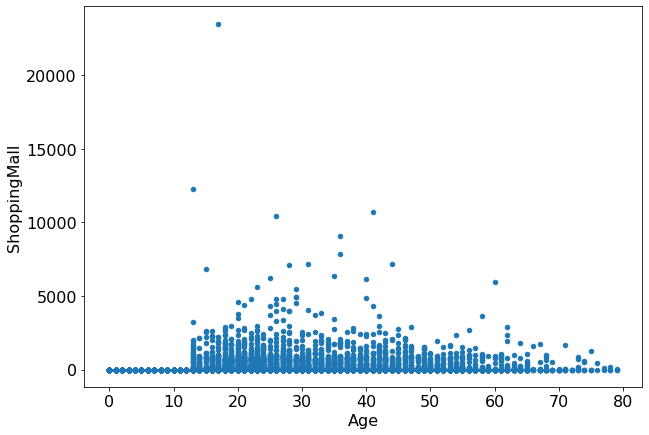

In [146]:
df.plot.scatter(x='Age',y='ShoppingMall');

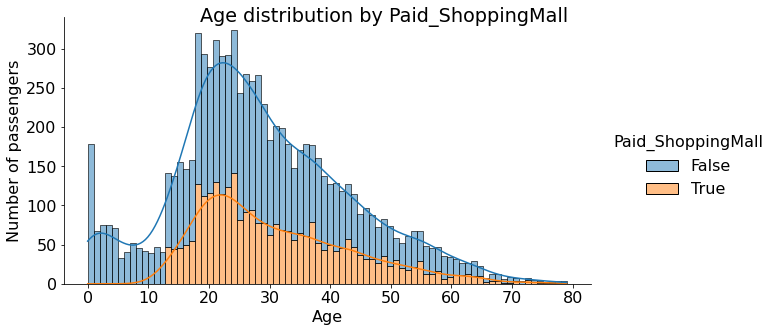

In [147]:
group_displot(('Age', 'Paid_ShoppingMall'))

From plots we can see, that passengers younger than 13 years old didn't spend money in Shopping Mall at all and the maximum variability of the Shopping Mall billing is among the passengers from 15 to 45 years old

##### Age vs. Spa

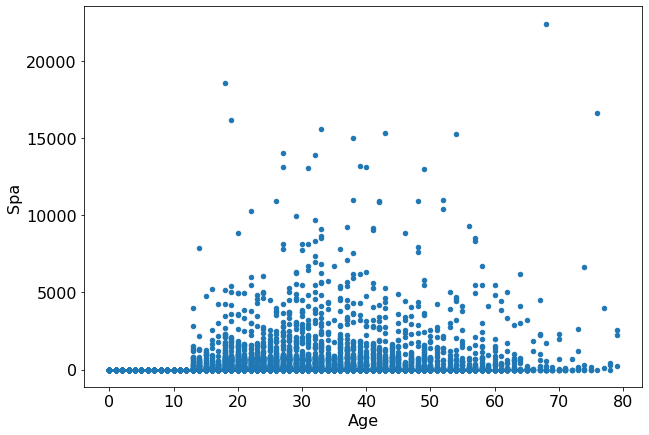

In [148]:
df.plot.scatter(x='Age',y='Spa');

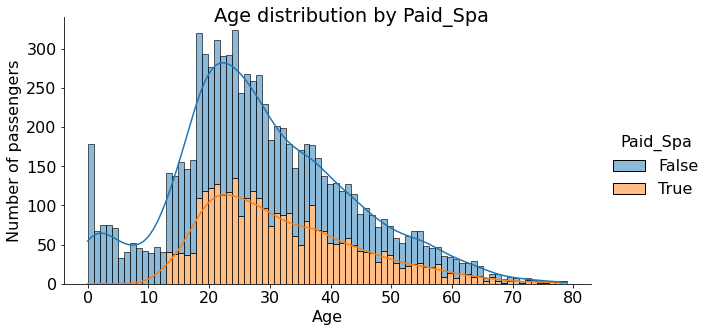

In [149]:
group_displot(('Age', 'Paid_Spa'))

From plots we can see, that passengers younger than 13 years old  were not billed on Spa at all and variability of the Spa billing is approximately the among the passengers from 14 years and older, with some decreasing after 65 (which may be related with smaller number of passengers of this age)

##### Age vs. VRDeck

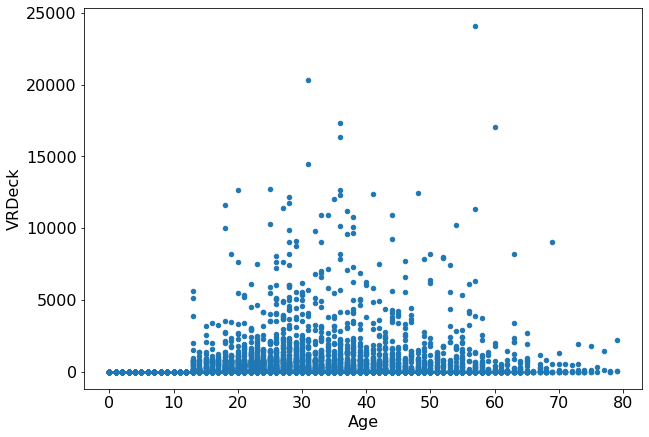

In [150]:
df.plot.scatter(x='Age',y='VRDeck');

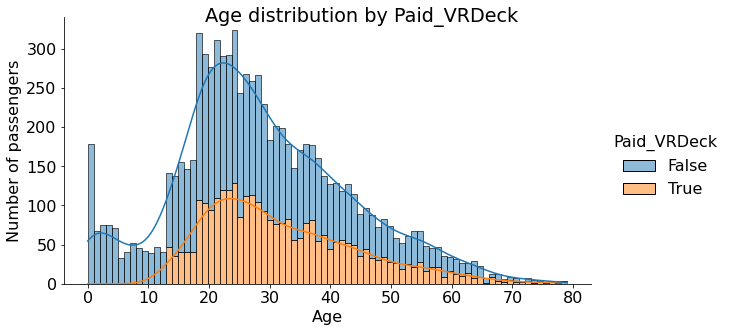

In [151]:
group_displot(('Age', 'Paid_VRDeck'))

From plots we can see, that passengers younger than 13 years old  were not billed on VRDeck at all and variability of the Spa billing is among the passengers from 20 to 60 years old

##### Age vs. GroupSize

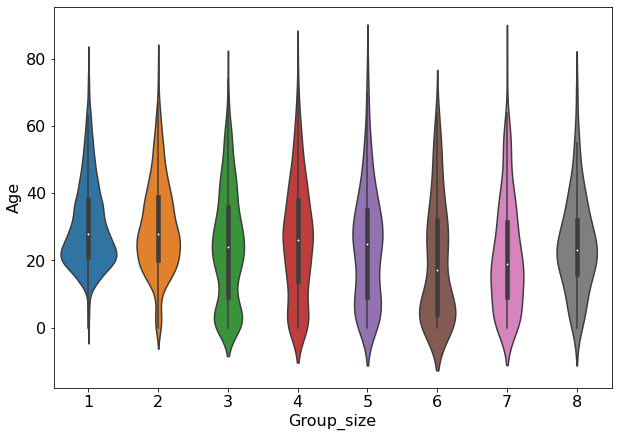

In [152]:
ax = sns.violinplot(x='Group_size', y='Age', data=df)

We can see, that almost no single travellers travelled below 10 years old, but most of the travellers around 20-25 years old travelled alone or in couples. Most of very young passengers (below 10 years old) travlled in groups of 3 or 6 persons.

##### Age vs. Deck

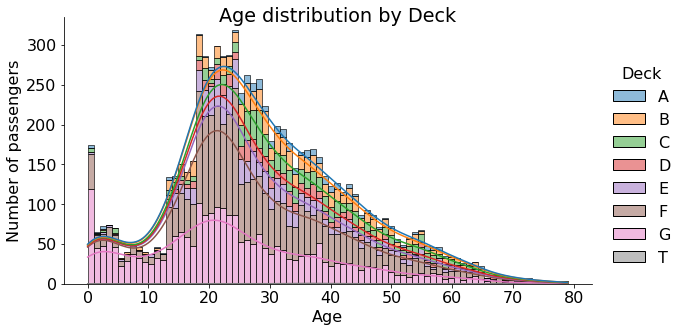

In [153]:
group_displot(('Age', 'Deck'))

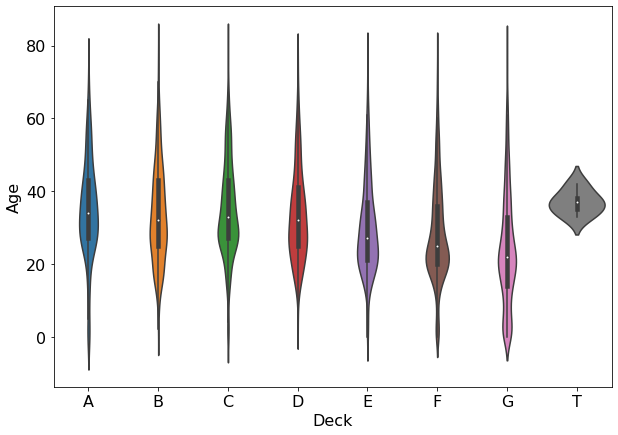

In [154]:
ax = sns.violinplot(x='Deck', y='Age', data=df)

Medium age of passengers on decks A, B, C, D and T is higher than on other decks. Most of babies (0-1 years old) were located on decks F and G. Small group of passengers from deck T is in between 30 and 50 years old.

##### Age vs. Side

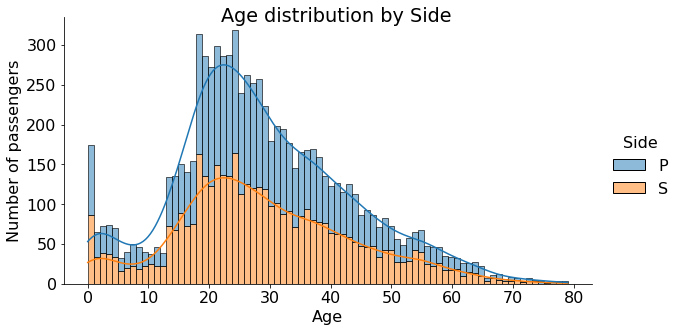

In [155]:
group_displot(('Age', 'Side'))

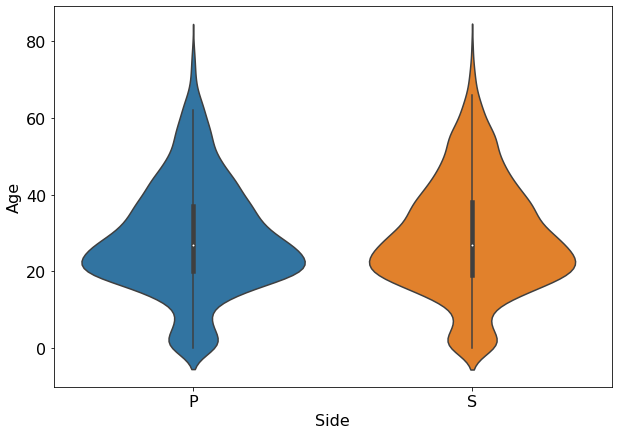

In [156]:
ax = sns.violinplot(x='Side', y='Age', data=df)

There is no significant dependences between passenger `Age` and its cabin `Side`

#### VIP status

##### VIP vs. RoomService

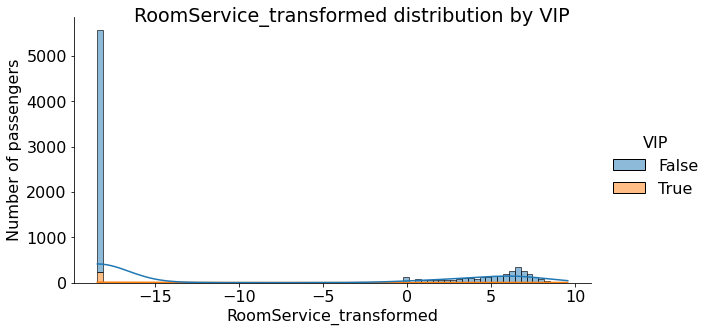

In [157]:
group_displot(('RoomService_transformed', 'VIP'))

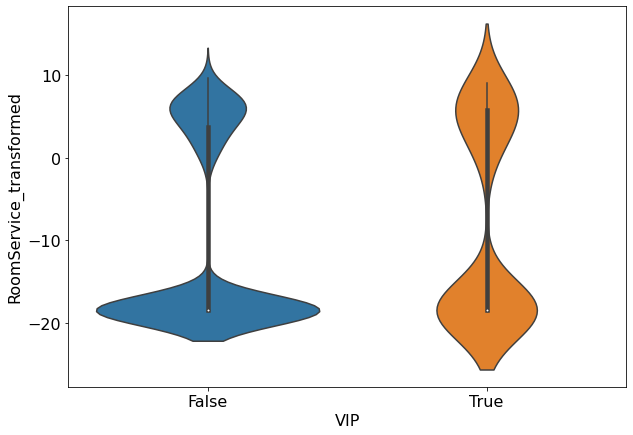

In [158]:
ax = sns.violinplot(x='VIP', y='RoomService_transformed', data=df)

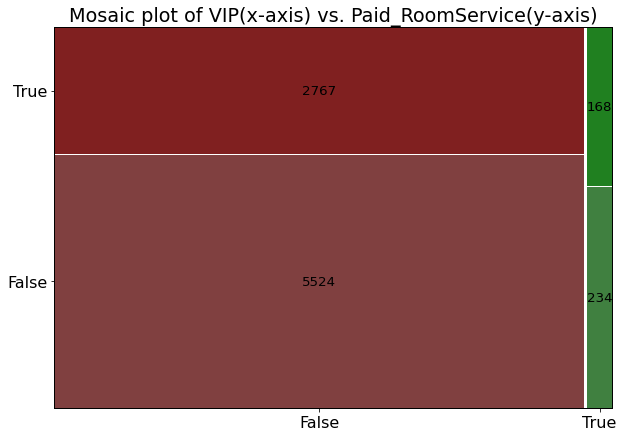

In [159]:
plot_mosaic(('VIP', 'Paid_RoomService'), bool_strings=(True, True))

From plots we can see, that `VIP` in average spent a bit more money for `RoomService`

##### VIP vs. FoodCourt

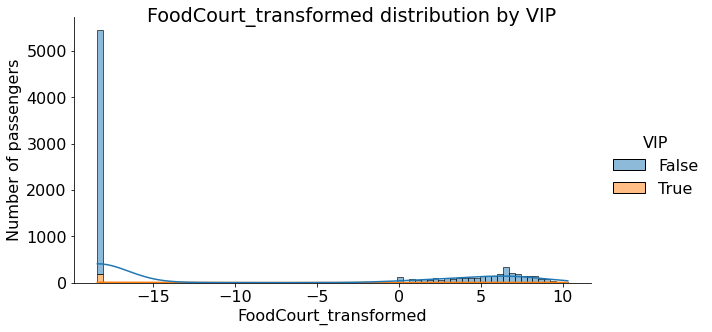

In [160]:
group_displot(('FoodCourt_transformed', 'VIP'))

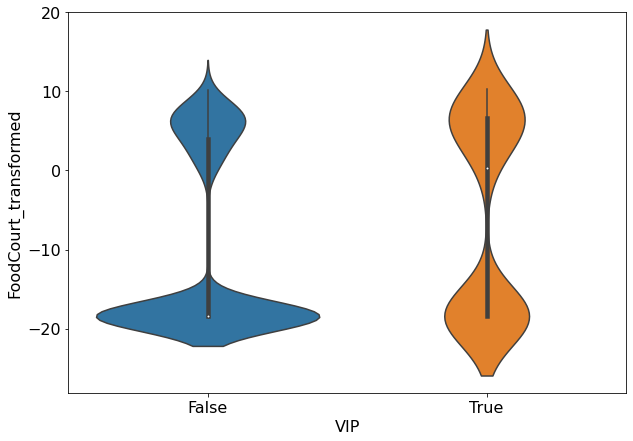

In [161]:
ax = sns.violinplot(x='VIP', y='FoodCourt_transformed', data=df)

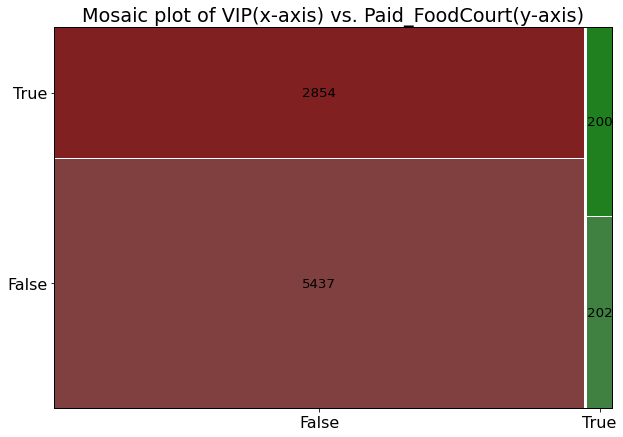

In [162]:
plot_mosaic(('VIP', 'Paid_FoodCourt'), bool_strings=(True, True))

From plots we can see, that `VIP` in average spent more money for `FoodCourt`

##### VIP vs. ShoppingMall

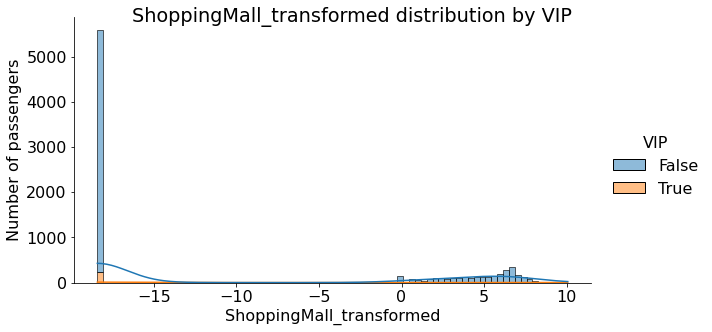

In [163]:
group_displot(('ShoppingMall_transformed', 'VIP'))

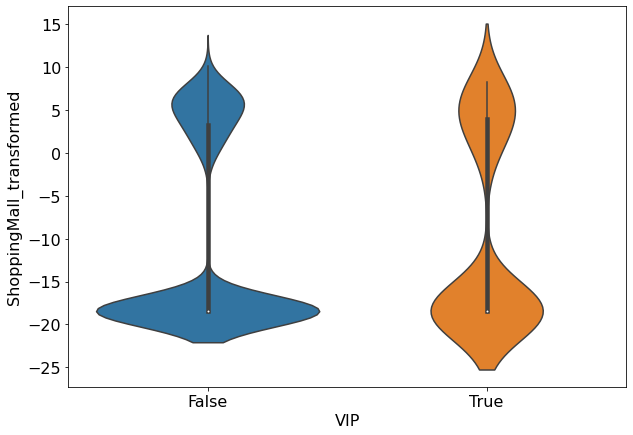

In [164]:
ax = sns.violinplot(x='VIP', y='ShoppingMall_transformed', data=df)

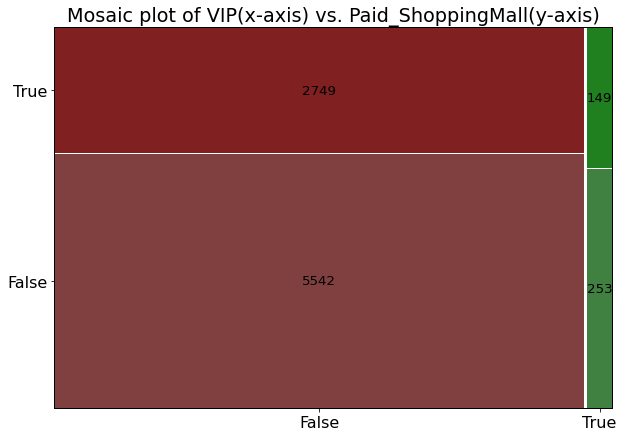

In [165]:
plot_mosaic(('VIP', 'Paid_ShoppingMall'), bool_strings=(True, True))

From plots we can see, that the highest amount in Shopping Mall was spent by non-VIP passenger

##### VIP vs. Spa

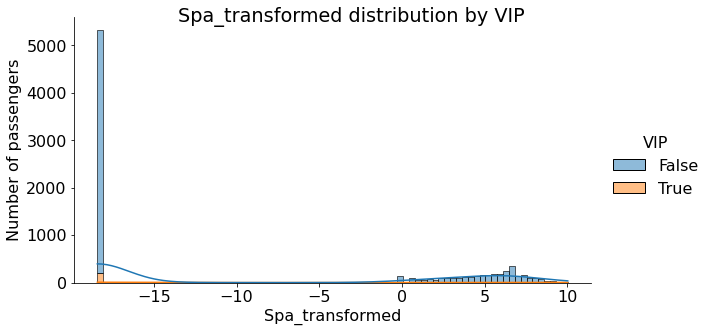

In [166]:
group_displot(('Spa_transformed', 'VIP'))

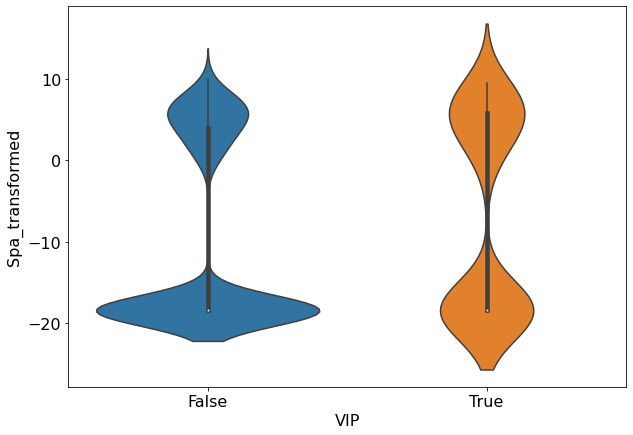

In [167]:
ax = sns.violinplot(x='VIP', y='Spa_transformed', data=df)

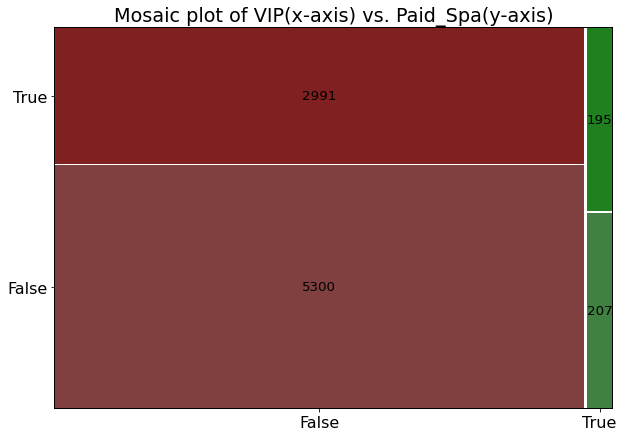

In [168]:
plot_mosaic(('VIP', 'Paid_Spa'), bool_strings=(True, True))

From plots we can see, that `VIP` in average spent a bit more money for `Spa`

##### VIP vs. VRDeck

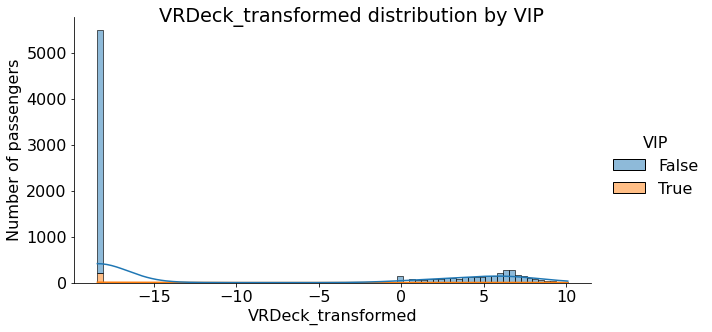

In [169]:
group_displot(('VRDeck_transformed', 'VIP'))

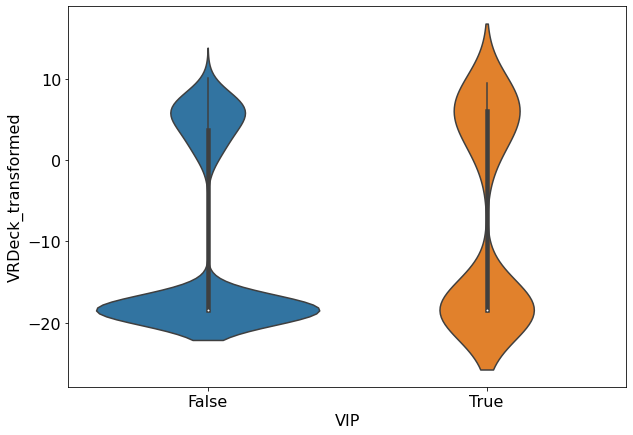

In [170]:
ax = sns.violinplot(x='VIP', y='VRDeck_transformed', data=df)

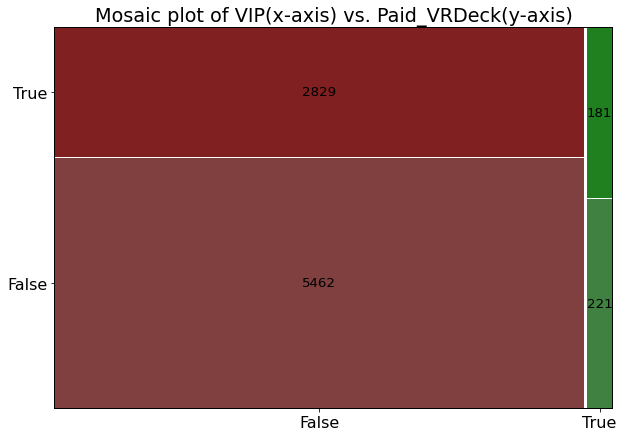

In [171]:
plot_mosaic(('VIP', 'Paid_VRDeck'), bool_strings=(True, True))

From plots we can see, that `VIP` in average spent a bit more money for `VRDeck`, but the highest amount spent certain passengers without this status

Observations are similar for all five spaceship facilities: VIP passengers spent a bit more money on them, but some individual travellers could spend much more independent on their VIP status

##### VIP vs. GroupSize

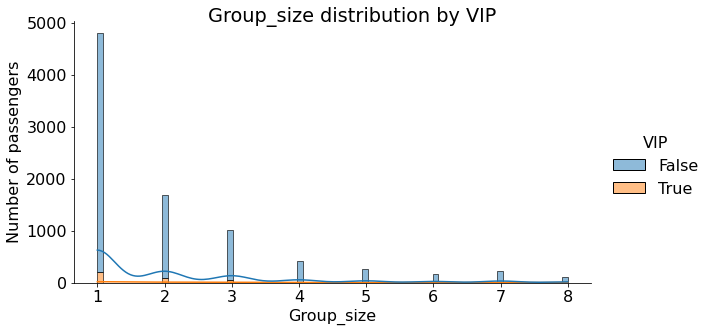

In [172]:
group_displot(('Group_size', 'VIP'))

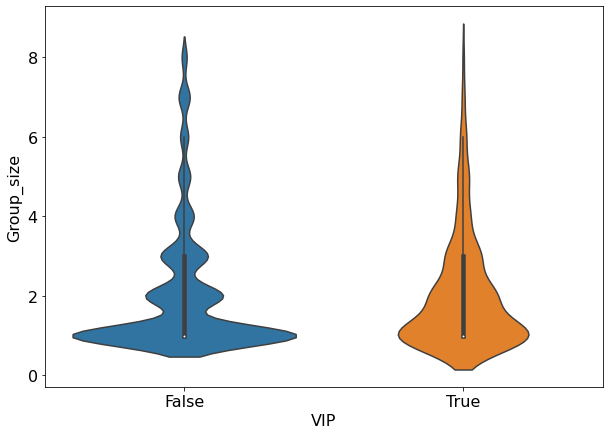

In [173]:
ax = sns.violinplot(x='VIP', y='Group_size', data=df)

Distribution of group sizes is not dependend from VIP statuses of their members

##### VIP vs. Deck

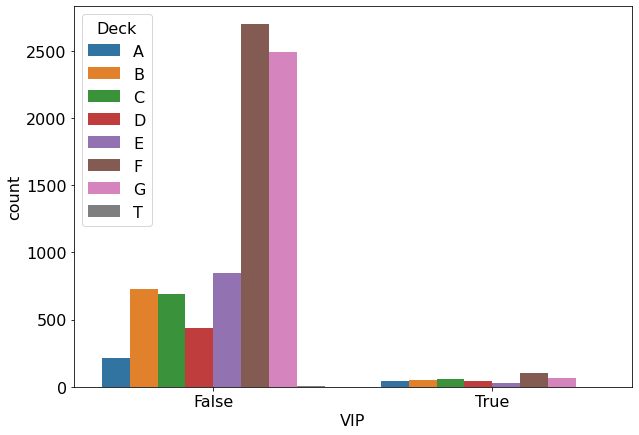

In [174]:
# Mosaic plot is not easy to read when many categories
sns.countplot(data=df, x="VIP", hue="Deck");

From bar plot, we see, that VIP passengers were relatively equally located on all decks (with some prevalence on the largest deck F), while non-VIP passengers have significant prevalence on decks F and G and some infrequence on deck A (compare to other decks)

##### VIP vs. Side

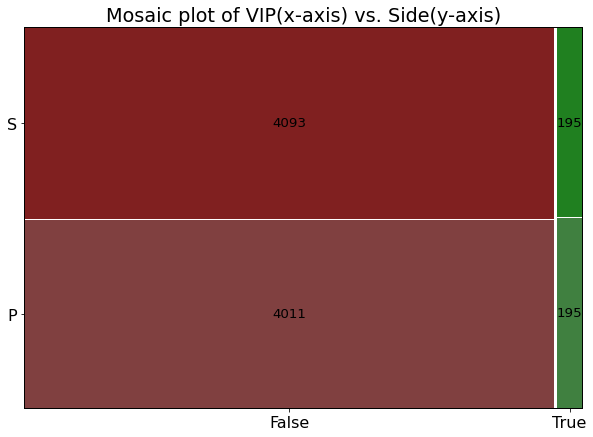

In [175]:
plot_mosaic(('VIP', 'Side'), bool_strings=(True, False))

There is no correlation between `VIP` and `Side` of the deck. VIP and non-VIP passengers were approximately evenly distributed between deck sides

#### RoomService

##### RoomService vs. FoodCourt

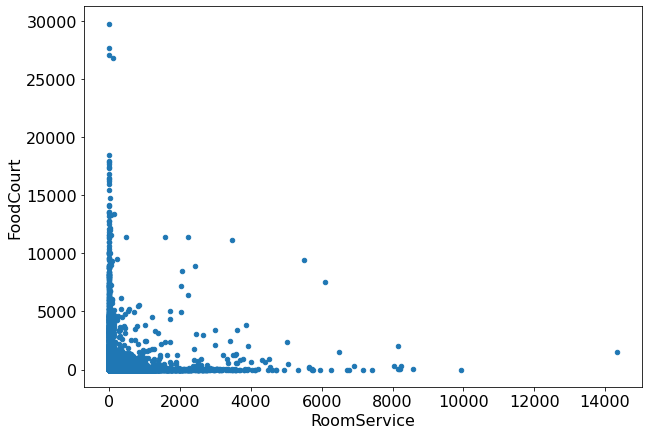

In [176]:
df.plot.scatter(x='RoomService',y='FoodCourt');

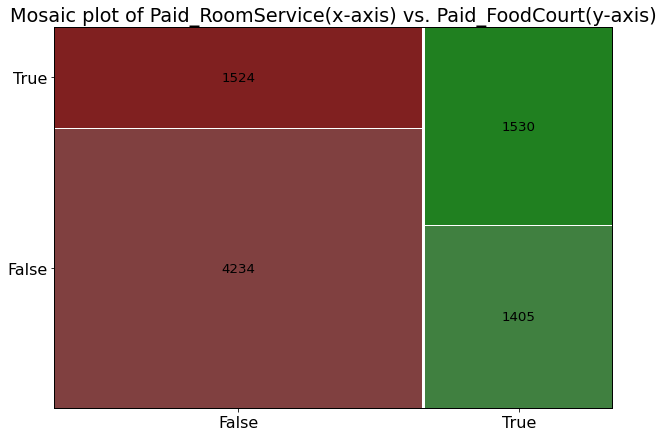

In [177]:
plot_mosaic(('Paid_RoomService', 'Paid_FoodCourt'), bool_strings=(True, True))

There is no significant correlation between billings on Room Service and Food Court, but among RoomService consumers about half also used Food Court and other way around

##### RoomService vs. ShoppingMall

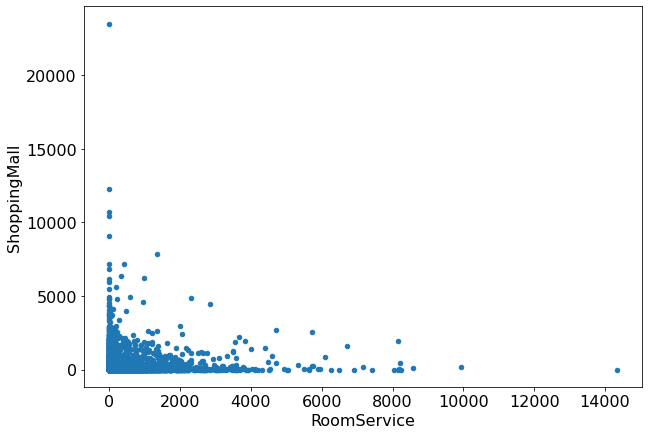

In [178]:
df.plot.scatter(x='RoomService',y='ShoppingMall');

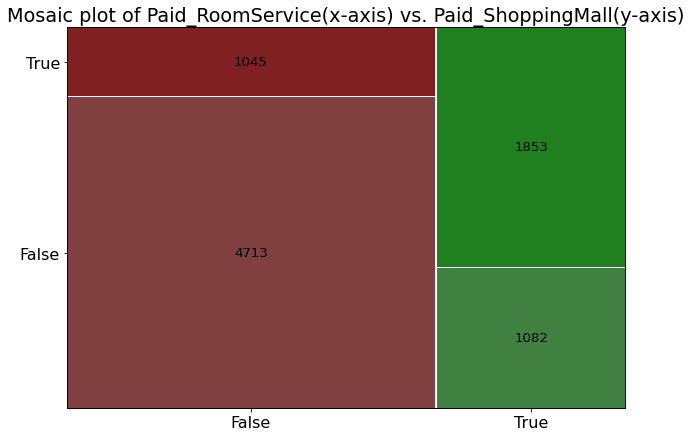

In [179]:
plot_mosaic(('Paid_RoomService', 'Paid_ShoppingMall'), bool_strings=(True, True))

There is some correlation between money spent by passenger for Room Service and in Shopping Mall. Spearman correlation, which was used for correlation matrix, indicated relatively strong correlation as well
We can see that most of the passengers who paid for Room Service also paid for Shopping Mall

##### RoomService vs. Spa

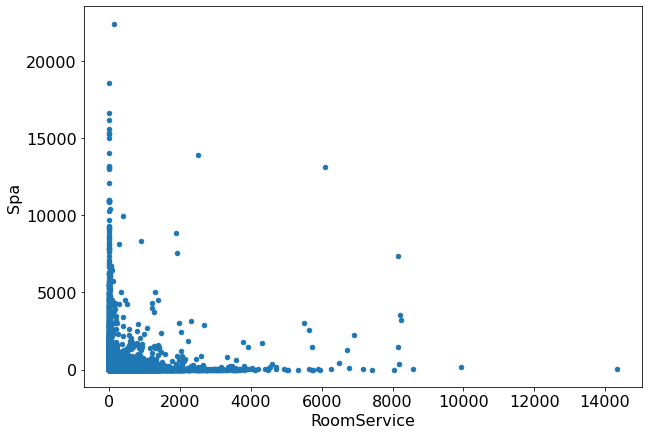

In [180]:
df.plot.scatter(x='RoomService',y='Spa');

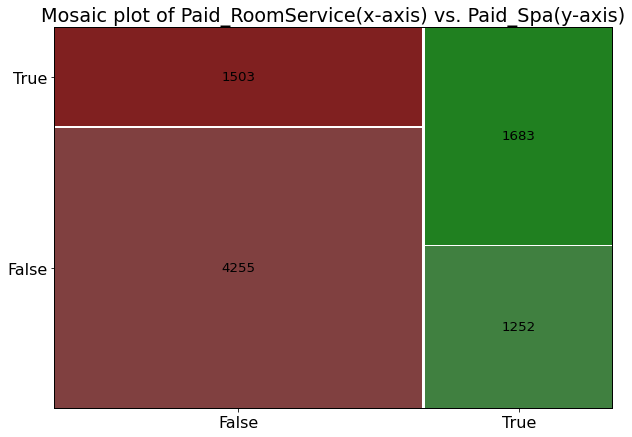

In [181]:
plot_mosaic(('Paid_RoomService', 'Paid_Spa'), bool_strings=(True, True))

There is no significant correlation between billings for Room Service and Spa

##### RoomService vs. VRDeck

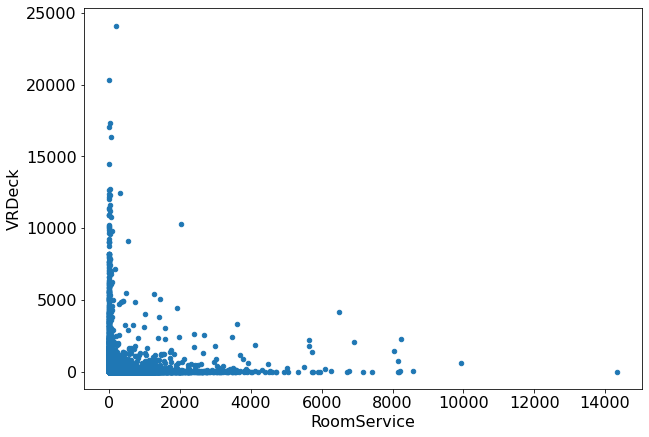

In [182]:
df.plot.scatter(x='RoomService',y='VRDeck');

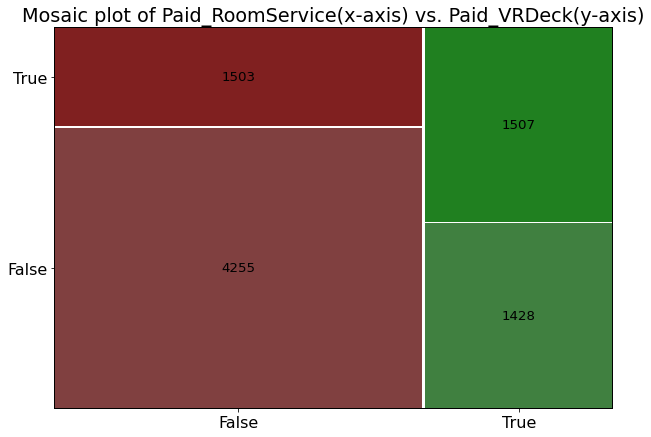

In [183]:
plot_mosaic(('Paid_RoomService', 'Paid_VRDeck'), bool_strings=(True, True))

There is no significant correlation between billings for Room Service and VRDeck

##### RoomService vs. GroupSize

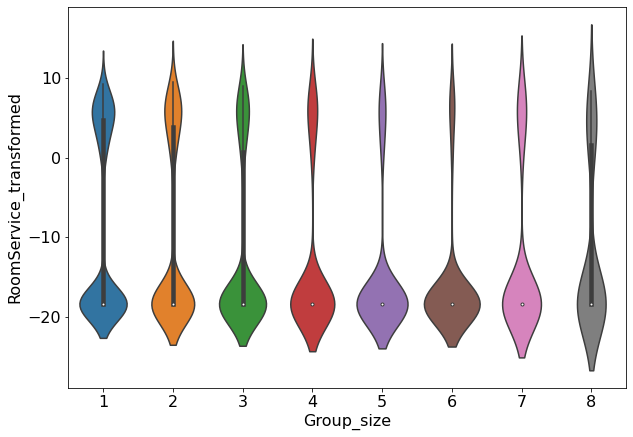

In [184]:
ax = sns.violinplot(x='Group_size', y='RoomService_transformed', data=df)

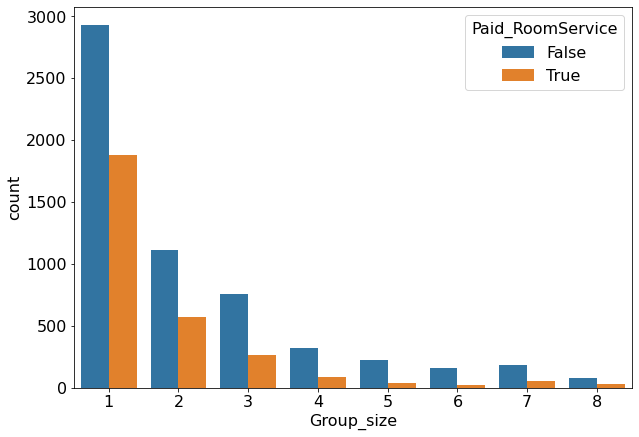

In [185]:
sns.countplot(data=df, x="Group_size", hue="Paid_RoomService");

We can see, that among single travellers more than half spent money on Room Service.

##### RoomService vs. Deck

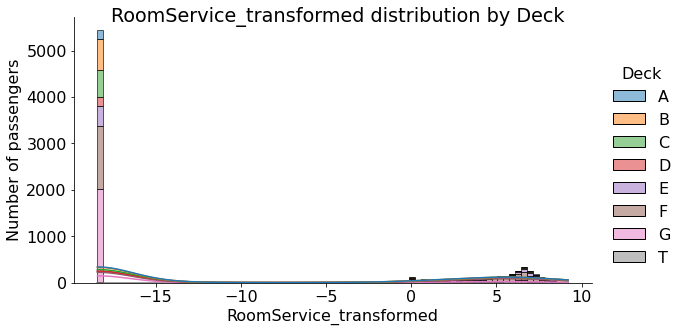

In [186]:
group_displot(('RoomService_transformed', 'Deck'))

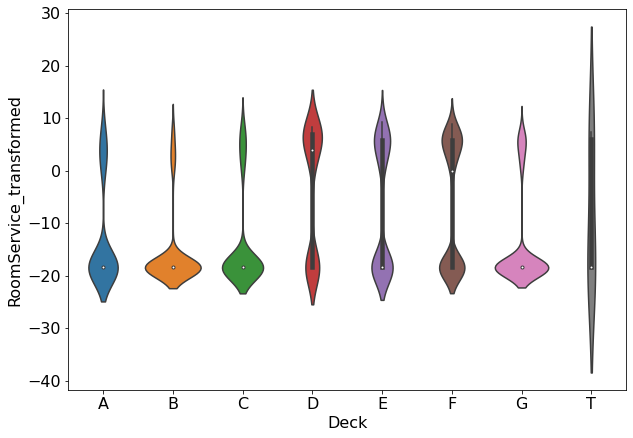

In [187]:
ax = sns.violinplot(x='Deck', y='RoomService_transformed', data=df)

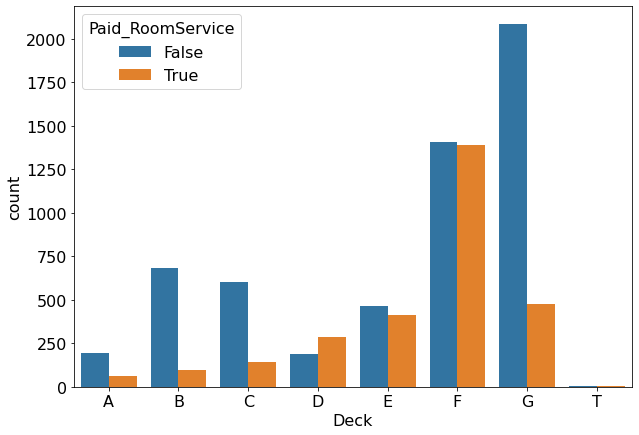

In [188]:
sns.countplot(data=df, x="Deck", hue="Paid_RoomService");

Most of deck A, B, C and G passengers didn't spend any money for Room Service.

##### RoomService vs. Side

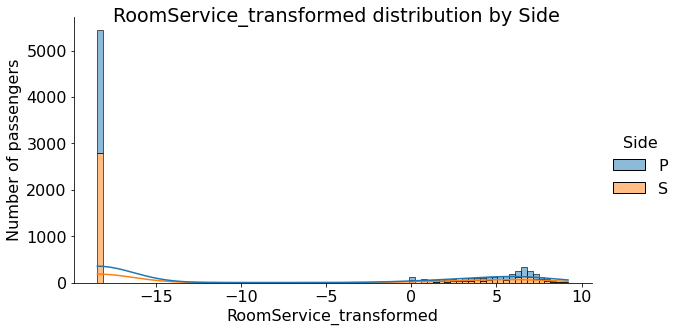

In [189]:
group_displot(('RoomService_transformed', 'Side'))

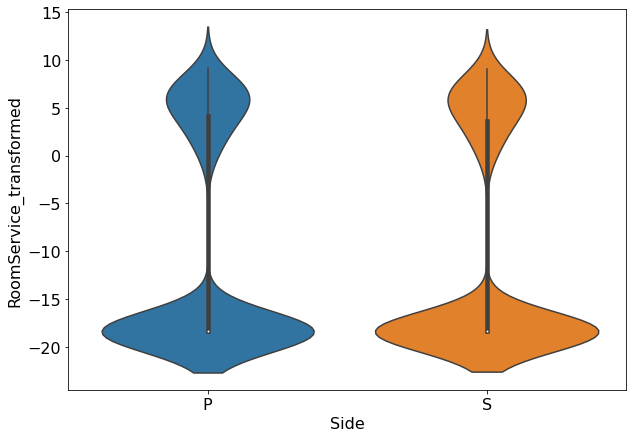

In [190]:
ax = sns.violinplot(x='Side', y='RoomService_transformed', data=df)

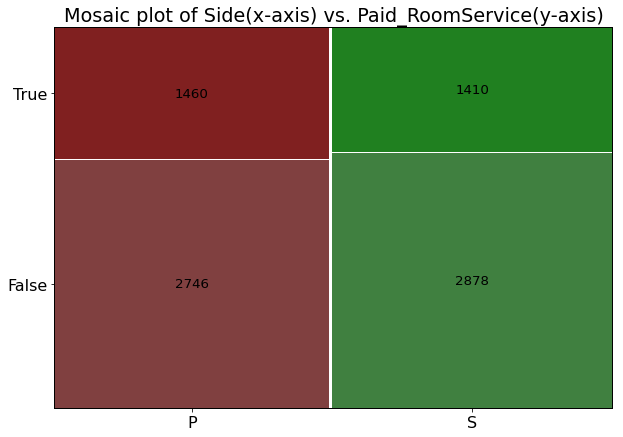

In [191]:
plot_mosaic(('Side', 'Paid_RoomService'), bool_strings=(False, True))

There is no significant dependences between passenger `RoomService` billing amount and its cabin `Side`

#### FoodCourt

##### FoodCourt vs. ShoppingMall

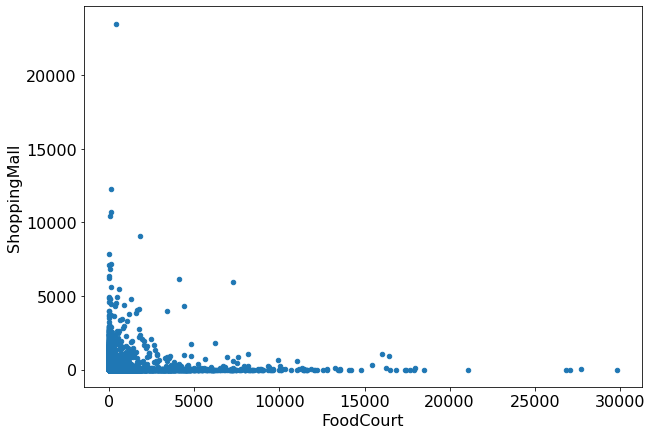

In [192]:
df.plot.scatter(x='FoodCourt',y='ShoppingMall');

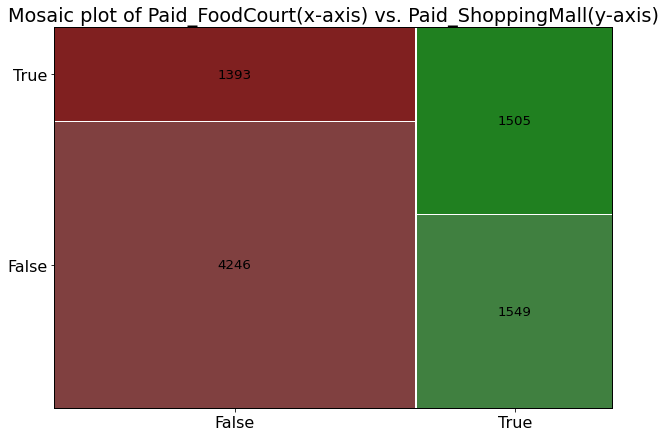

In [193]:
plot_mosaic(('Paid_FoodCourt', 'Paid_ShoppingMall'), bool_strings=(True, True))

There is no significant correlation between billings for Food Court and Shopping Mall

##### FoodCourt vs. Spa

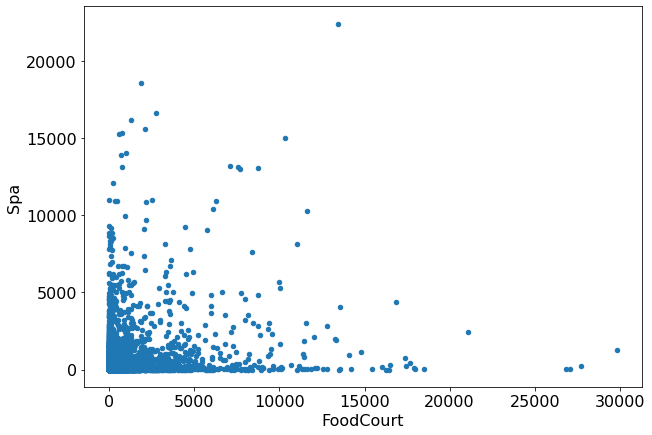

In [194]:
df.plot.scatter(x='FoodCourt',y='Spa');

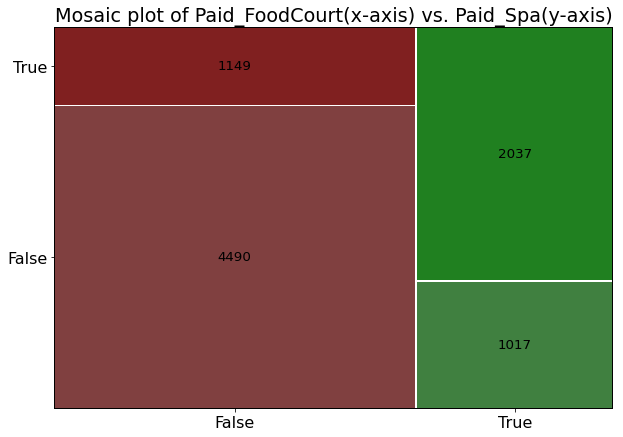

In [195]:
plot_mosaic(('Paid_FoodCourt', 'Paid_Spa'), bool_strings=(True, True))

There is some correlation between money spent by passenger in Food Court and in Spa. Spearman correlation, which was used for correlation matrix, indicated relatively strong correlation as well

##### FoodCourt vs. VRDeck

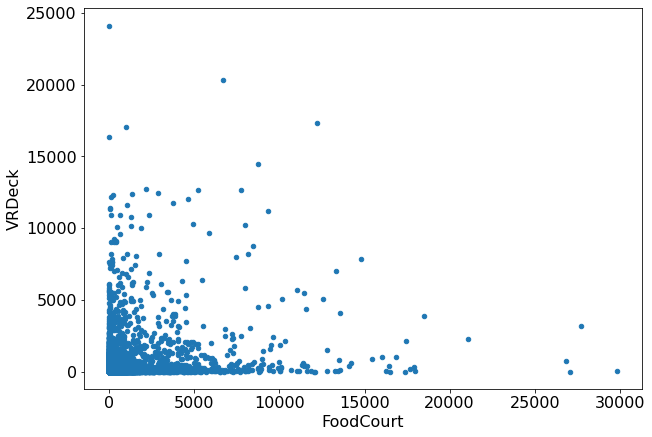

In [196]:
df.plot.scatter(x='FoodCourt',y='VRDeck');

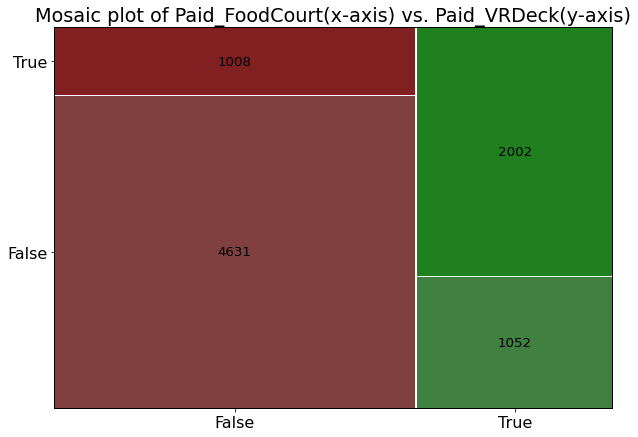

In [197]:
plot_mosaic(('Paid_FoodCourt', 'Paid_VRDeck'), bool_strings=(True, True))

There is some correlation between money spent by passenger in Food Court and in VRDeck. Spearman correlation, which was used for correlation matrix, indicated relatively strong correlation as well

##### FoodCourt vs. GroupSize

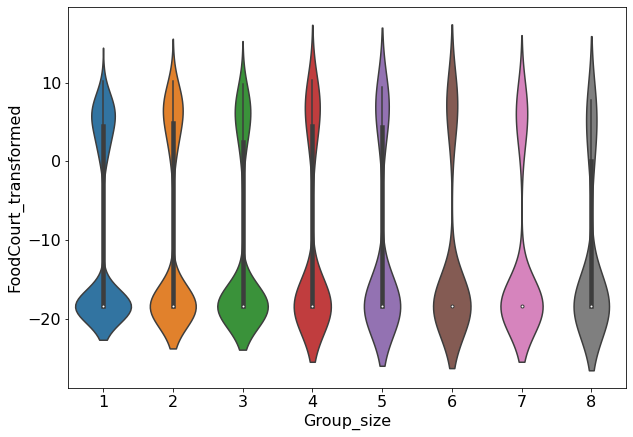

In [198]:
ax = sns.violinplot(x='Group_size', y='FoodCourt_transformed', data=df)

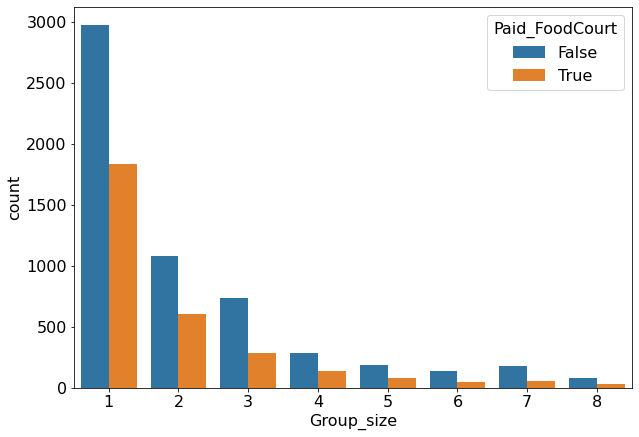

In [199]:
sns.countplot(data=df, x="Group_size", hue="Paid_FoodCourt");

We can see, that travellers of large groups (6 and more persons) mostly didn't spend money on Food Court

##### FoodCourt vs. Deck

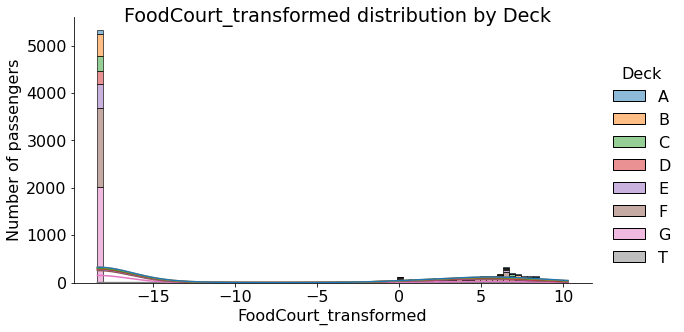

In [200]:
group_displot(('FoodCourt_transformed', 'Deck'))

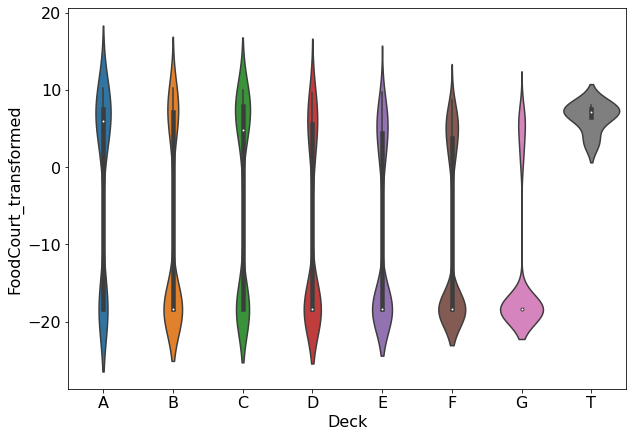

In [201]:
ax = sns.violinplot(x='Deck', y='FoodCourt_transformed', data=df)

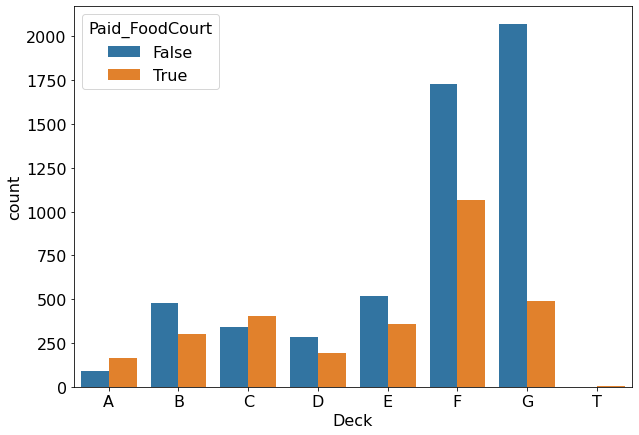

In [202]:
sns.countplot(data=df, x="Deck", hue="Paid_FoodCourt");

Most of decks F and G passengers didn't spend any money for Foud Court, while majority of passengers from decks A and C did. Also, all passengers from deck T spent large amount of money for Foud Court

##### FoodCourt vs. Side

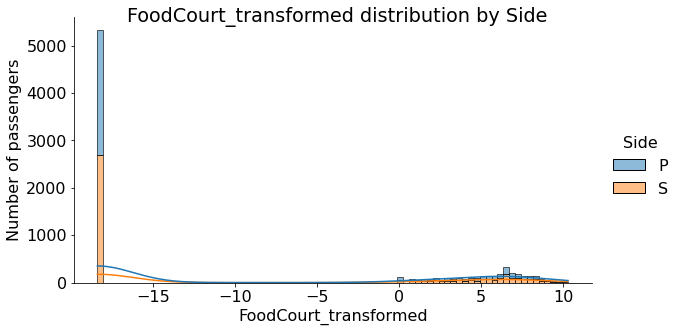

In [203]:
group_displot(('FoodCourt_transformed', 'Side'))

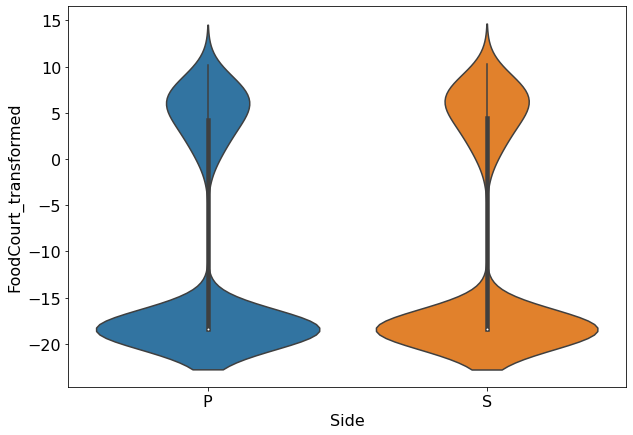

In [204]:
ax = sns.violinplot(x='Side', y='FoodCourt_transformed', data=df)

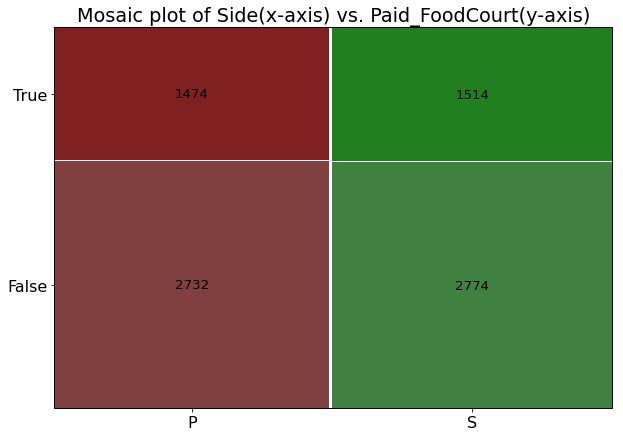

In [205]:
plot_mosaic(('Side', 'Paid_FoodCourt'), bool_strings=(False, True))

There is no significant dependences between passenger `FoodCourt` billing amount and its cabin `Side`

#### ShoppingMall

##### ShoppingMall vs. Spa

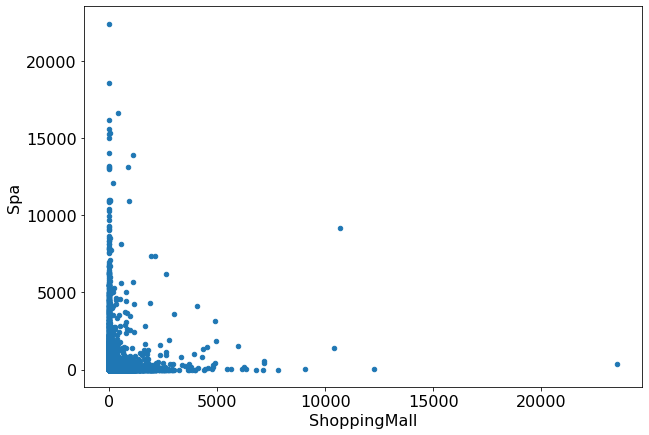

In [206]:
df.plot.scatter(x='ShoppingMall',y='Spa');

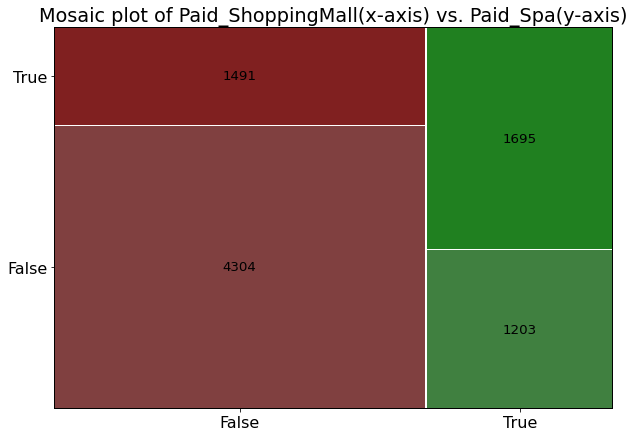

In [207]:
plot_mosaic(('Paid_ShoppingMall', 'Paid_Spa'), bool_strings=(True, True))

There is no significant correlation between billing on Shopping Mall and Spa

##### ShoppingMall vs. VRDeck

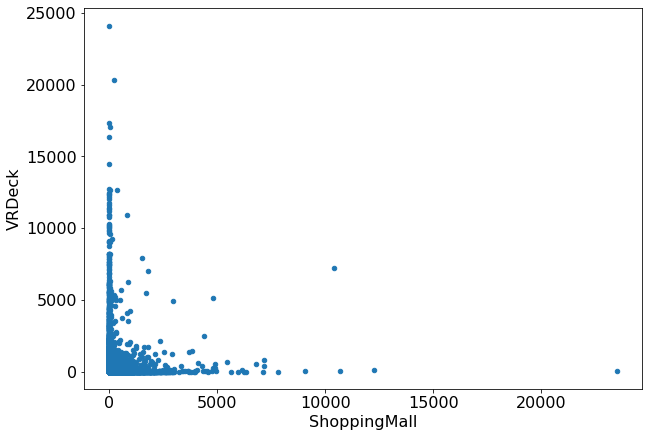

In [208]:
df.plot.scatter(x='ShoppingMall',y='VRDeck');

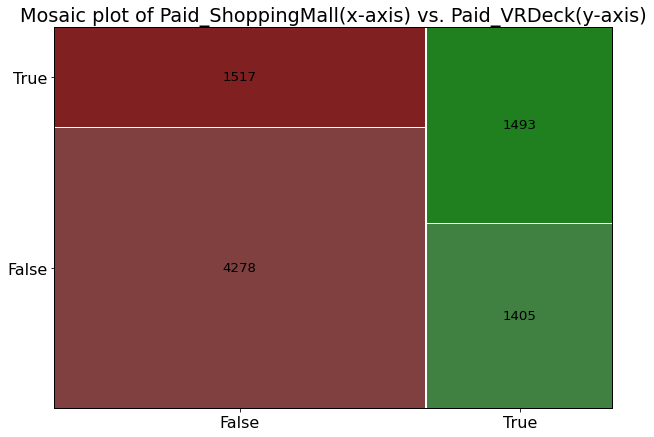

In [209]:
plot_mosaic(('Paid_ShoppingMall', 'Paid_VRDeck'), bool_strings=(True, True))

There is no significant correlation between billing on Shopping Mall and VRDeck

##### ShoppingMall vs. GroupSize

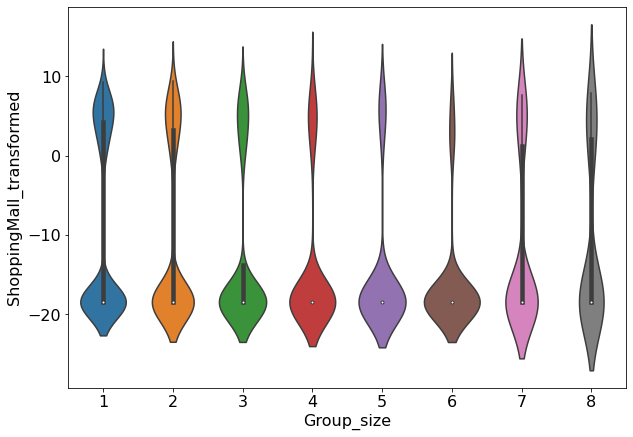

In [210]:
ax = sns.violinplot(x='Group_size', y='ShoppingMall_transformed', data=df)

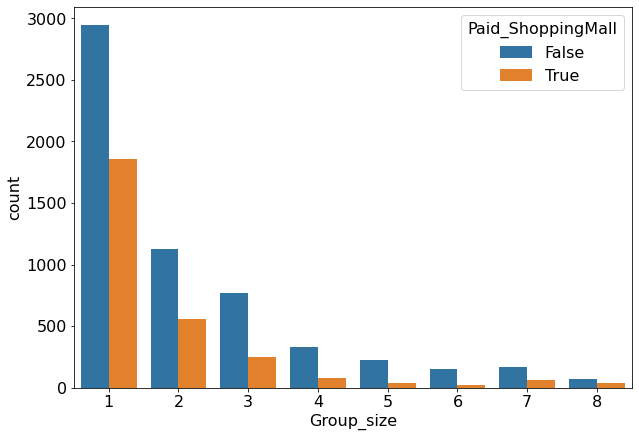

In [211]:
sns.countplot(data=df, x="Group_size", hue="Paid_ShoppingMall");

We can see, that travellers who are in groups of 4, 5 or 6 almost didn't spend money for Shopping Mall

##### ShoppingMall vs. Deck

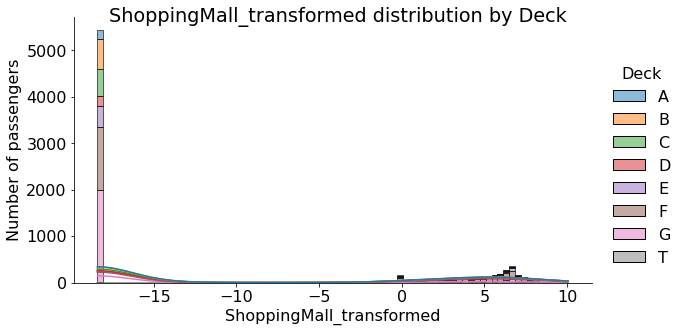

In [212]:
group_displot(('ShoppingMall_transformed', 'Deck'))

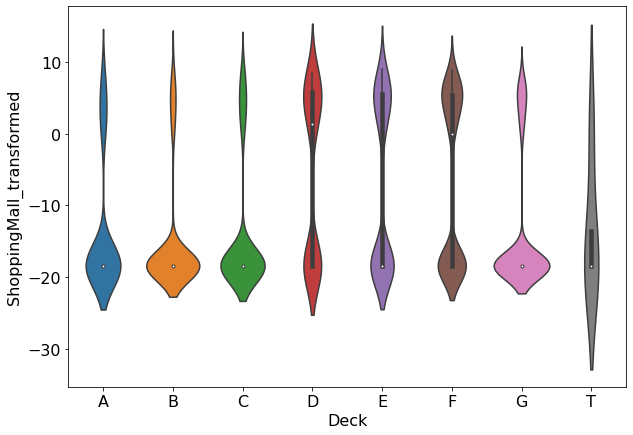

In [213]:
ax = sns.violinplot(x='Deck', y='ShoppingMall_transformed', data=df)

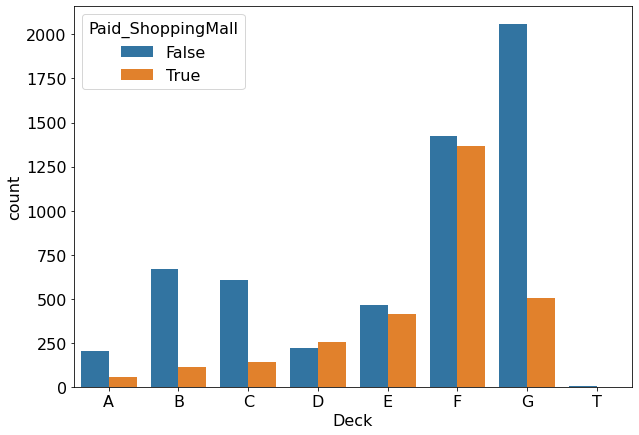

In [214]:
sns.countplot(data=df, x="Deck", hue="Paid_ShoppingMall");

Most passengers who spent money in Shopping Mall are from decks D, E and F, compare to who didn't. None from deck T spent any money in Shopping Mall

##### ShoppingMall vs. Side

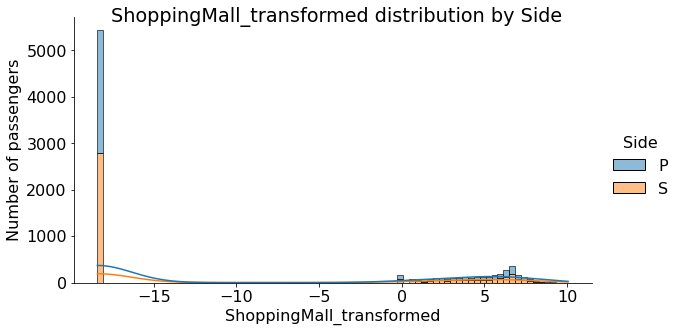

In [215]:
group_displot(('ShoppingMall_transformed', 'Side'))

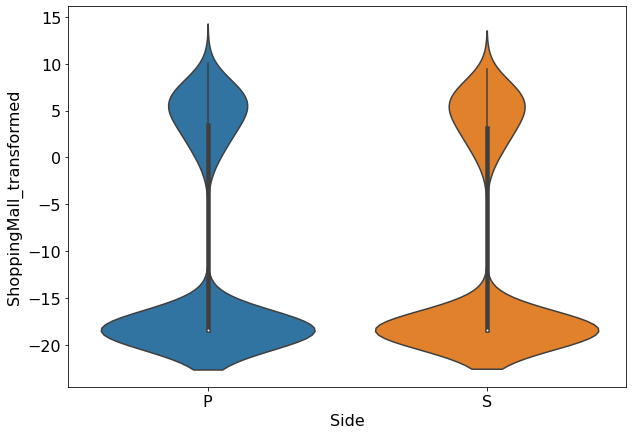

In [216]:
ax = sns.violinplot(x='Side', y='ShoppingMall_transformed', data=df)

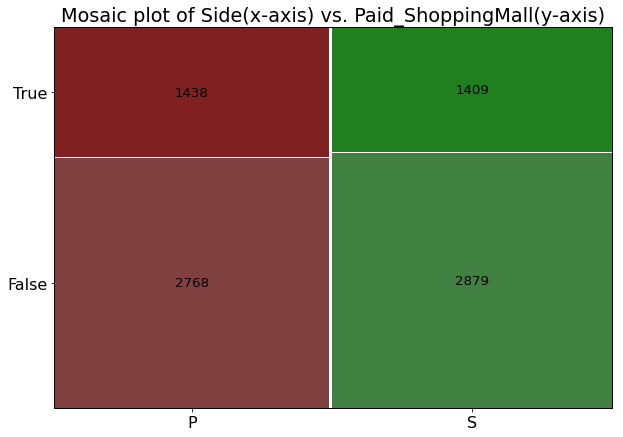

In [217]:
plot_mosaic(('Side', 'Paid_ShoppingMall'), bool_strings=(False, True))

There is no significant dependences between passenger `ShoppingMall` billing amount and its cabin `Side`

#### Spa

##### Spa vs. VRDeck

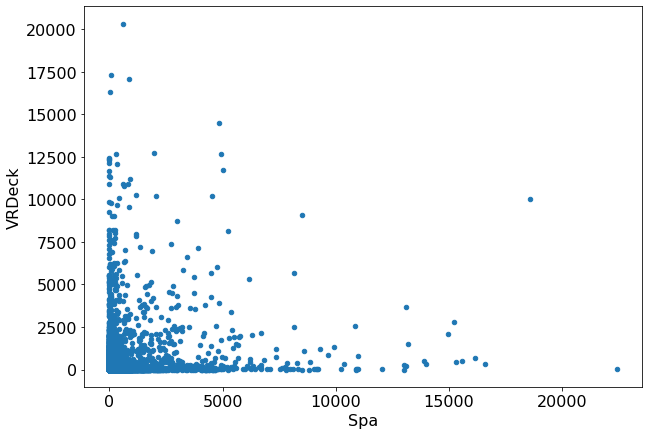

In [218]:
df.plot.scatter(x='Spa',y='VRDeck');

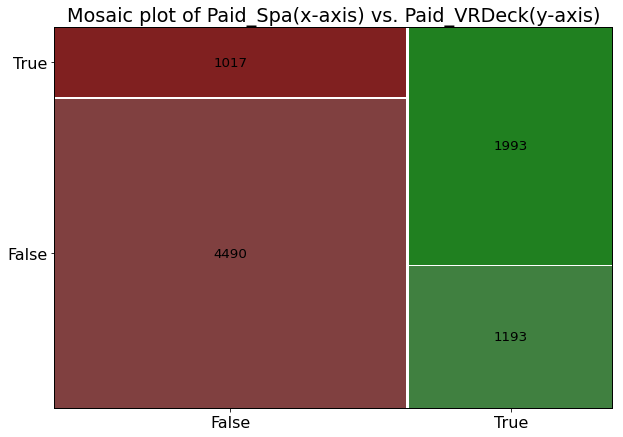

In [219]:
plot_mosaic(('Paid_Spa', 'Paid_VRDeck'), bool_strings=(True, True))

There is a some correlation between billing on Spa and VRDeck

##### Spa vs. GroupSize

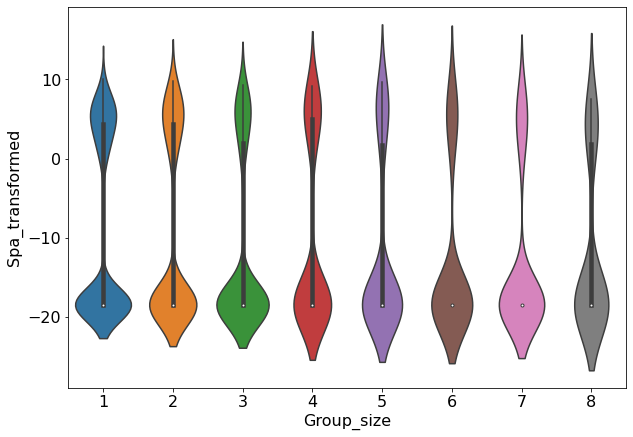

In [220]:
ax = sns.violinplot(x='Group_size', y='Spa_transformed', data=df)

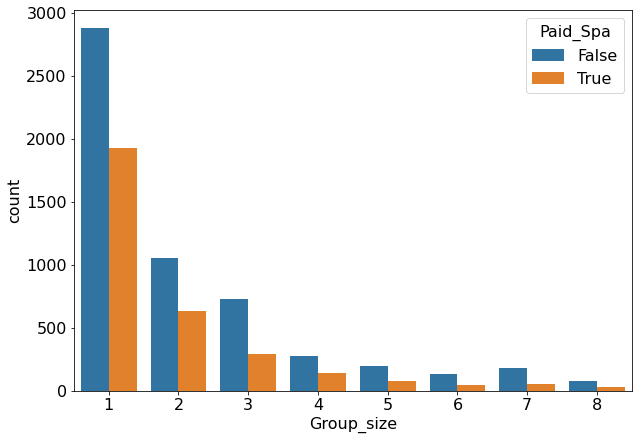

In [221]:
sns.countplot(data=df, x="Group_size", hue="Paid_Spa");

There is no significant correlation between Spa billing and group size

##### Spa vs. Deck

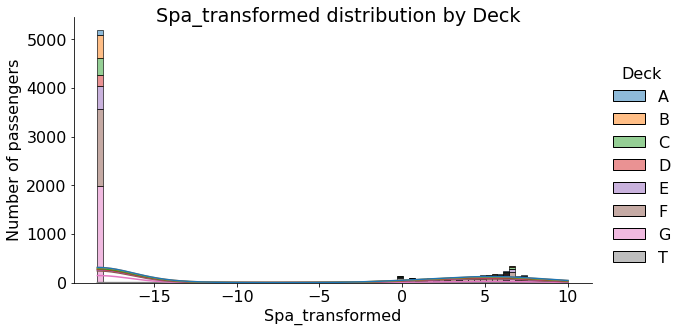

In [222]:
group_displot(('Spa_transformed', 'Deck'))

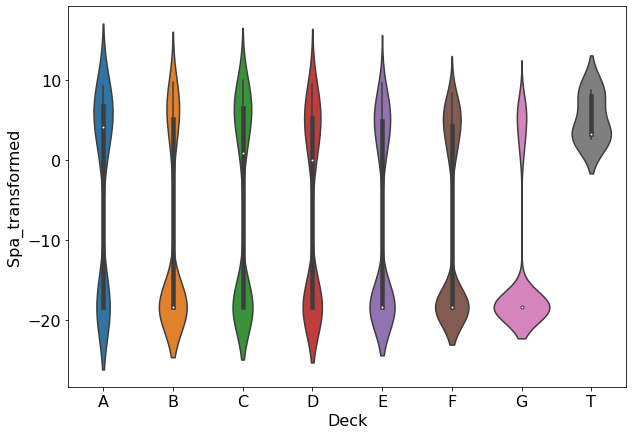

In [223]:
ax = sns.violinplot(x='Deck', y='Spa_transformed', data=df)

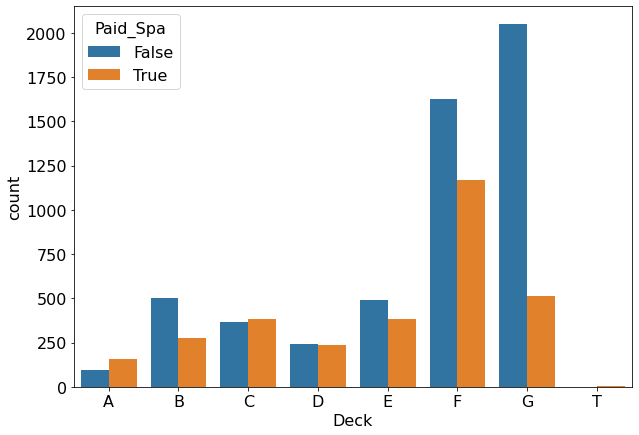

In [224]:
sns.countplot(data=df, x="Deck", hue="Paid_Spa");

More passengers from decks A and C and all passengers from deck T used Spa

##### Spa vs. Side

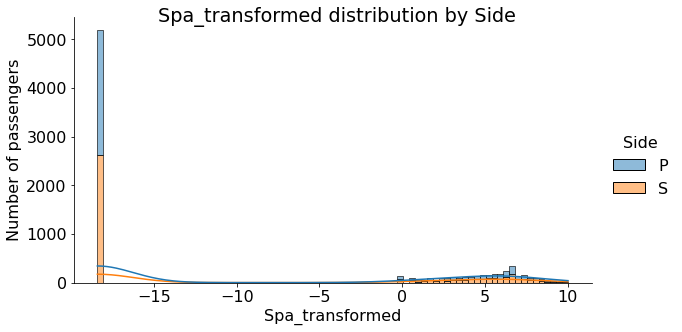

In [225]:
group_displot(('Spa_transformed', 'Side'))

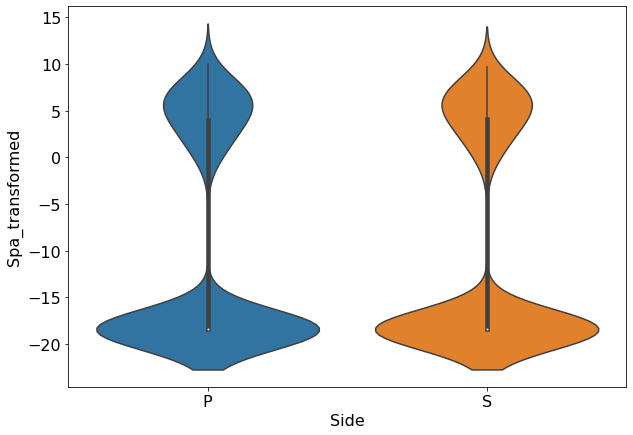

In [226]:
ax = sns.violinplot(x='Side', y='Spa_transformed', data=df)

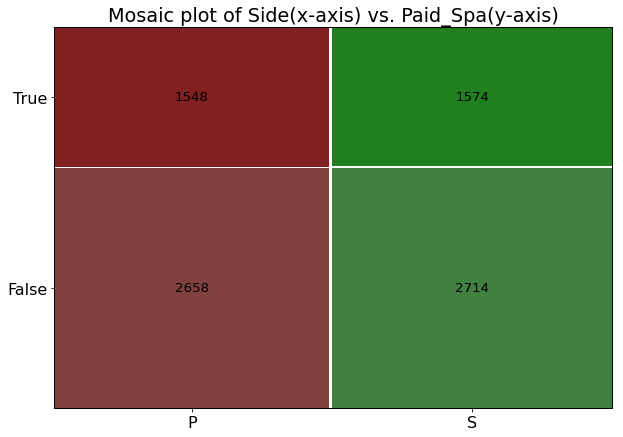

In [227]:
plot_mosaic(('Side', 'Paid_Spa'), bool_strings=(False, True))

There is no significant dependences between passenger `Spa` billing amount and its cabin `Side`

#### VRDeck

##### VRDeck vs. GroupSize

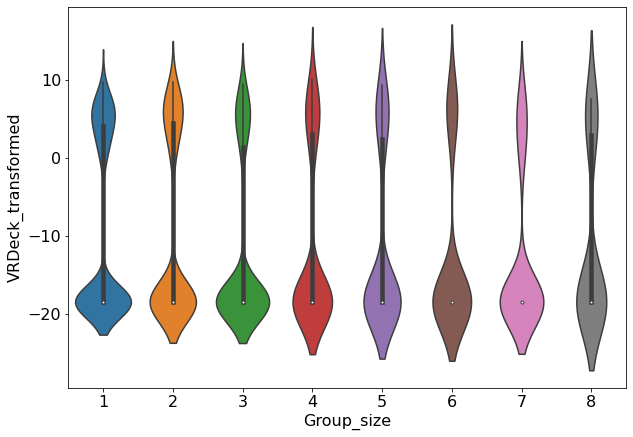

In [228]:
ax = sns.violinplot(x='Group_size', y='VRDeck_transformed', data=df)

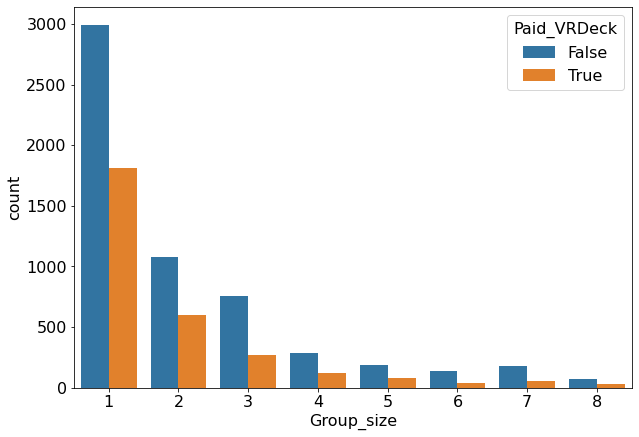

In [229]:
sns.countplot(data=df, x="Group_size", hue="Paid_VRDeck");

There is no significant correlation between VRDeck billing and group size

##### VRDeck vs. Deck

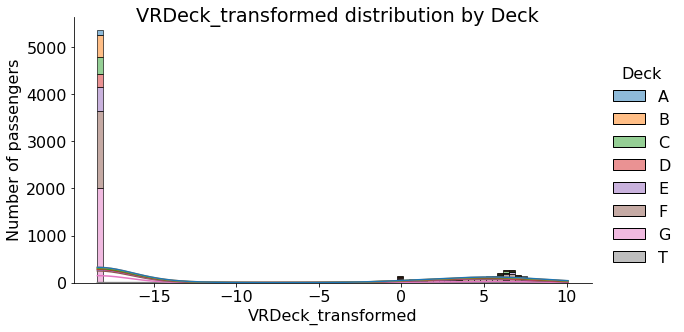

In [230]:
group_displot(('VRDeck_transformed', 'Deck'))

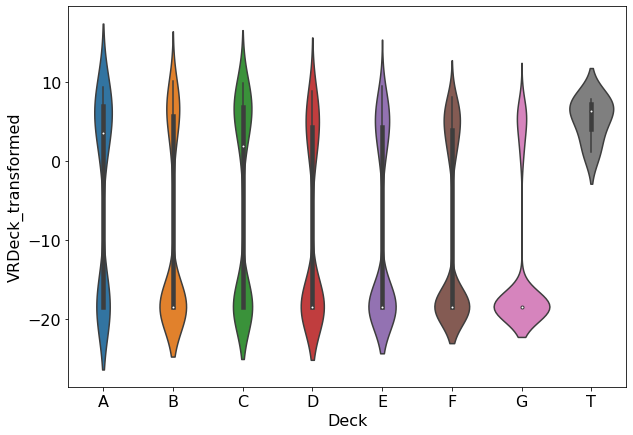

In [231]:
ax = sns.violinplot(x='Deck', y='VRDeck_transformed', data=df)

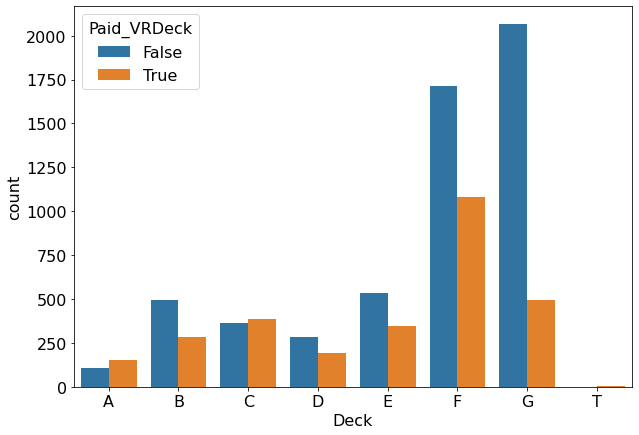

In [232]:
sns.countplot(data=df, x="Deck", hue="Paid_VRDeck");

Majority of the passengers from decks A and C and all passengers from deck T were billed for VRDeck

##### VRDeck vs. Side

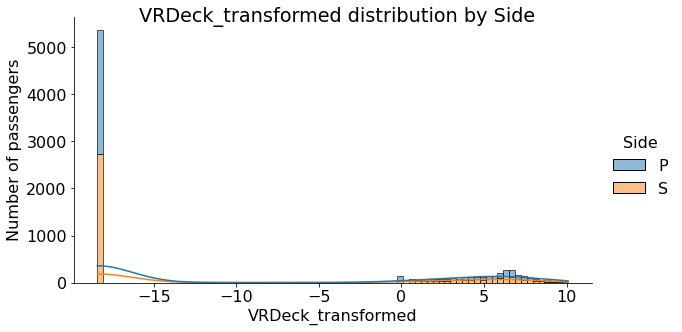

In [233]:
group_displot(('VRDeck_transformed', 'Side'))

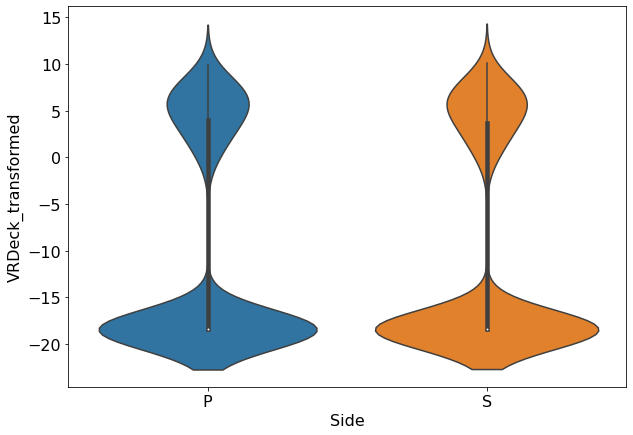

In [234]:
ax = sns.violinplot(x='Side', y='VRDeck_transformed', data=df)

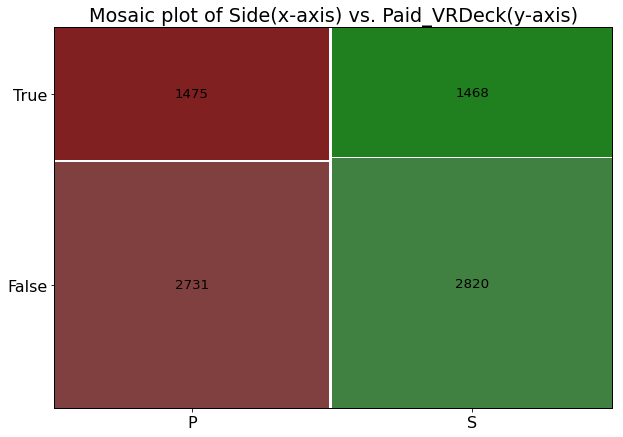

In [235]:
plot_mosaic(('Side', 'Paid_VRDeck'), bool_strings=(False, True))

There is no significant dependences between passenger `VRDeck` billing amount and its cabin `Side`

#### GroupSize

##### GroupSize vs. Deck

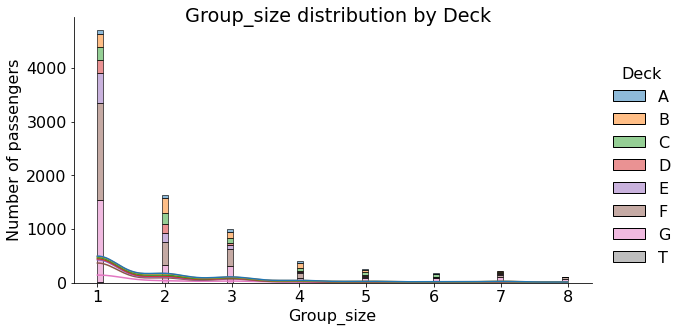

In [236]:
group_displot(('Group_size', 'Deck'))

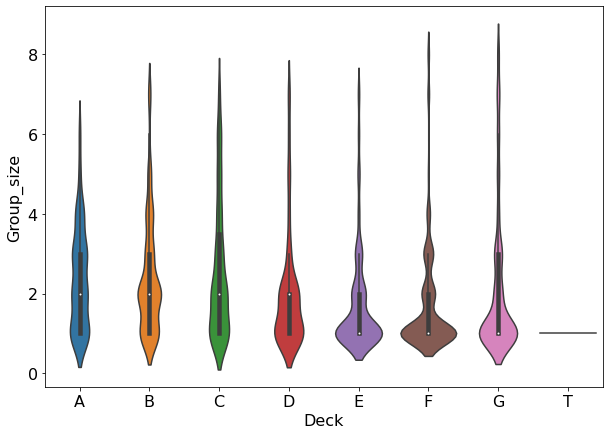

In [237]:
ax = sns.violinplot(x='Deck', y='Group_size', data=df)

Most single passengers on decks E, F and G, but also large groups (7 and 8 passengers together) were located on the same decks. Groups 1-6 passengers are approximately equally distributed accross decks A, B, C and D. Deck T is occupied only by single passengers

##### GroupSize vs. Side

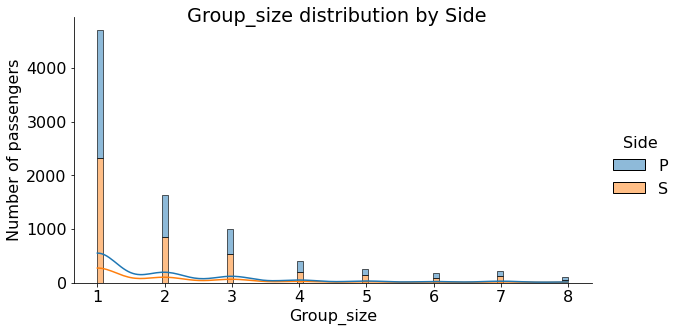

In [238]:
group_displot(('Group_size', 'Side'))

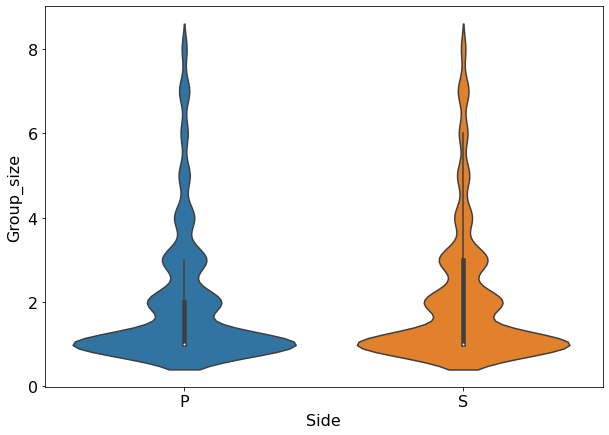

In [239]:
ax = sns.violinplot(x='Side', y='Group_size', data=df)

`Group_size` and `Side` have no significant association or correlation amongst them. 

#### Deck

##### Deck vs. Side

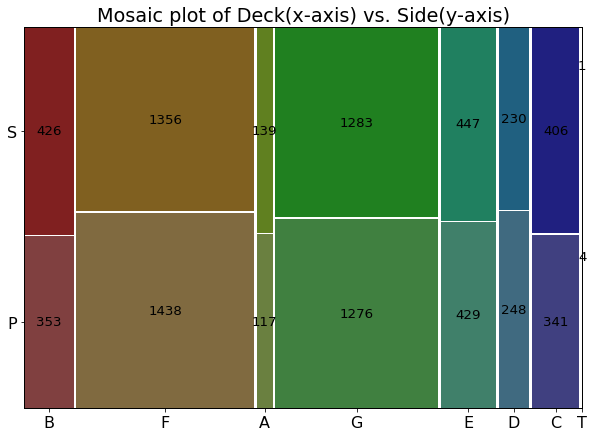

In [240]:
plot_mosaic(('Deck', 'Side'))

While passengers are approximately evenly distributed by sides on decks D, E, F and G, there is a prevalence of side S passengers on decks A, B and C. On deck T there are 3 passengers on side P and only one on side S.

#### Transported

##### Transported vs. HomePlanet

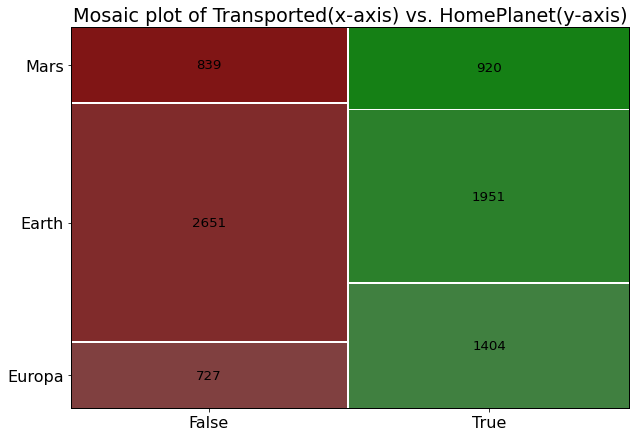

In [241]:
plot_mosaic(('Transported', 'HomePlanet'), bool_strings=(True, False))

While approximately the same number of passengers from Mars were transported to another dimension, significantly more travellers from Earth were **not** transported and for passengers from Europa it is other way round, two time more passengers from this planet were transported to alternate dimension.

##### Transported vs. CryoSleep

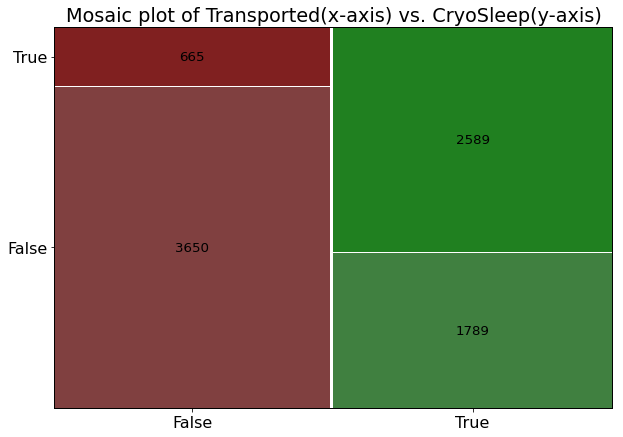

In [242]:
plot_mosaic(('Transported', 'CryoSleep'), bool_strings=(True, True))

From mosaic plot, we see, that majority of the passengers who was in Cryonic sleep were transported, while only about 20% of them were not. For passengers who were **not** elected for Cryonic sleep picture is opposite: just about 30% of them were transported to another dimension

##### Transported vs. Destination

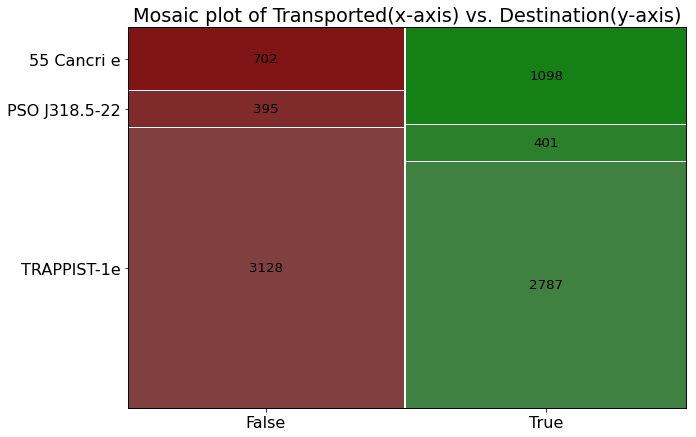

In [243]:
plot_mosaic(('Transported', 'Destination'), bool_strings=(True, False))

Significantly less travellers to TRAPPIST-1e were transported to another dimension than stayed. For travellers to PSO J318.5-22 numbers of transported and not transported passengers are almost equal. And among travellers to 55 Cancri e, more were transported than stayed.

##### Transported vs. Age

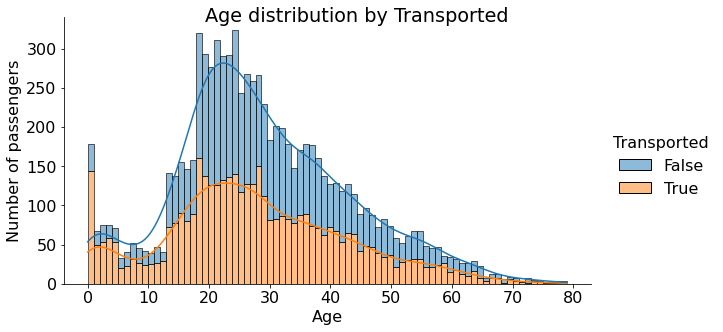

In [244]:
group_displot(('Age', 'Transported'))

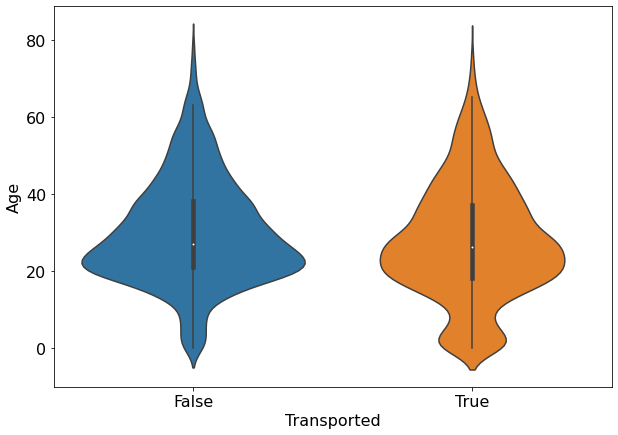

In [245]:
ax = sns.violinplot(x='Transported', y='Age', data=df)

Most of the passengers between 0 and 13 years old were transported, while for older people distribution is approximately the same.

##### Transported vs. VIP

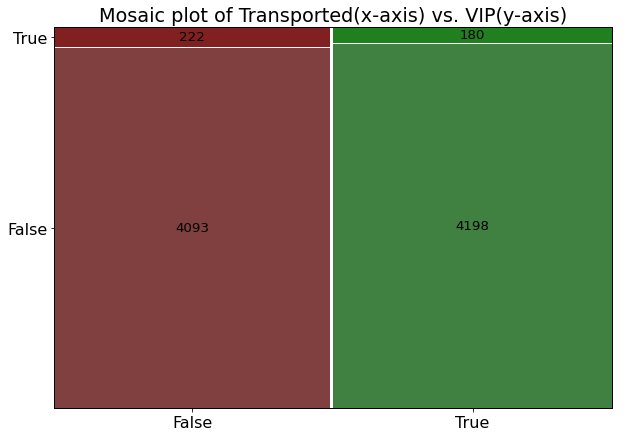

In [246]:
plot_mosaic(('Transported', 'VIP'), bool_strings=(True, True))

Among passengers with VIP status majority was not transported, but among non-VIP passengers more were transported.

##### Transported vs. RoomService

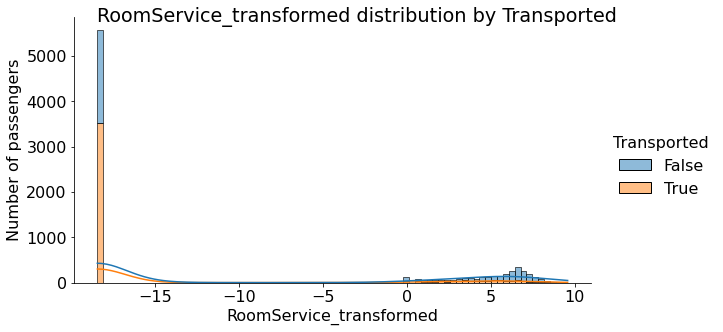

In [247]:
group_displot(('RoomService_transformed', 'Transported'))

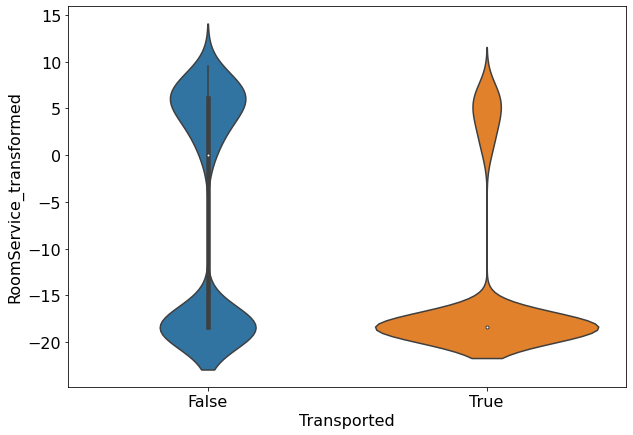

In [248]:
ax = sns.violinplot(x='Transported', y='RoomService_transformed', data=df)
#plt.yscale('log')

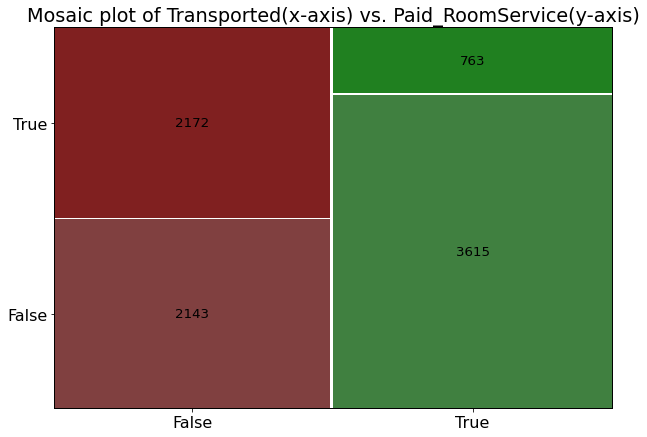

In [249]:
plot_mosaic(('Transported', 'Paid_RoomService'), bool_strings=(True, True))

From plots we can see, that passengers who eventually were transported spent less money on Room Service, in average. Among the passengers who spent money on Room Service, the majority stayed

##### Transported vs. FoodCourt

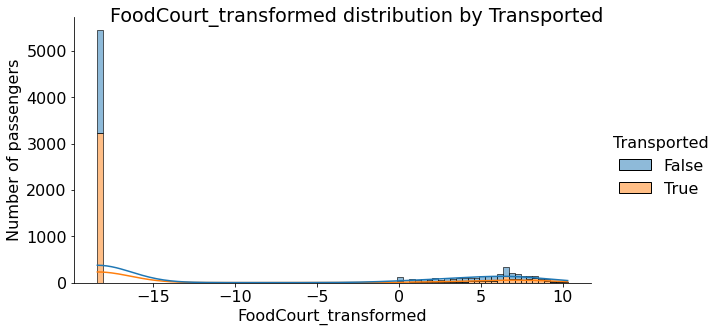

In [250]:
group_displot(('FoodCourt_transformed', 'Transported'))

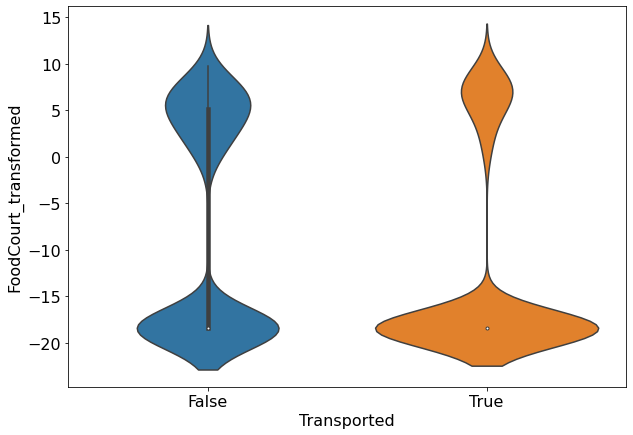

In [251]:
ax = sns.violinplot(x='Transported', y='FoodCourt_transformed', data=df)

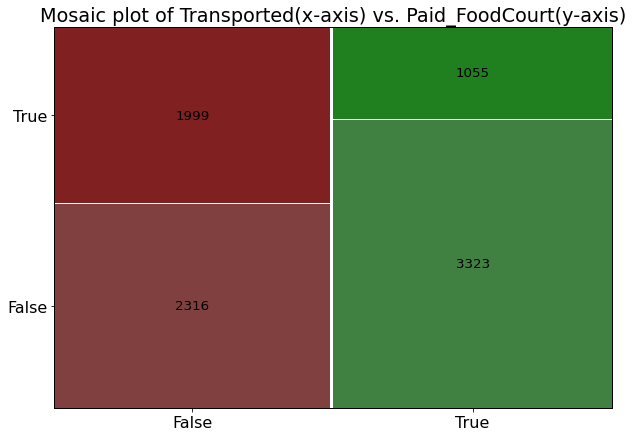

In [252]:
plot_mosaic(('Transported', 'Paid_FoodCourt'), bool_strings=(True, True))

From plots we can see, that passengers who eventually were transported spent less money on Food Court in average.

##### Transported vs. ShoppingMall

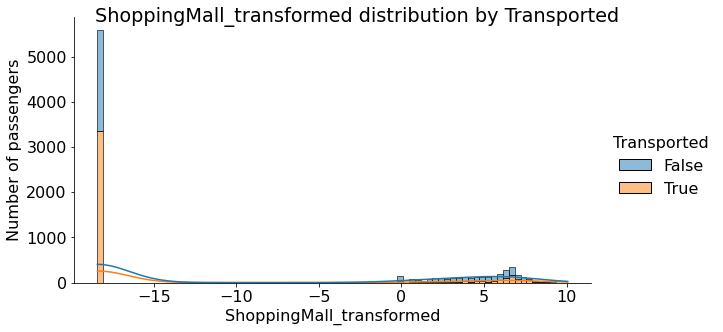

In [253]:
group_displot(('ShoppingMall_transformed', 'Transported'))

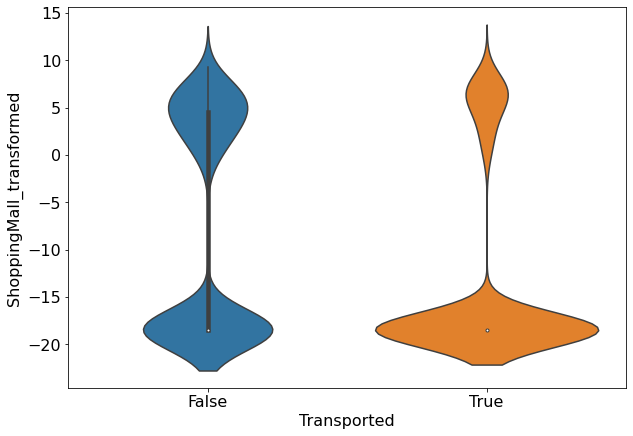

In [254]:
ax = sns.violinplot(x='Transported', y='ShoppingMall_transformed', data=df)

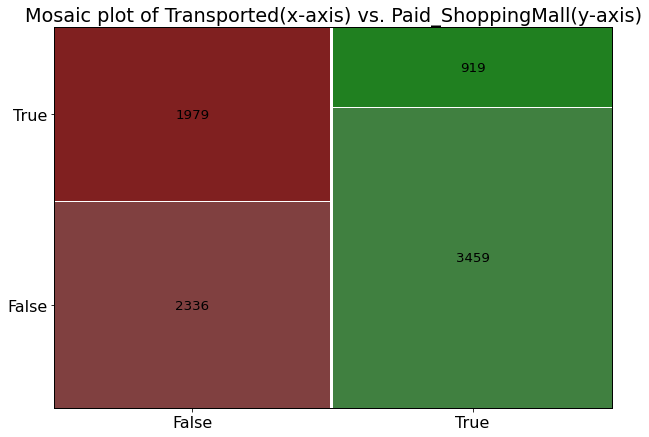

In [255]:
plot_mosaic(('Transported', 'Paid_ShoppingMall'), bool_strings=(True, True))

From plots we can see, that passengers who eventually were transported spent less money in Shopping Mall in average.

##### Transported vs. Spa

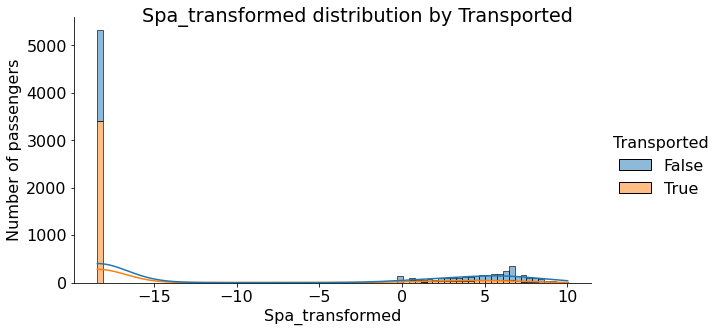

In [256]:
group_displot(('Spa_transformed', 'Transported'))

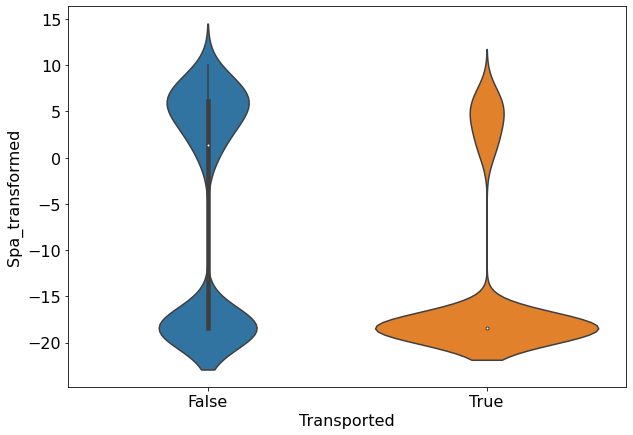

In [257]:
ax = sns.violinplot(x='Transported', y='Spa_transformed', data=df)

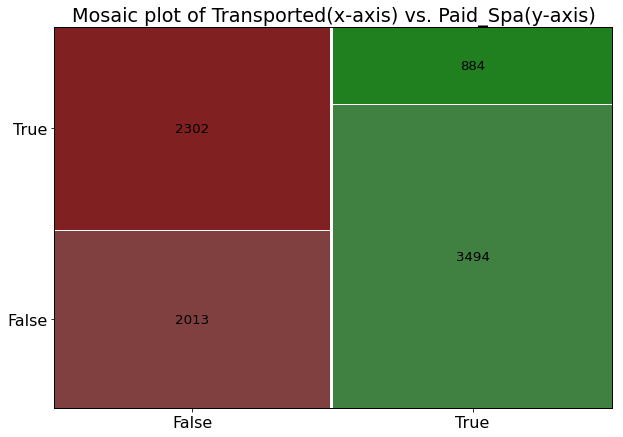

In [258]:
plot_mosaic(('Transported', 'Paid_Spa'), bool_strings=(True, True))

From plots we can see, that passengers who eventually were transported spent significantly less money on Spa.

##### Transported vs. VRDeck

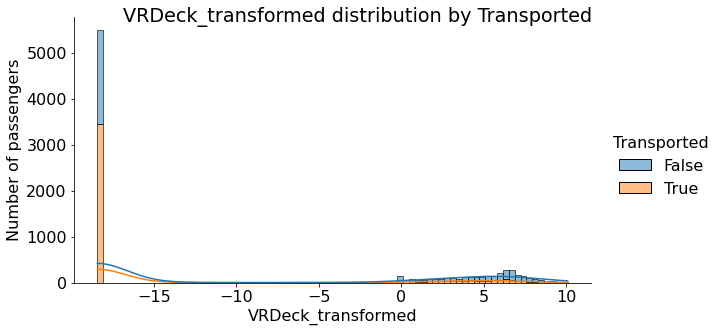

In [259]:
group_displot(('VRDeck_transformed', 'Transported'))

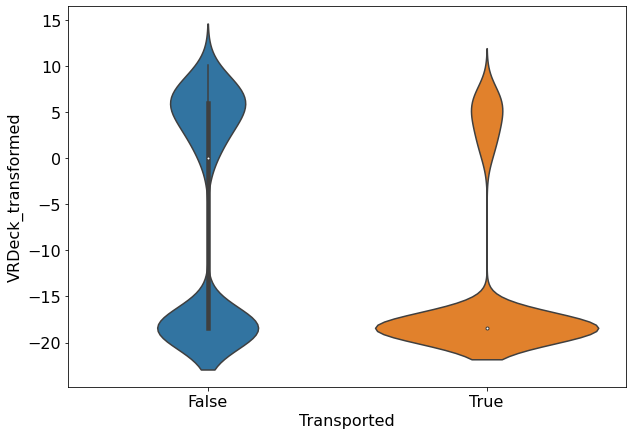

In [260]:
ax = sns.violinplot(x='Transported', y='VRDeck_transformed', data=df)

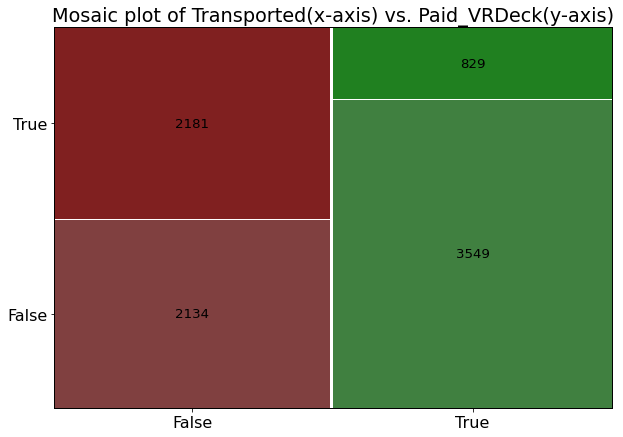

In [261]:
plot_mosaic(('Transported', 'Paid_VRDeck'), bool_strings=(True, True))

From plots we can see, that passengers who eventually were transported spent significantly less money on VRDeck.

##### Transported vs. GroupSize

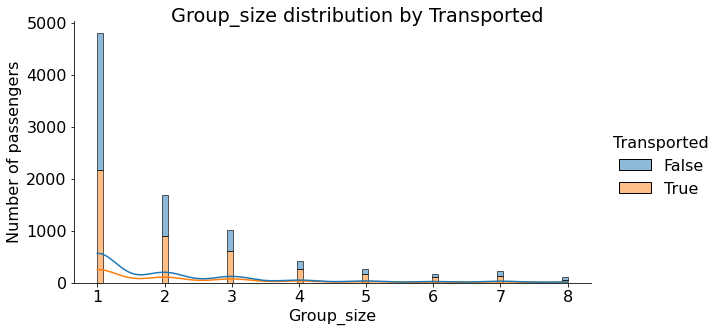

In [262]:
group_displot(('Group_size', 'Transported'))

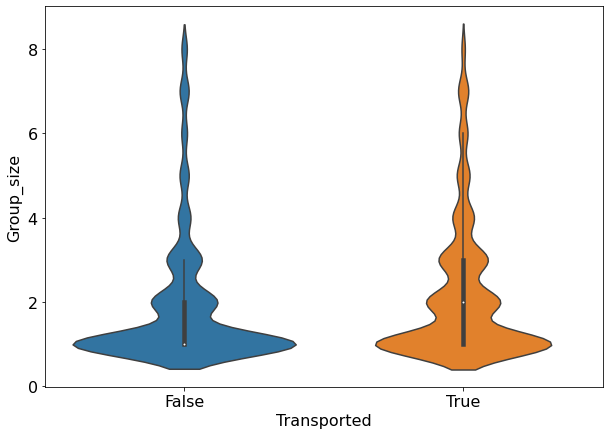

In [263]:
ax = sns.violinplot(x='Transported', y='Group_size', data=df)

More single travelleres avoided transportation, but among passengers who travelled in 2-7 people groups, more were transported

##### Transported vs. Deck

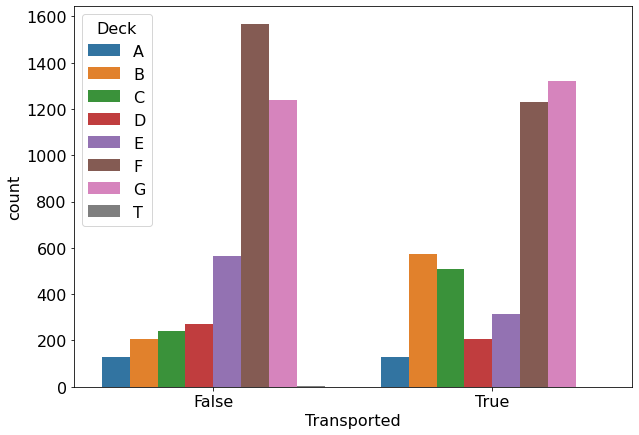

In [264]:
# Mosaic plot is not easy to read when many categories
sns.countplot(data=df, x="Transported", hue="Deck");

From bar plot, we see, that from deck A appoximately the same amount of passengers were and were not trasported. From decks B, C, and G majority of the passengers were transported. From decks D, E, F and T more people were **not** transported

##### Transported vs. Side

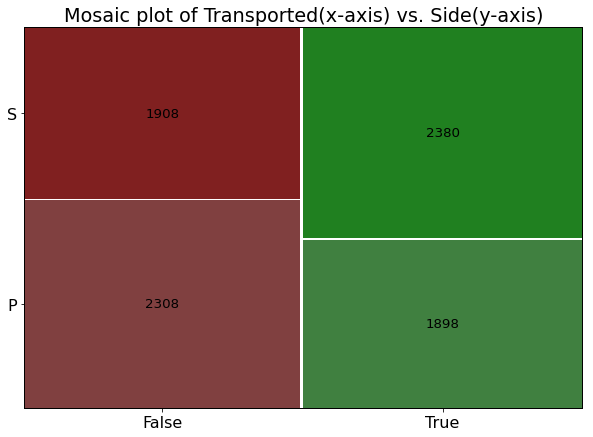

In [265]:
plot_mosaic(('Transported', 'Side'), bool_strings=(True, False))

More passengers from side S were transported while less from side P.

##### Transported among groupmates

First, let's check how groupmates, namesakes and cabinmates are intersected with each other

In [266]:
# How many groups also share the same Last Name

def all_equal(lst):
    return lst[:-1] == lst[1:]

group_name_shared = 0
group_cabin_shared = 0
for key, item in df[df['Group_size']>1].groupby(by = 'GroupId'):
    last_names = item['Last_name'].to_list()    # NaNs will be ignored
    if all_equal(last_names): group_name_shared +=1
    cabins = item['Cabin'].to_list()    # NaNs will be ignored
    if all_equal(cabins): group_cabin_shared +=1

name_cabin_shared = 0
name_group_shared = 0
for key, item in df[df['Number_of_namesakes']>1].groupby(by = 'Last_name'):
    cabins = item['Cabin'].to_list()    # NaNs will be ignored
    if all_equal(cabins): name_cabin_shared +=1
    groups = item['GroupId'].to_list()
    if all_equal(groups): name_group_shared +=1


cabin_name_shared = 0
cabin_group_shared = 0
for key, item in df[df['Number_of_cabinmates']>1].groupby(by = 'Cabin'):
    last_names = item['Last_name'].to_list()    # NaNs will be ignored
    if all_equal(last_names): cabin_name_shared +=1
    groups = item['GroupId'].to_list()
    if all_equal(groups): cabin_group_shared +=1

print(f"Total number of groups larger than one person: {df[df['Group_size']>1]['GroupId'].nunique()}")
print(f'\tGroups who shared the same last name: {group_name_shared}')
print(f'\tGroups who shared the same cabin: {group_cabin_shared}')

print(f"Total number of last names who more than one person has: {df[df['Number_of_namesakes']>1]['Last_name'].nunique()}")
print(f'\tNamesakes who shared the same cabin: {name_cabin_shared}')
print(f'\tNamesakes who are in the same group: {name_group_shared}')

print(f"Total number of cabins occupied with more than one person: {df[df['Number_of_cabinmates']>1]['Cabin'].nunique()}")
print(f'\tCabinmates who shared the same last name: {cabin_name_shared}')
print(f'\tCabinmates who are in the same group: {cabin_group_shared}')

Total number of groups larger than one person: 1412
	Groups who shared the same last name: 1088
	Groups who shared the same cabin: 904
Total number of last names who more than one person has: 1835
	Namesakes who shared the same cabin: 143
	Namesakes who are in the same group: 171
Total number of cabins occupied with more than one person: 1133
	Cabinmates who shared the same last name: 850
	Cabinmates who are in the same group: 1133


We see, that most of the passengers who travelled in groups are sharing the same last name and the cabin. Also, all cabinmates were from the same groups. Similar last names don't really indicate group or cabin sharing.

Let's combine all passengers who travelled in groups

In [267]:
df_groups = df.groupby(by='GroupId')
# How many people were transported from the same group?
transported_from_group = df_groups['Transported'].sum().rename('Transported_from_group')
# Add coulmn to df
df = pd.merge(df, transported_from_group, how='left', on='GroupId')

In [268]:
# Check how many groups (>1 person) were transported completely (Transported_from_group == Group_size) or not transported completely (Transported_from_group == 0)
print(f"Total number of groups with more than one person: {df[(df['Group_size'] > 1)]['GroupId'].nunique()}")
print(f"Number of groups where all members were or were not transported: {df[(df['Group_size'] > 1) & ((df['Group_size'] == df['Transported_from_group']) | (df['Transported_from_group'] == 0))]['GroupId'].nunique()}")

Total number of groups with more than one person: 1412
Number of groups where all members were or were not transported: 615


Less than half of the passengers travelled together were not separated due to event.

##### Transported among namesakes

In [269]:
df_groups = df.groupby(by='Last_name')
#df = pd.merge(df, df_groups['PassengerId'].count().rename('Number_of_namesakes'), on='Last_name')
# How many people were transported from the same group?
transported_from_namesakes = df_groups['Transported'].sum().rename('Transported_from_namesakes')
# Add coulmn to df
df = pd.merge(df, transported_from_namesakes, how='left', on='Last_name')



In [270]:
print(f"Total number of last names wich more than one person has: {df[(df['Number_of_namesakes'] > 1)]['Last_name'].nunique()}")
print(f"Number of last names where all namesakes were or were not transported: {df[(df['Number_of_namesakes'] > 1) & ((df['Number_of_namesakes'] == df['Transported_from_namesakes']) | (df['Transported_from_namesakes'] == 0))]['Last_name'].nunique()}")

Total number of last names wich more than one person has: 1835
Number of last names where all namesakes were or were not transported: 430


Less than 1/4 of the last namesake teams were not separated

##### Transported among cabinmates

In [271]:
df_groups = df.groupby(by='Cabin')
#df = pd.merge(df, df_groups['PassengerId'].count().rename('Number_of_cabinmates'), on='Cabin')
# How many people were transported from the same group?
transported_from_cabinmates = df_groups['Transported'].sum().rename('Transported_from_cabinmates')
# Add coulmn to df
df = pd.merge(df, transported_from_cabinmates, how='left', on='Cabin')

In [272]:
print(f"Total number of cabins wich had more than one person in: {df[(df['Number_of_cabinmates'] > 1)]['Cabin'].nunique()}")
print(f"Number of cabins from where all passengers were or were not transported: {df[(df['Number_of_cabinmates'] > 1) & ((df['Number_of_cabinmates'] == df['Transported_from_cabinmates']) | (df['Transported_from_cabinmates'] == 0))]['Cabin'].nunique()}")

Total number of cabins wich had more than one person in: 1133
Number of cabins from where all passengers were or were not transported: 524


Almost half of cabins were transported or not transported competely

Let's preform trivariate analysis of `Transported`. I will take pairs of some non-correlated (or not strongly correlated) features and plot them with `Transported` information

##### Transported vs HomePlanet & CryoSleep

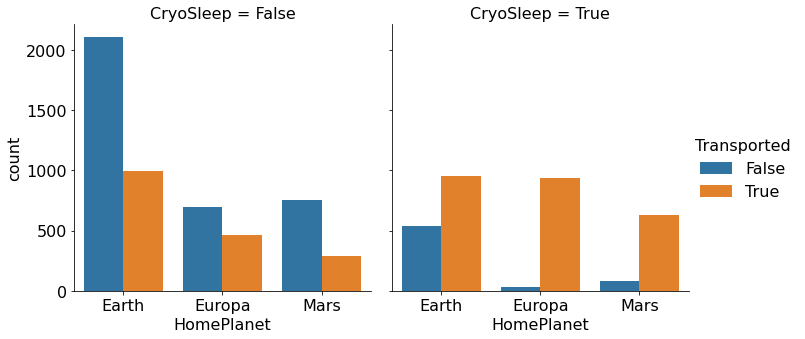

In [273]:
g = sns.catplot(x="HomePlanet", hue="Transported", col="CryoSleep", data=df, kind="count");

Among the passengers who were in Cryonic sleep almost equal amount of passengers from Earth and Europa were transported, while for non-cryosleep passengers it is not a case

##### Transported vs HomePlanet & Age

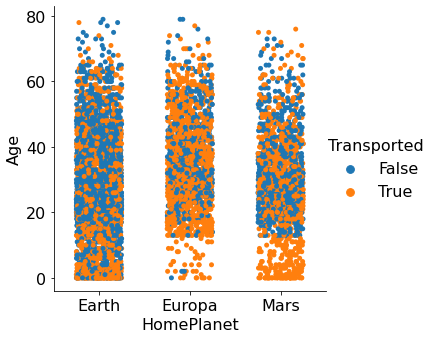

In [274]:
g = sns.catplot(x="HomePlanet", y='Age', hue="Transported", data=df, jitter=0.25);

Vast majority of young passengers from Europa and Mars were transported. It is not a case for Earth

##### Transported vs HomePlanet & VIP

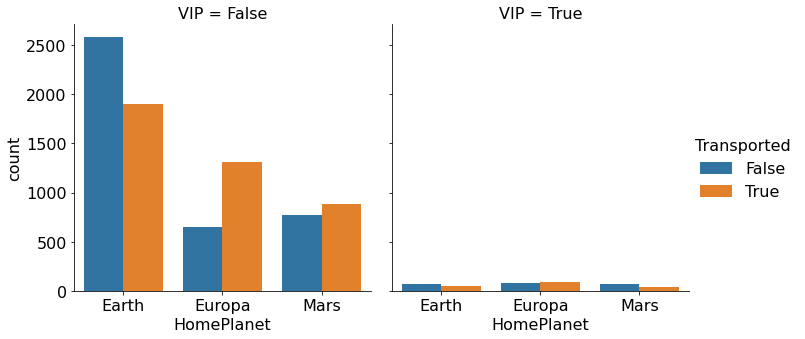

In [275]:
g = sns.catplot(x="HomePlanet", hue="Transported", col="VIP", data=df, kind="count");

A bit more non-VIP passengers from Mars were transported than not, while for VIP passengers from Mars it is opposite. For other home planets distribution is about the same

##### Transported vs HomePlanet & Spa

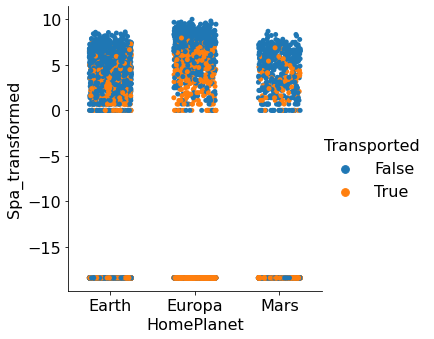

In [276]:
g = sns.catplot(x="HomePlanet", y='Spa_transformed', hue="Transported", data=df, jitter=0.25);

Passengers from Mars, who spent small amounts on Spa, mostly were not transproted, compare to other home planets, but among the Marsians who spent nothing on Spa more passengers were transported. This last statement is also valid for other home planets

##### Transported vs HomePlanet & GroupSize

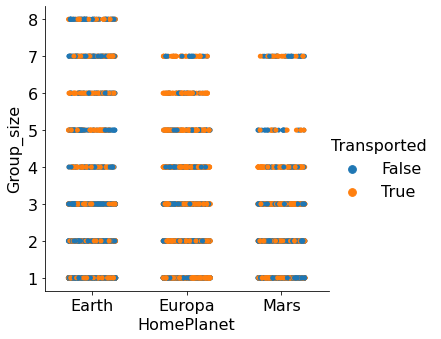

In [277]:
g = sns.catplot(x="HomePlanet", y='Group_size', hue="Transported", data=df, jitter=0.25);

There is no visible significant correlation in the 2D Group_size x HomePlanet space

##### Transported vs CryoSleep & Age

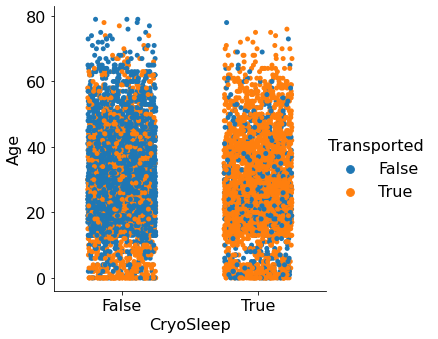

In [278]:
g = sns.catplot(x="CryoSleep", y='Age', hue="Transported", data=df, jitter=0.25);

More young passengers who were not in cryosleep were transported, than not

##### Transported vs CryoSleep & VIP

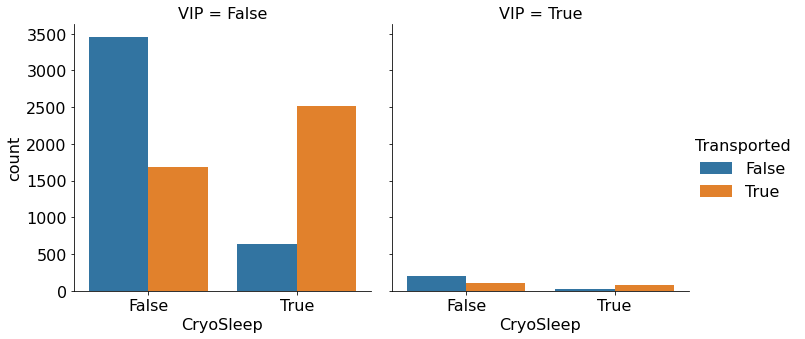

In [279]:
g = sns.catplot(x="CryoSleep", hue="Transported", col="VIP", data=df, kind="count");

Distributions of transported passengers who were and were not in CryoSleep a generally the same for VIP and non-VIP passengers

##### Transported vs CryoSleep & Group_size

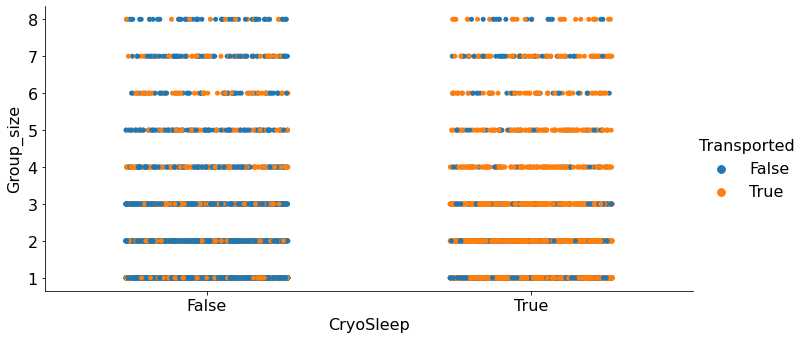

In [280]:
g = sns.catplot(x="CryoSleep", y='Group_size', hue="Transported", data=df, jitter=0.25, height=5, aspect=2);

In group size 6, more passengers who were not in cryosleep were transported, than not. In other group sizes, visible correlation between CryoSleep and Transported is the same

##### Transported vs Destination & Age

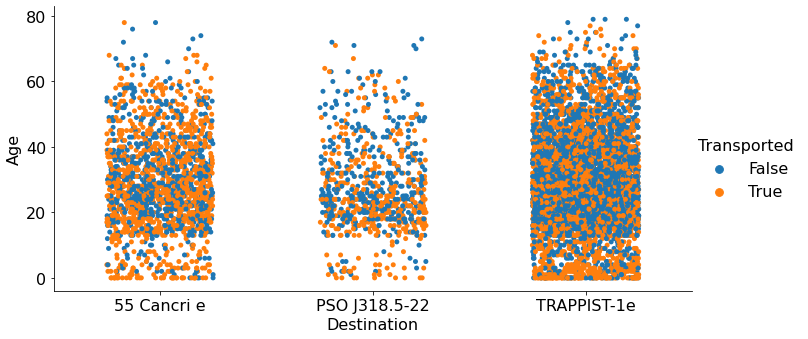

In [281]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.catplot(x="Destination", y='Age', hue="Transported", data=df, jitter=0.25, height=5, aspect=2);

More young passengers who travelled to 55 Cancri e were transported. On other destinations there is no so strong dependence

##### Transported vs Destination & VIP

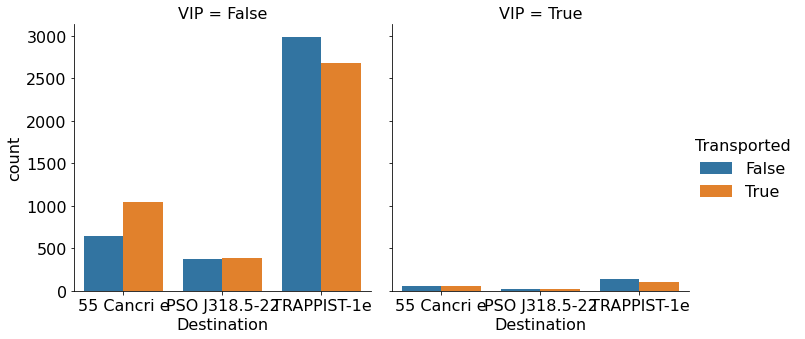

In [282]:
g = sns.catplot(x="Destination", hue="Transported", col="VIP", data=df, kind="count");

Among non-VIP passengers  a bit more travellers to 55 Cancri e were transported than not. For other destinations distribution of VIP and non-VIP passengers, were they transported or not, are approximately the same

##### Transported vs Destination & FoodCourt

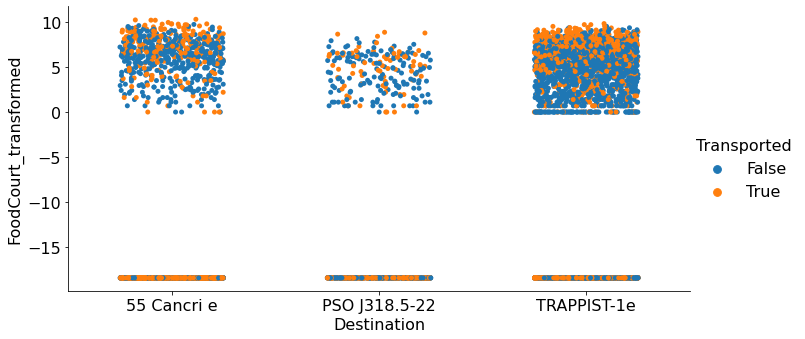

In [283]:
g = sns.catplot(x="Destination", y='FoodCourt_transformed', hue="Transported", data=df, jitter=0.25, height=5, aspect=2);

There is no visible significant correlation in the 2D Destination x FoodCourt space

##### Transported vs Age & RoomService

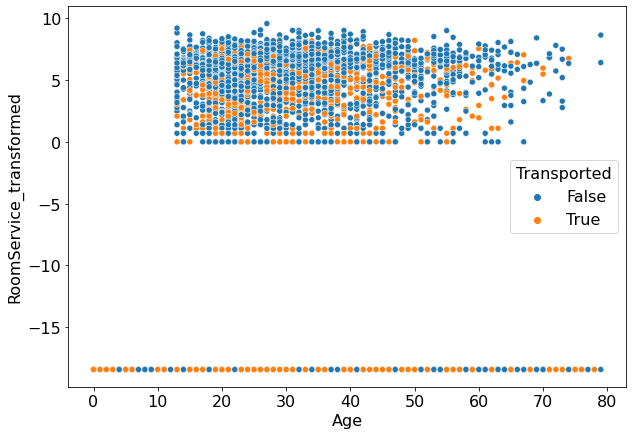

In [284]:
sns.scatterplot(data=df, x='Age', y='RoomService_transformed', hue='Transported');

It looks like there is some correlation, but it is not linear and hardly can be confirmed visually

##### Transported vs Age & Group_size

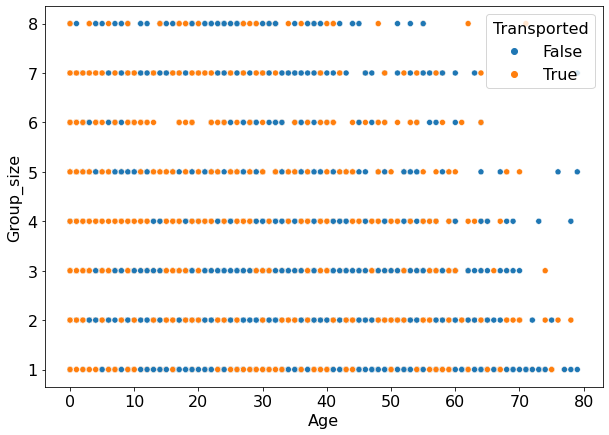

In [285]:
sns.scatterplot(data=df, x='Age', y='Group_size', hue='Transported');

The youngest passengers from all group sizes were mostly transported. The oldest passengers from groups with size 7, 5, 4 and 1 were not transported

##### Transported vs Age & Deck

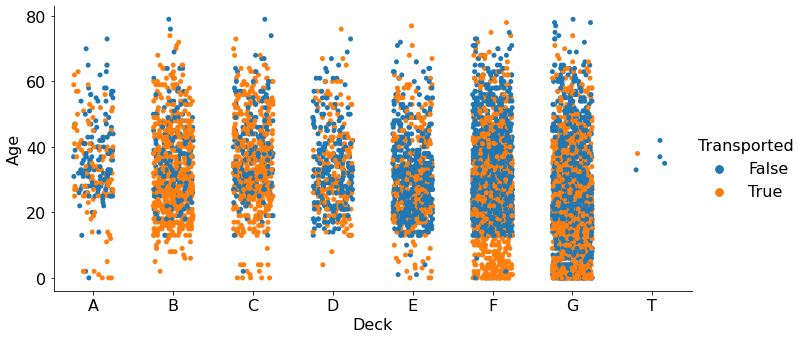

In [286]:
g = sns.catplot(x="Deck", y='Age', hue="Transported", data=df, jitter=0.25, height=5, aspect=2);

Young passengers from decks B, C and F were almost all of them transported. On other decks distribution is approximately independent from age

##### Transported vs RoomService & Deck

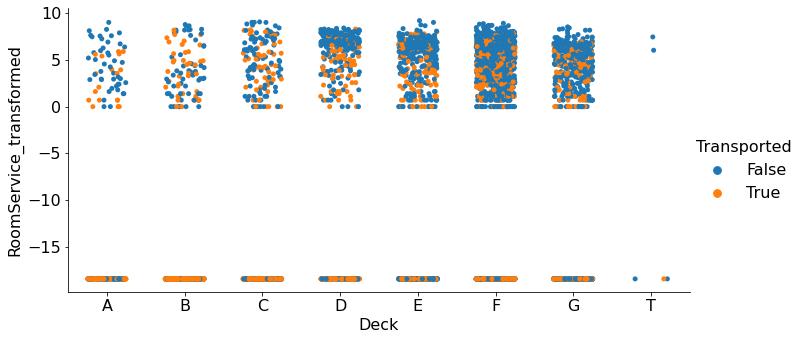

In [287]:
g = sns.catplot(x="Deck", y='RoomService_transformed', hue="Transported", data=df, jitter=0.25, height=5, aspect=2);

Most of the passengers from deck D who spent large amount of money on RoomService were not transported. Similar, but less effective it is valid for decks F and G. On other decks it looks generally independent

#### Multivariate analysis summary

- NA values are random in dataset, about 200 in each column
- `CryoSleep` has relatively strong correlation with additional services on SpaceShip
- Most of the features are correlated with each other 
- Transformed distributions of billing on additional services show, that most probably they can be binarized
- `Side` doesn't correlate with any of features, but with outcome `Transported`
- Children below 13 years old were not billed for additional services
- Passengers from different decks spent money different
- Outcome variable `Transported` shows some correlation from all features. That can be caused by intercorrelations between them
- Groupmates and cabinmates are mostly intersected
- Many namesakes were on the SpaceShip, who eventually not groupmates or cabinmates
- About half of groups were splitted during the event 
- Age distributions of transported or not transported passengers depends on their deck, Home Planet and Destination
- CrySleep influence on `Transported` depends on HomePlanet


[Contents](#contents)

### Test set analysis
In many cases real test set is not avaliable or considered as unknown data. For this project, we have a legend, that test data were saved from the board computer, but without outcome variable. Thus, we have a chance to look on it and compare distributions with the train set. It will not be detailed analysis, just quick comparison, to ensure that distributions are generally the same.

In [288]:
df_kaggle_test.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez

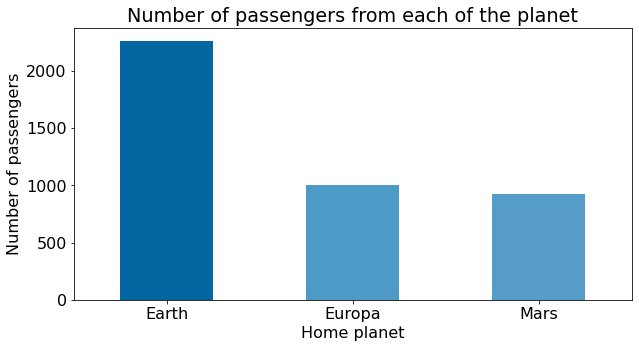

In [289]:
# How many passengers from each of the planet
plot_groups('HomePlanet', df=df_kaggle_test, xlabel='Home planet', ylablel='Number of passengers', title='Number of passengers from each of the planet')

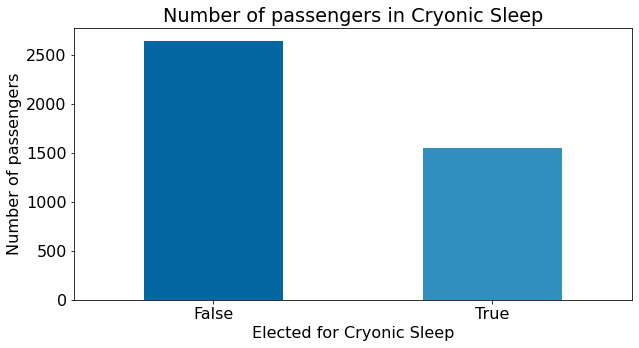

In [290]:
plot_groups('CryoSleep', df=df_kaggle_test, xlabel='Elected for Cryonic Sleep', ylablel='Number of passengers', title='Number of passengers in Cryonic Sleep')

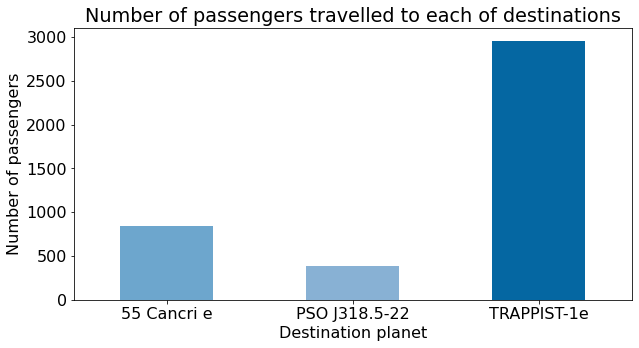

In [291]:
plot_groups('Destination', df=df_kaggle_test, xlabel='Destination planet', ylablel='Number of passengers', title='Number of passengers travelled to each of destinations')

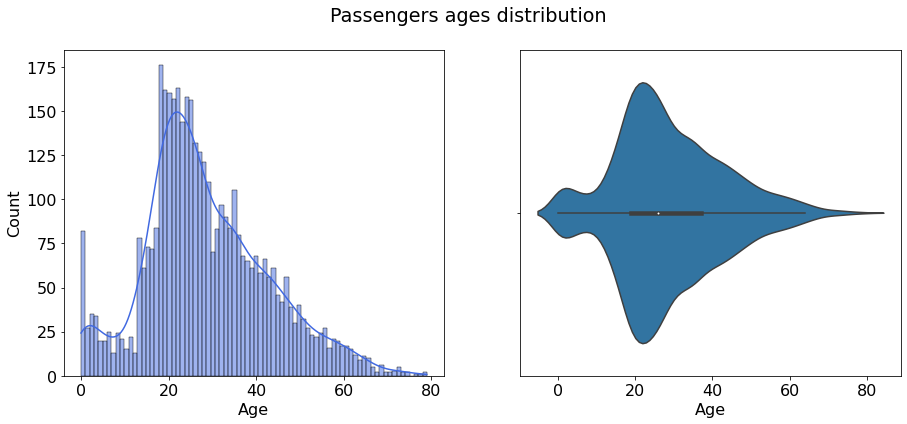

In [292]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
sns.histplot(x=df_kaggle_test['Age'], kde=True, bins=80, color = 'royalblue', ax=ax[0])
sns.violinplot(x=df_kaggle_test['Age'], ax=ax[1])
fig.suptitle("Passengers ages distribution")
plt.show();

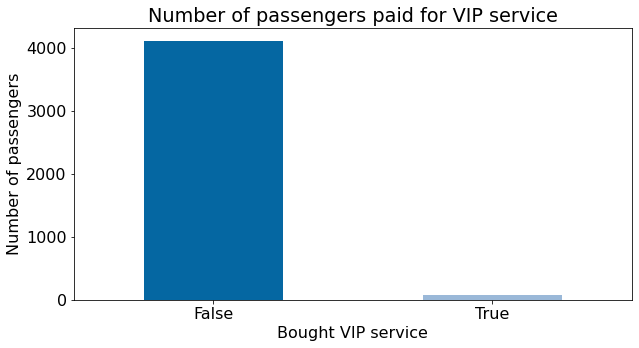

In [293]:
plot_groups('VIP', df=df_kaggle_test, xlabel='Bought VIP service', ylablel='Number of passengers', title='Number of passengers paid for VIP service')

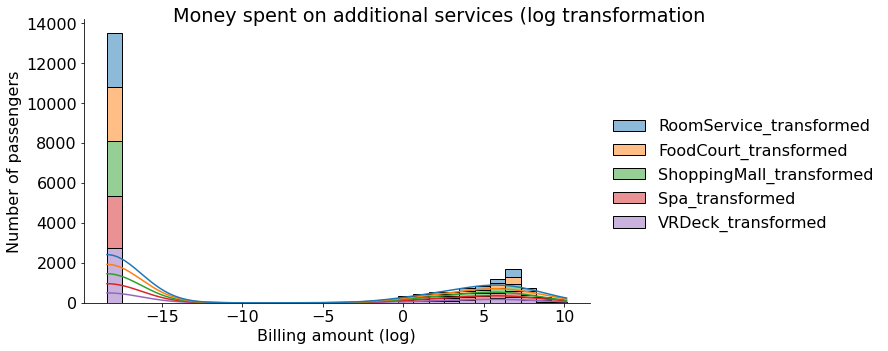

In [294]:
epsilon = 0.00000001
df_kaggle_test['RoomService_transformed'] = df_kaggle_test['RoomService'].apply(lambda x: np.log(x + epsilon))
df_kaggle_test['FoodCourt_transformed'] = df_kaggle_test['FoodCourt'].apply(lambda x: np.log(x + epsilon))
df_kaggle_test['ShoppingMall_transformed'] = df_kaggle_test['ShoppingMall'].apply(lambda x: np.log(x + epsilon))
df_kaggle_test['Spa_transformed'] = df_kaggle_test['Spa'].apply(lambda x: np.log(x + epsilon))
df_kaggle_test['VRDeck_transformed'] = df_kaggle_test['VRDeck'].apply(lambda x: np.log(x + epsilon))

g = sns.displot(df_kaggle_test[['RoomService_transformed', 'FoodCourt_transformed', 'ShoppingMall_transformed', 'Spa_transformed', 'VRDeck_transformed']], kde=True, bins=30, multiple="stack", height=4.75, aspect=1.83)
g.set_axis_labels("Billing amount (log)", "Number of passengers")
g.fig.suptitle("Money spent on additional services (log transformation");

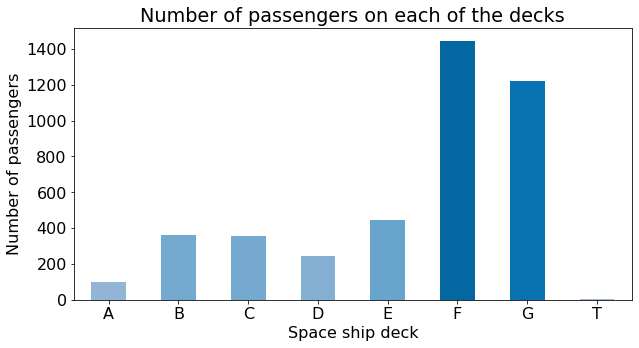

In [295]:
df_kaggle_test[['Deck', 'Num', 'Side']] = df_kaggle_test['Cabin'].str.split('/', expand=True)
plot_groups('Deck', df=df_kaggle_test, xlabel='Space ship deck', ylablel='Number of passengers', title='Number of passengers on each of the decks')

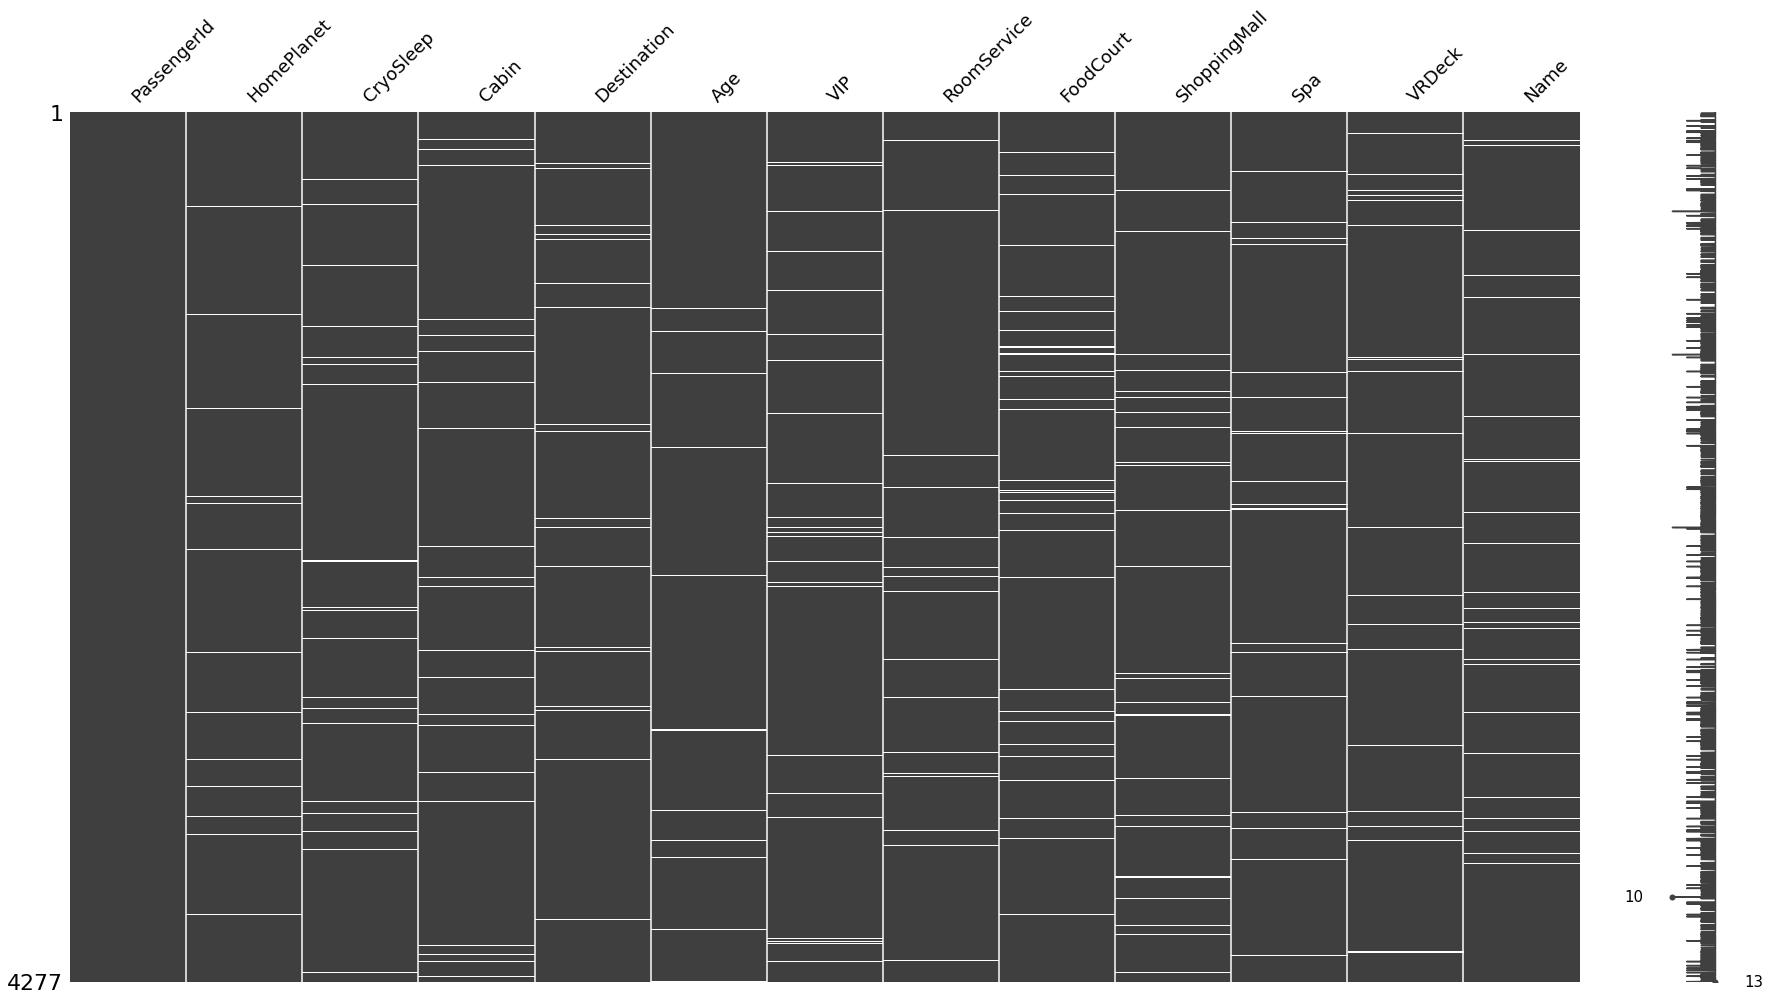

In [296]:
msno.matrix(df_kaggle_test[original_columns[:-1]],figsize=(30,16),fontsize=18); ## Visualize missing values as a matrix

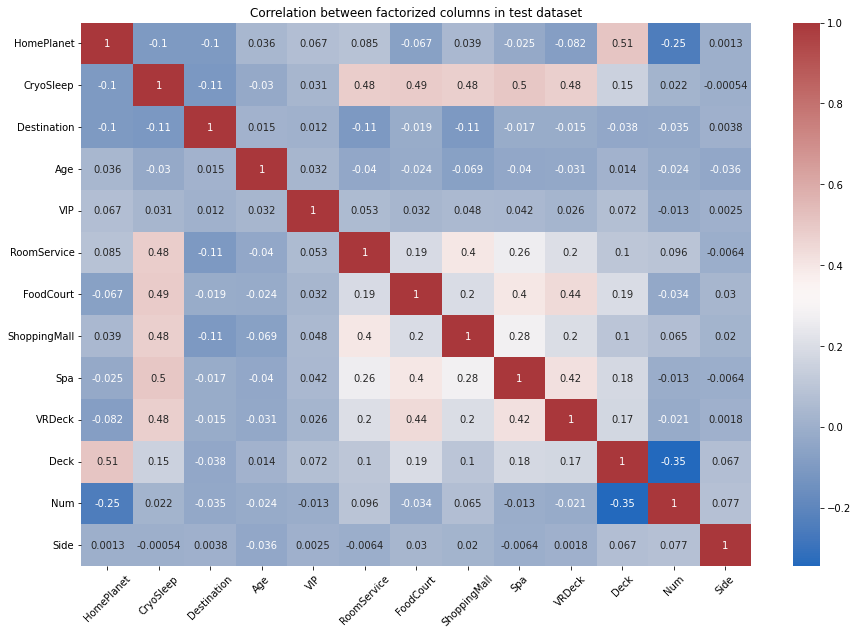

In [297]:
# Factorize categorical variables to build correlation matrix for initial correlation estimation, remove text variables and some of artificially created, as we know the
cols_to_drop = ['Cabin', 'Name', 'PassengerId', 'RoomService_transformed', 
                'FoodCourt_transformed', 'ShoppingMall_transformed', 
                'Spa_transformed', 'VRDeck_transformed']
df_factor=df_kaggle_test.drop(cols_to_drop, axis=1).apply(lambda x : pd.factorize(x)[0])+1

corr = df_factor.corr(method='spearman')
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 10.0
sns.heatmap(corr, cmap = 'vlag', annot=corr)
plt.xticks(rotation=45) 
plt.title('Correlation between factorized columns in test dataset')
plt.show();
del df_factor


Some correlations may look stronger on the matrix, but reason of that is less number of samples in the test dataset.

Generally, distributions and correlations are looking very similar, therefore we assume, without statistical tests, that they are at least approximately the same and we can propagade our train set EDA on all SpaceShip passengers. This is aligned with the legend of damaged SpaceShip computer: we can assume, that lost information about passengers transported to another dimension was random, not some specific passengers (e.g. only for passengers from one deck, or only young or old passengers)

[Contents](#contents)

## Conclusion

- NA values in dataset are distributed randomly and not so many on them. Suggestion to fill them with median value
- Categorical variables don't show strong correlation with each other, so they should not be removed from the dataset
- Variables `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` have extremely skewed distribution. Also, they are strongly correlating with `CryoSleep` variable. Consider three option for them:
    - Non-linear transformation (because of skewed distribution)
    - Binarisation (False: 0, True: >0) (because distribution is double-headed with a lot of zeroes in between)
    - Removing them completely (because of strong correlation with CryoSleep)
- `Cabin` contains information as Deck and Deck side which should be extracted. 
- `Passenger_Id` contains information of group which the passenger belong to. This should be extracted to find out group sizes, which correlates with the outcome variable. Mostly, passengers from the same group travelled in the same cabin and vice versa
- Half of the groups (and also cabins) were separated during the event of transportation. So, the group_Id can be dropped as `Transported` of one passenger from the group doesn't affect `Transported` of other passenger from the same group. The same is valid for cabins
- Namesakes, while often they are the same family, groupmates or cabinmates, also were splitted during the event. There are many namesakes (even full ones) just by coincidence. `Name` column is not useful for prediction
- Age variable distribution look just a bit skewed, it can be just normilized
- EDA didn't show simple linearity in the dataset, but also showed that `Transported` for sure have some dependences from features: different ML models should be tried.

In [298]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         107.37 seconds
Process memory usage         229.29 MB
